# ML4B trigger analysis from structured data

In [1]:
# Data Libraries
import pandas as pd
import numpy as np
import scipy

# Adel doesn't like this option because it causes Jupyter to hang on large DataFrames
# pd.set_option('display.max_rows',None)

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = 15,15
plt.rcParams["figure.dpi"] = 300
plt.rcParams['figure.max_open_warning'] = False

# Machine Learning Libraries
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


# Other libraries
import pyodbc
import umap
from collections import defaultdict
from scipy.stats import mannwhitneyu, ttest_rel, ttest_ind

# Autoreload set up
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

pd.options.display.max_colwidth = 1500


In [2]:
# extracts all datasets from database with selected prefix
def extractDataset(prefix, excludeSet):
    conn = pyodbc.connect("DRIVER={SQL Server Native Client 11.0};SERVER=VHACDWRB03.vha.med.va.gov;DATABASE=ORD_Singh_201911038D;Trusted_Connection=yes")

    info_df = pd.read_sql(sql="select * from information_schema.tables where table_name like '%{}%'".format(prefix), con=conn)
    display(info_df)
    # read all the tables into pandas tables
    tables = {}
    for tname in info_df.TABLE_NAME:
        if tname.split('_')[-1] in excludeSet:
            continue
        query_str = "select * from  " + str("Dflt.")+ str(tname)
        table_df = pd.read_sql(sql=query_str,con=conn)
        tables[tname.split('_')[-1]] = table_df
    print(tables.keys())
    return tables

In [3]:
dataset = extractDataset("B00_ML4TrgPos_", {"WithRole", "AllMed",  "HF","NonVAMed", "DispensedDrug","Note","Only10daysPrior30DaysAfter"})

TABLE_CATALOG TABLE_SCHEMA  \
0   ORD_Singh_201911038D         Dflt   
1   ORD_Singh_201911038D         Dflt   
2   ORD_Singh_201911038D         Dflt   
3   ORD_Singh_201911038D         Dflt   
4   ORD_Singh_201911038D         Dflt   
5   ORD_Singh_201911038D         Dflt   
6   ORD_Singh_201911038D         Dflt   
7   ORD_Singh_201911038D         Dflt   
8   ORD_Singh_201911038D         Dflt   
9   ORD_Singh_201911038D         Dflt   
10  ORD_Singh_201911038D         Dflt   
11  ORD_Singh_201911038D         Dflt   
12  ORD_Singh_201911038D         Dflt   
13  ORD_Singh_201911038D         Dflt   
14  ORD_Singh_201911038D         Dflt   
15  ORD_Singh_201911038D         Dflt   

                                                     TABLE_NAME  TABLE_TYPE  
0                           _B00_ML4TrgPos_Y201621_01_04_cohort  BASE TABLE  
1                              _B00_ML4TrgPos_Y201621_05_04_Rad  BASE TABLE  
2                       _B00_ML4TrgPos_Y201621_30_Note_WithRole  BASE TABLE  
3                                _B00_ML4TrgPos_Y201621_30_Note  BASE TABLE  
4                              _B00_ML4TrgPos_Y201621_04_04_Lab  BASE TABLE  
5                     _B00_ML4TrgPos_Y201621_06_Med_04_RxOutpat  BASE TABLE  
6                     _B00_ML4TrgPos_Y201621_06_Med_07_NonVAMed  BASE TABLE  
7           _B00_ML4TrgPos_Y201621_06_Med_05_BCMA_DispensedDrug  BASE TABLE  
8                       _B00_ML4TrgPos_Y201621_06_Med_08_AllMed  BASE TABLE  
9                             _B00_ML4TrgPos_Y201621_08_Consult  BASE TABLE  
10                                _B00_ML4TrgPos_Y201621_12_ICD  BASE TABLE  
11                              _B00_ML4TrgPos_Y201621_14_Vital  BASE TABLE  
12                                 _B00_ML4TrgPos_Y201621_16_HF  BASE TABLE  
13                         _B00_ML4TrgPos_Y201621_05_04_Rad_new  BASE TABLE  
14                   _B00_ML4TrgPos_Y201621_01_04_Demorgraphics  BASE TABLE  
15  _B00_ML4TrgPos_Y201621_05_04_Rad_Only10daysPrior30DaysAfter  BASE TABLE

dict_keys(['cohort', 'Rad', 'Lab', 'RxOutpat', 'Consult', 'ICD', 'Vital', 'new', 'Demorgraphics'])


# Support functions
- umap plot
- cluster umap
- get labeled data on abpain trigger

In [4]:
# see if there are any clusters based on any of the considered variables

import umap
from sklearn.cluster import KMeans

# label list should be in order 0,1 

def umap_plot_label(X,y,rseed,nbrs,label_list):
    nclasses = len(label_list)
    # standard scale X
    scaler = StandardScaler()
    sX = scaler.fit_transform(X.astype(float))
    
    reducer = umap.UMAP(metric='correlation',min_dist=0.0,n_neighbors=nbrs,random_state=rseed)
    u = reducer.fit_transform(X)
    cc = plt.cm.rainbow(np.linspace(0,1,nclasses))
    colors = {0:cc[0],1:cc[1]}
    plt.subplots(figsize=(8,8))
    for i in range(nclasses):
        plt.scatter(u[y==i,0],u[y==i,1],alpha=0.5,s=40,label=label_list[i],color=colors[i])

    plt.legend()
    return u

def umap_plot_nolabel(X,rseed,nbrs):
    # standard scale X
    scaler = StandardScaler()
    sX = scaler.fit_transform(X.astype(float))
    
    reducer = umap.UMAP(metric='correlation',min_dist=0.0,n_neighbors=nbrs,random_state=rseed)
    u = reducer.fit_transform(X)
    plt.subplots(figsize=(8,8))
    plt.scatter(u[:,0],u[:,1],alpha=0.5,s=40)
    return u


In [5]:
# cluster the embedding and find the cluster composition

def cluster_umap(u,N,df):
    clust = KMeans(n_clusters = N)
    clust.fit(u)

    plt.subplots(figsize=(10,10))
    for i in range(N):
        plt.scatter(u[clust.labels_==i,0],u[clust.labels_==i,1])
    plt.legend([i+1 for i in range(N)])
    
    for i in range(N):
        print('Cluster ',i+1)
        print(df.iloc[np.where(clust.labels_==i)[0],:].label.value_counts())
    return clust

# produce median statistics of cluster 
def analyze_clusters(clust,df,feats):
    N = max(clust.labels_)
    for i in range(N):
        print('median statistics of cluster ', i)
        print(df.iloc[np.where(clust.labels_==i)[0],:].label.value_counts())
        display(df[clust.labels_==i].describe()[feats].T['50%'])

In [6]:
fname = "../ML Final data/ML_4B_Abdominal Pain/csv format/Ashish_HighRiskAbdominalPain(n=120)_09222022_VV_v1.csv"

In [7]:
def retrieveLabels_abpain(fname):
    """"
    retrieves labels for the ML4 AbdominalPain trigger
    
    Returns
    --------
    dataframe
         of reviewed entries
    dict
         label dictionary mapping ssn to label
         
    """
    abpain_df = pd.read_csv(open(fname, 'r', errors="ignore"))
    print(abpain_df.shape)
    abpain_df.dropna(subset=["DxError", "PtSSN"], inplace=True)
    print(abpain_df.shape)
    abpain_df["PtSSN"] = abpain_df["PtSSN"].astype(int)
    label_map = dict()
    
    for index, row in abpain_df.iterrows():
        if row["PtSSN"] in label_map:
            print("duplicate label???")
        if row["DxError"] in [1,2,3]:
            label_map[row["PtSSN"]] = "NoMOD"
        if row["DxError"] in [5,6]:
            label_map[row["PtSSN"]] = "MOD"
            
    labels_df = pd.DataFrame.from_dict(label_map,orient='index').reset_index()
    labels_df.columns=['PtSSN','label']
    
    return abpain_df, labels_df

# Modeling support functions
- build an LR model
- evaluate an LR model
- visualize the model coefficients


In [8]:
# build an LR model on these predictors

# L1 model with all features

#X = coded_abpain_df_labels[coded_abpain_df_labels.columns[1:-1]]
#y = np.array([1 if x=='MOD' else 0 for x in coded_abpain_df_labels['label']])
# best value for C by cross-validation 

from sklearn.model_selection import GridSearchCV

def tune_model(X,y):
    alphas = np.logspace(-4,2,30)
    tuned_parameters = [{'C':alphas}]
    nfolds = 5

    lr = LogisticRegression(max_iter=10000,penalty='l1',solver='saga')
    

    clf = GridSearchCV(lr,tuned_parameters,cv=nfolds,refit=False,scoring='f1_macro')
    clf.fit(X,y)
    scores = clf.cv_results_['mean_test_score']
    scores_std = clf.cv_results_['std_test_score']

    # plot everything
    plt.semilogx(alphas,scores)
    std_error = scores_std/np.sqrt(nfolds)

    plt.semilogx(alphas,scores+std_error,'b--')
    plt.semilogx(alphas,scores-std_error,'b--')
    plt.fill_between(alphas,scores + std_error,scores-std_error,alpha=0.2)
    plt.ylabel('CV score +/- std error')
    plt.xlabel('alpha')
    plt.axhline(np.max(scores),linestyle='--',color='r')
    plt.xlim([alphas[0],alphas[-1]])
    return clf



def build_L1_model(X,y,C):
    print(X.shape,y.shape)
    clf = LogisticRegression(C=C,max_iter=10000,penalty='l1',solver='saga')
    scores = cross_val_score(clf,X,y,cv=5,scoring='roc_auc')
    print('AUC = ',scores.mean(), scores.std())
    scores = cross_val_score(clf,X,y,cv=5,scoring='f1_macro')
    print('F1 = ',scores.mean(), scores.std())
    scores = cross_val_score(clf,X,y,cv=5,scoring='accuracy')
    print('Accuracy = ', scores.mean(), scores.std())

    clf = LogisticRegression(C=C,max_iter=10000,penalty='l1',solver='saga')
    clf.fit(X,y)
    print('Confusion matrix:')
    ypred = clf.predict(X)
    print(metrics.confusion_matrix(y,ypred))
    select_feats = list(X.columns[np.where(clf.coef_ != 0)[1]])
    print(len(select_feats), ' features chosen by L1 model.')
    return clf, select_feats

def visualize_model(clf,select_feats):
    coef_df = pd.concat([pd.DataFrame(select_feats),pd.DataFrame(clf.coef_[clf.coef_ !=0])],axis=1)
    coef_df.columns=['Name','Coef_value']
    coef_df = coef_df.sort_values(by='Coef_value')
    sns.barplot(data=coef_df,y='Name',x='Coef_value')

In [9]:
# do a ttest between MOD/NoMOD on a specified set of fields

def ttest_fields(df,fields):
    for field in fields:
        print(field,scipy.stats.ttest_ind(df[df.label=='MOD'][field],df[df.label=='NoMOD'][field] ))
        
def ttest_lab(lab_df_labeled,labname):
    tstat, pval = scipy.stats.ttest_ind(lab_df_labeled[lab_df_labeled.label=='MOD']['max_value'].dropna(),
                      lab_df_labeled[lab_df_labeled.label=='NoMOD']['max_value'].dropna())
    return labname, pval

# Code for extracting lab values

In [10]:
def matches_WBC_loinc(loinc):
    return loinc in ['6690-2']

def matches_albumin(s):
    return s.lower().find('albumin')>=0

def matches_glucose(s):
    return s.lower().find('glucose')>=0

def matches_sodium_loinc(loinc):
    return loinc in ['2951-2','32717-1','2947-0','39791-9']

def matches_calcium_loinc(loinc):
    return loinc in ['17861-6','2000-8']

def matches_potassium(s):
    return s.lower().find('potassium')>=0

def matches_chloride(s):
    return s.lower().find('chloride')>=0

def matches_lact_loinc(loinc):
    return loinc in ['2524-7','14118-4','2578-9','2519-7','19240-1','30241-4','32693-4']

def matches_bun(s):
    return s.lower().find('bun')>=0


def matches_creat_old(s):
    return s.lower().find('creatinine')>=0

# built by Adel!!

def matches_creat_str(s):
    '''returns True if s contains creatinine, but not ratio, egfr, dau, or ur(ine). 24-hr might fall through. dau is urine.'''
    return (s.lower().find('creatinine')>=0) and not (s.lower().find('ratio')>=0) and not (s.lower().find('egfr')>=0) and not (s.lower().find('ur')>=0) and not (s.lower().find('dau')>=0)

def matches_creat_loinc(loinc):
    return loinc in ['2160-0','21232-4','38483-4']

def matches_CO2(s):
    return s.lower().find('co2 ')>=0

def matches_troponin(s):
    return (s.find('TROPONIN I')>=0) or (s.find('TROPONIN-I')>=0)


def matches_ast(s):
    return (s=='AST') or (s.find('AST \(S')>=0)

def matches_alt(s):
    return (s=='ALT') or (s.find('ALT \(S')>=0)

def matches_alkphos(s):
    return s.find('ALKALINE') >= 0

def matches_lipase(s):
    return s.find('LIPASE')>=0

def matches_amylase(s):
    return s.find('AMYLASE')>=0

def matches_urine(s):
    return s.find('URINE') >=0

# Lab values
- values of lab for each visit (take max and min)
- if labs do not exist, then None 


In [11]:
def lab_values(matchfn,abpain_cohort,abpain_labs):
    lab_vals = {}
    cnt = 0
    for PtSSN in abpain_cohort.PtSSN.unique():
  
        recs = abpain_labs[abpain_labs.PtSSN==PtSSN].sort_values(by='LabChemSpecimenDateTime')
        lab_recs = recs[recs.LabChemTestName.apply(matchfn)]
    
        if lab_recs.shape[0] > 0:
        # get value for each admission
            lab_recs_grp = lab_recs.groupby('EDStartDateTime')
        
            for k in lab_recs_grp.groups.keys():
                
                g = lab_recs_grp.get_group(k)
                lab_val_max = max(g.LabChemResultNumericValue.values)
                lab_val_min = min(g.LabChemResultNumericValue.values)
                if 'H' in g.Abnormal.values:
                    lab_abnormal = 'H'
                else:
                    lab_abnormal = None
                lab_vals[cnt] = {'PtSSN':PtSSN,'EDStartDateTime':k,'max_value': lab_val_max, 
                                 'min_value': lab_val_min,'abnormal':lab_abnormal}
                cnt = cnt + 1
        else:
            # for every visit and PtSSN pair fill in null values 
            recs = abpain_cohort[abpain_cohort.PtSSN==PtSSN]
            recs_grp = recs.groupby('EDStartDateTime')
            for k in recs_grp.groups.keys():
                lab_vals[cnt] = {'PtSSN':PtSSN,'EDStartDateTime':k,'max_value': None, 'min_value':None, 'abnormal':None}
                cnt = cnt + 1

    print('Total count = ',cnt)
    lvalue_df = pd.DataFrame.from_dict(lab_vals,orient='index')
    lvalue_df.PtSSN = lvalue_df.PtSSN.astype('int32')
    return lvalue_df

def lab_values_loinc(matchfn,abpain_cohort,abpain_labs):
    lab_vals = {}
    cnt = 0
    for PtSSN in abpain_cohort.PtSSN.unique():
  
        recs = abpain_labs[abpain_labs.PtSSN==PtSSN].sort_values(by='LabChemSpecimenDateTime')
        lab_recs = recs[recs.LOINC.apply(matchfn)]
    
        if lab_recs.shape[0] > 0:
        # get value for each admission
            lab_recs_grp = lab_recs.groupby('EDStartDateTime')
        
            for k in lab_recs_grp.groups.keys():
                
                g = lab_recs_grp.get_group(k)
                lab_val_max = max(g.LabChemResultNumericValue.values)
                lab_val_min = min(g.LabChemResultNumericValue.values)
                if 'H' in g.Abnormal.values:
                    lab_abnormal = 'H'
                else:
                    lab_abnormal = None
                lab_vals[cnt] = {'PtSSN':PtSSN,'EDStartDateTime':k,'max_value': lab_val_max, 
                                 'min_value': lab_val_min,'abnormal':lab_abnormal}
                cnt = cnt + 1
        else:
            # for every visit and PtSSN pair fill in null values 
            recs = abpain_cohort[abpain_cohort.PtSSN==PtSSN]
            recs_grp = recs.groupby('EDStartDateTime')
            for k in recs_grp.groups.keys():
                lab_vals[cnt] = {'PtSSN':PtSSN,'EDStartDateTime':k,'max_value': None, 'min_value':None, 'abnormal':None}
                cnt = cnt + 1

    print('Total count = ',cnt)
    lvalue_df = pd.DataFrame.from_dict(lab_vals,orient='index')
    lvalue_df.PtSSN = lvalue_df.PtSSN.astype('int32')
    return lvalue_df


# Function for checking SIRS criterion
- 2 out of the following four
    - temp > 100.4 ir temp < 96.8
    - heart rate > 90
    - resp rate > 20
    - WBC > 12000 or WBC < 4000
- check lactate levels (> 18 mg/DL or 2 mmol/L) if available

In [12]:
def meets_sirs(row):
    count = 0
    if row.TEMPERATURE > 100.4: count = count + 1
    if row.TEMPERATURE < 96.8: count = count + 1
    if row.PULSE > 90: count = count + 1
    if row.RESPIRATION > 20: count = count + 1
    if row.wbc_max > 12000: count = count + 1
    if row.wbc_min < 4000: count = count + 1
    if (count>=2):
        return 1
    else:
        return 0
        

# Get the labeled data and all trigger positive data

In [13]:
abpain_df, labels_df = retrieveLabels_abpain(fname)
print(abpain_df.shape, labels_df.shape)

(120, 95)
(104, 95)
(104, 95) (104, 2)


In [14]:
labels_df.label.value_counts()

NoMOD    73
MOD      31
Name: label, dtype: int64

# Cohort dataframe processing
- take a visit centric view
- for every visit, one row
    - time in ER in hours 
    - days between ER discharge and first hospitalization (ed_inp_delta)
    - number of ER visits (visits)
   
    
- Abpain cohort has more repeat visits to ER than Stroke/Dizziness trigger

In [229]:
cohort_df = dataset['cohort']
abpain_cohort1 = cohort_df[cohort_df.TriggerType=='AbdominalPain'].copy()
abpain_cohort1.rename(columns={'patientSSN':'PtSSN','B':'DischargeDateTime'},inplace=True)

# need to group by (PtSSN and EDStartDateTime); one record per visit
cohort_dict = {}
cnt = 0
abpain_cohort_grp = abpain_cohort1.groupby(['PtSSN','EDStartDateTime'])
for g in abpain_cohort_grp.groups.keys():
    grp = abpain_cohort_grp.get_group(g)
    if grp.shape[0] == 1:
        cohort_dict[cnt] = {'PtSSN':g[0],'EDStartDateTime':g[1],'EDEndDateTime':grp.EDEndDateTime.values[0],
                           'AdmitDateTime':grp.AdmitDateTime.values[0],
                            'DischargeDateTime':grp.DischargeDateTime.values[0]}
        cnt = cnt + 1
    else:
        # more than one record with (same PtSSN and EdStartDateTime)
        # take max of EDEndDateTinme, min of AdmitDateTime, max of DischargeDateTime
        cohort_dict[cnt] = {'PtSSN':g[0],'EDStartDateTime':g[1],'EDEndDateTime':max(grp.EDEndDateTime.values),
                           'AdmitDateTime':min(grp.AdmitDateTime.values),
                            'DischargeDateTime':max(grp.DischargeDateTime.values)}
        cnt = cnt + 1
       

# the following block is inserted (then commented out) by Adel
# abpain_cohort1['ed_duration'] = (abpain_cohort1['EDEndDateTime'] - abpain_cohort1['EDStartDateTime'])/pd.Timedelta(hours=1)
# abpain_cohort1['ed_inp_delta'] = (abpain_cohort1['AdmitDateTime'] - abpain_cohort1['EDEndDateTime'])/pd.Timedelta(days=1)
# abpain_cohort1.PtSSN = abpain_cohort1.PtSSN.astype('int32')


    
abpain_cohort = pd.DataFrame.from_dict(cohort_dict,orient='index')
print(abpain_cohort.columns)
abpain_cohort['ed_duration'] = (abpain_cohort['EDEndDateTime'] - abpain_cohort['EDStartDateTime'])/pd.Timedelta(hours=1)
abpain_cohort['ed_inp_delta'] = (abpain_cohort['AdmitDateTime'] - abpain_cohort['EDEndDateTime'])/pd.Timedelta(days=1)
abpain_cohort.PtSSN = abpain_cohort.PtSSN.astype('int32')

# get number of visits to date for abpain_cohort
visits1 = {}
c = 0
for index, row in abpain_cohort.iterrows():
    edstart = row.EDStartDateTime
    PtSSN = row.PtSSN
    recs = abpain_cohort[abpain_cohort.PtSSN==PtSSN].sort_values(by='EDStartDateTime')
    visits1[c] = recs[recs.EDStartDateTime < edstart].shape[0]
    c = c + 1
    
visits1_df = pd.DataFrame.from_dict(visits1,orient='index')


abpain_cohort = pd.concat([abpain_cohort,visits1_df],axis=1)
abpain_cohort.rename(columns={0:'visits'},inplace=True)

Index(['PtSSN', 'EDStartDateTime', 'EDEndDateTime', 'AdmitDateTime',
       'DischargeDateTime'],
      dtype='object')


In [230]:
# get the labeled subset of cohort
abpain_cohort_labeled = pd.merge(abpain_cohort,labels_df,on='PtSSN')
print(abpain_cohort.shape,abpain_cohort_labeled.shape)
abpain_cohort_labeled.label.value_counts()

(820, 8) (115, 9)


NoMOD    80
MOD      35
Name: label, dtype: int64

# Relevant fields in cohort df for MOD/NoMOD
- ed_inp_delta

In [231]:
cohort_fields = ['ed_duration','ed_inp_delta','visits']

ttest_fields(abpain_cohort_labeled,cohort_fields)

ed_duration Ttest_indResult(statistic=-0.18806423012288662, pvalue=0.8511636072271663)
ed_inp_delta Ttest_indResult(statistic=-1.7904839616581787, pvalue=0.07605382542086737)
visits Ttest_indResult(statistic=0.19515534417128155, pvalue=0.8456218030520445)


#  Repeat visits
- 795 patients, 915 visits 

Number of unique patients =  (795,)
Number of patient visits =  (820, 8)


<AxesSubplot:ylabel='Frequency'>

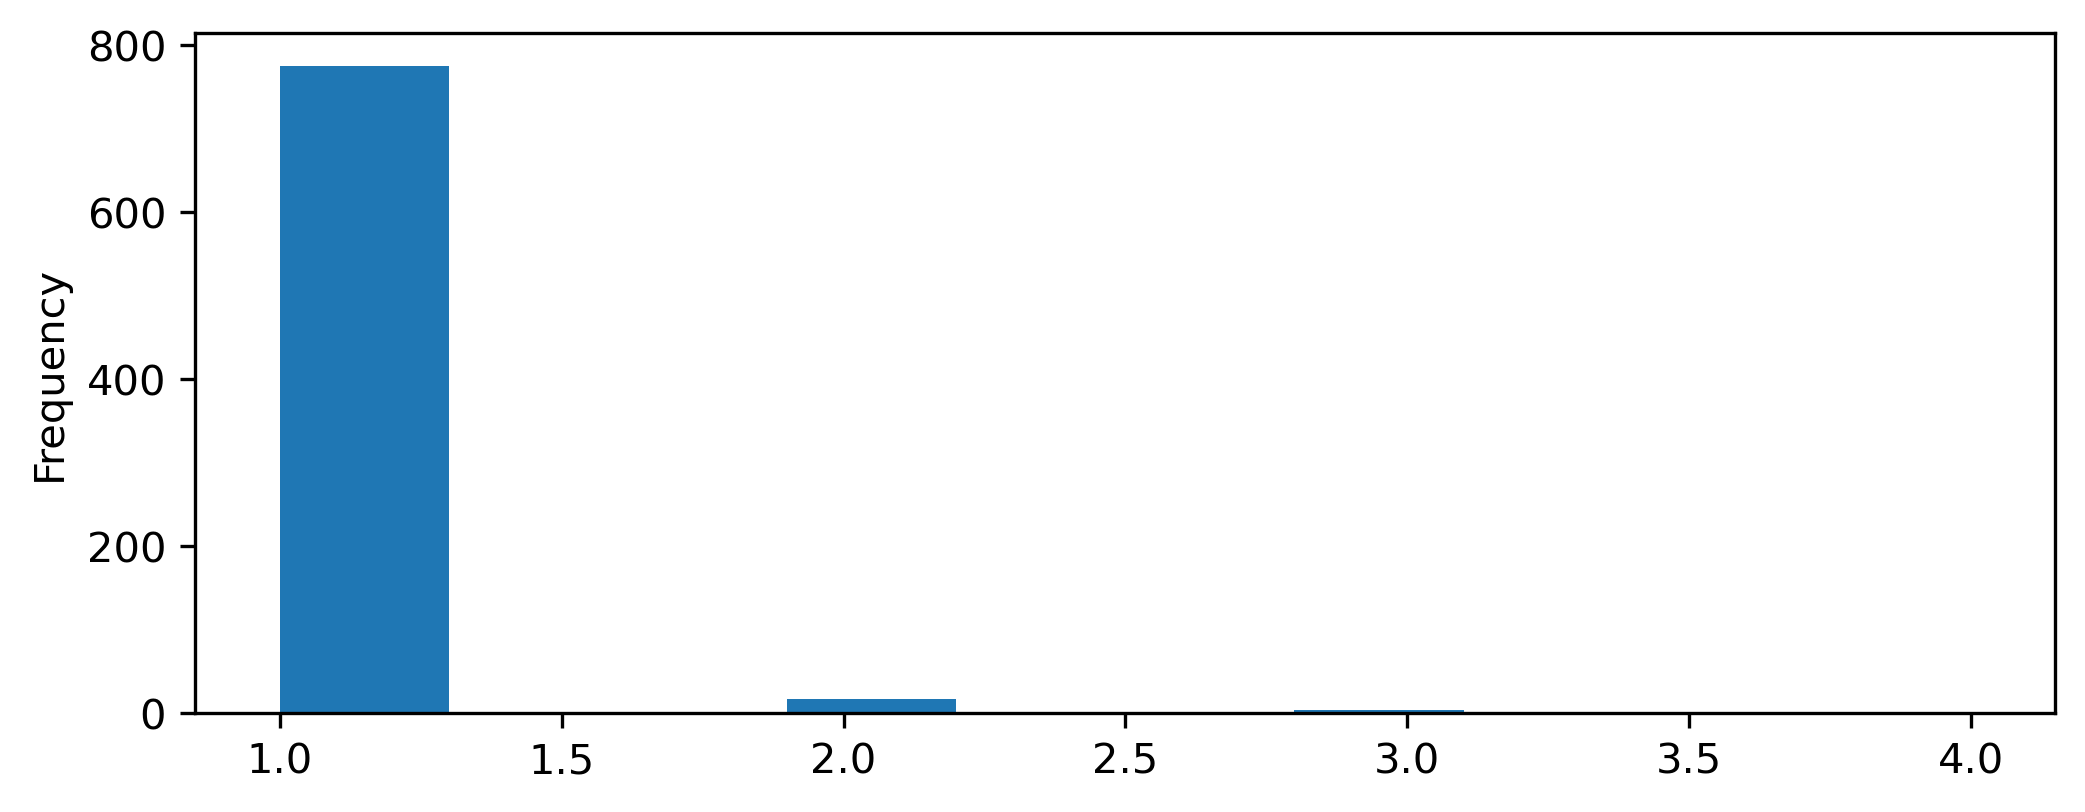

In [232]:
print('Number of unique patients = ',abpain_cohort['PtSSN'].unique().shape)
print('Number of patient visits = ', abpain_cohort.shape)
plt.figure(figsize=(8,3))
abpain_cohort.groupby(['PtSSN'])[('PtSSN')].agg('count').plot(kind='hist')

# Multiple visits are  tricky
- PtSSN zzzzzz
- generally indicate care escalation

In [ ]:
recs = abpain_cohort[abpain_cohort.PtSSN==zzzzzzzzzz].sort_values(by='EDStartDateTime')

display(recs)

for i in range(recs.shape[0]):
    print(i,recs[recs.AdmitDateTime <= recs.iloc[i].EDStartDateTime].shape[0])
    
# time in hours between successive ED visits for those with multiple visits
for i in range(recs.shape[0]-1):
    print(i,recs.iloc[i+1].EDStartDateTime - recs.iloc[i].EDEndDateTime)


# Process demographics
- age, gender, ethnicity, race for each patient

In [234]:
demo_df = dataset['Demorgraphics']

demo_df.rename(columns={'patientSSN':'PtSSN'},inplace=True)
demo_df.PtSSN = demo_df.PtSSN.astype('int32')

abpain_demo = pd.merge(pd.DataFrame(abpain_cohort['PtSSN'].unique(),columns=['PtSSN']),demo_df,on='PtSSN')
abpain_demo['age'] = (abpain_demo['IndexDateTime'] - abpain_demo['DOB'])/np.timedelta64(1,'Y')

def clean_race_values(x):
    if (x=='DECLINED TO ANSWER') | (x=='UNKNOWN BY PATIENT'):
        return 'UNKNOWN'
    if (x=='AMERICAN INDIAN OR ALASKA NATIVE') | (x=='NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'):
        return 'ALASKA/PACIFIC'
    return x

abpain_demo['new_race'] = abpain_demo.Race.apply(lambda x: clean_race_values(x))
print(abpain_demo.shape)

abpain_demo_labeled = pd.merge(abpain_demo,labels_df,on='PtSSN')
print(abpain_demo_labeled.shape)

(795, 9)
(104, 10)


In [ ]:
abpain_demo.head()

In [236]:
abpain_demo.new_race.value_counts()

WHITE                        519
BLACK OR AFRICAN AMERICAN    202
UNKNOWN                       33
ALASKA/PACIFIC                19
ASIAN                          9
Name: new_race, dtype: int64

# Code categorical fields in demo df
- gender and ethnicity are boolean
- new_race has 5 categories (use get_dummies)
- none of age, race, ethnicity are significant in the labeled examples

In [237]:
# code Gender, Ethnicity, new_race using get_dummies
tmp1 = pd.get_dummies(abpain_demo[['new_race']])
tmp2 = pd.DataFrame(abpain_demo['Gender'].apply(lambda x: 1 if x=='M' else 0))
tmp3 = pd.DataFrame(abpain_demo['Ethnicity'].apply(lambda x: 1 if x=='HISPANIC OR LATINO' else 0))
abpain_demo_df = pd.concat([abpain_demo[['PtSSN','age',]],tmp1,tmp2,tmp3],axis=1)
abpain_demo_df_labeled = pd.merge(abpain_demo_df,labels_df,on='PtSSN')
print(abpain_demo_df.shape,abpain_demo_df_labeled.shape)

demo_fields = abpain_demo_df.columns[1:]
ttest_fields(abpain_demo_df_labeled,demo_fields)

(795, 9) (104, 10)
age Ttest_indResult(statistic=-0.26682926258740697, pvalue=0.7901393320205181)
new_race_ALASKA/PACIFIC Ttest_indResult(statistic=0.6254942727738887, pvalue=0.5330437111232542)
new_race_ASIAN Ttest_indResult(statistic=0.6254942727738887, pvalue=0.5330437111232542)
new_race_BLACK OR AFRICAN AMERICAN Ttest_indResult(statistic=-0.7232056815492273, pvalue=0.47120870255026925)
new_race_UNKNOWN Ttest_indResult(statistic=-0.6498273932558098, pvalue=0.5172645382674323)
new_race_WHITE Ttest_indResult(statistic=0.4420006521708172, pvalue=0.6594244579977162)
Gender Ttest_indResult(statistic=0.8924784174495595, pvalue=0.37423726273421776)
Ethnicity Ttest_indResult(statistic=1.7856825162529937, pvalue=0.07712248449172046)


# Process Labs

- labs are by visit date in ER; 
    - WBC
    - BMP (Glucose, Calcium, Sodium, Potassium, CO2, Chloride, BUN, Creatinine) 
    - Urine Analysis
    - Lactate, amylase

In [238]:
labs_df = dataset['Lab']

labs_df.rename(columns={'PatientSSN':'PtSSN','PatientSID':'patientsid'},inplace=True)
labs_df.PtSSN = labs_df.PtSSN.astype('int32')

# restrict labs to abpain cohort
abpain_labs1 = pd.merge(labs_df,abpain_cohort[['PtSSN','EDStartDateTime','EDEndDateTime']],on=['PtSSN'])

# restrict labs to abpain cohort within the ED Start and End Times
abpain_labs2 = abpain_labs1[(abpain_labs1.LabChemSpecimenDateTime >= abpain_labs1.EDStartDateTime) & (abpain_labs1.LabChemSpecimenDateTime <= abpain_labs1.EDEndDateTime)].copy()

abpain_labs2.shape

(43877, 14)

In [239]:
abpain_labs2.columns

Index(['PtSSN', 'LabChemSpecimenDateTime', 'LabChemResultValue',
       'LabChemResultNumericValue', 'Abnormal', 'LabChemTestName',
       'RequestLocation', 'LOINC', 'LabChemSID', 'Sta3n', 'LabChemTestSID',
       'patientsid', 'EDStartDateTime', 'EDEndDateTime'],
      dtype='object')

Total count =  815
(815, 5) (114, 6) 795


<AxesSubplot:ylabel='Frequency'>

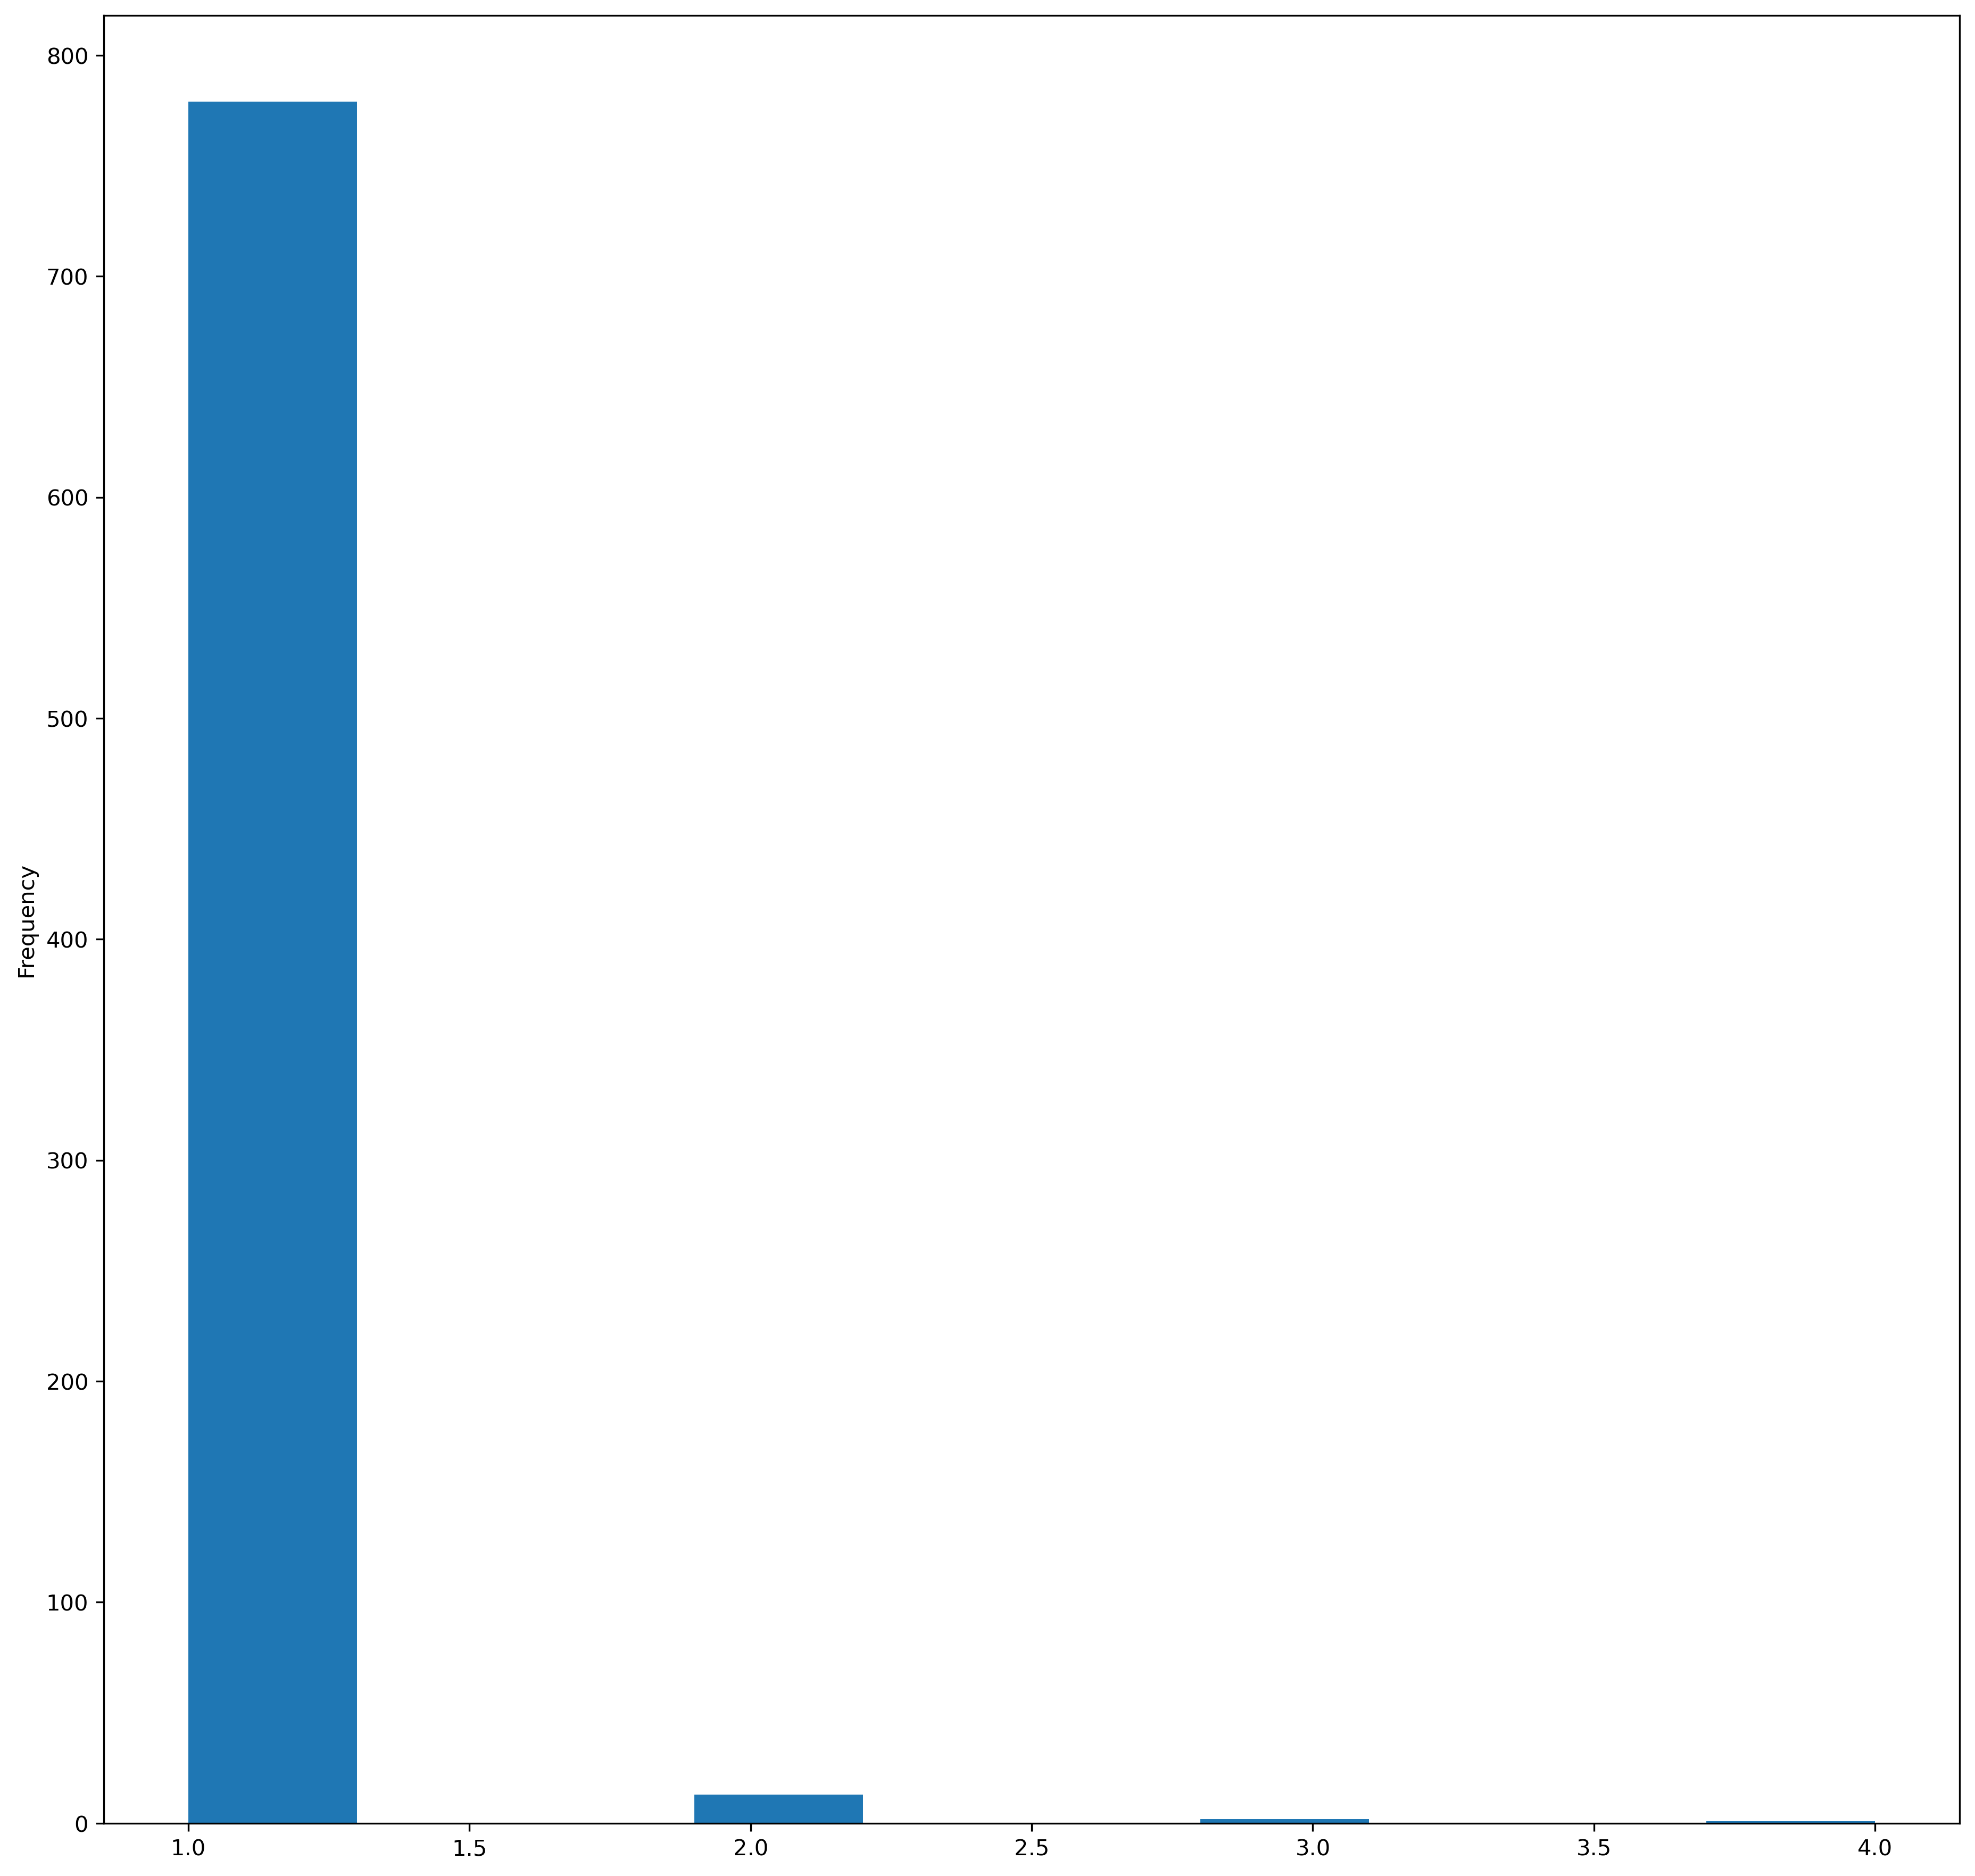

In [240]:
wbc_df = lab_values_loinc(matches_WBC_loinc,abpain_cohort,abpain_labs2)
wbc_df_labeled = pd.merge(wbc_df,labels_df,on='PtSSN')
print(wbc_df.shape, wbc_df_labeled.shape, len(wbc_df.PtSSN.unique()))
wbc_df.groupby('PtSSN')['PtSSN'].agg('count').plot(kind='hist')

(array([ 1.,  5.,  3., 25., 26., 33., 47., 33., 49., 57., 43., 50., 46.,
        55., 27., 44., 23., 27., 21., 23., 19., 18.,  9., 15.,  4.,  3.,
         5.,  1.,  4.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 1.93  ,  2.5474,  3.1648,  3.7822,  4.3996,  5.017 ,  5.6344,
         6.2518,  6.8692,  7.4866,  8.104 ,  8.7214,  9.3388,  9.9562,
        10.5736, 11.191 , 11.8084, 12.4258, 13.0432, 13.6606, 14.278 ,
        14.8954, 15.5128, 16.1302, 16.7476, 17.365 , 17.9824, 18.5998,
        19.2172, 19.8346, 20.452 , 21.0694, 21.6868, 22.3042, 22.9216,
        23.539 , 24.1564, 24.7738, 25.3912, 26.0086, 26.626 , 27.2434,
        27.8608, 28.4782, 29.0956, 29.713 , 30.3304, 30.9478, 31.5652,
        32.1826, 32.8   ]),
 <BarContainer object of 50 artists>)

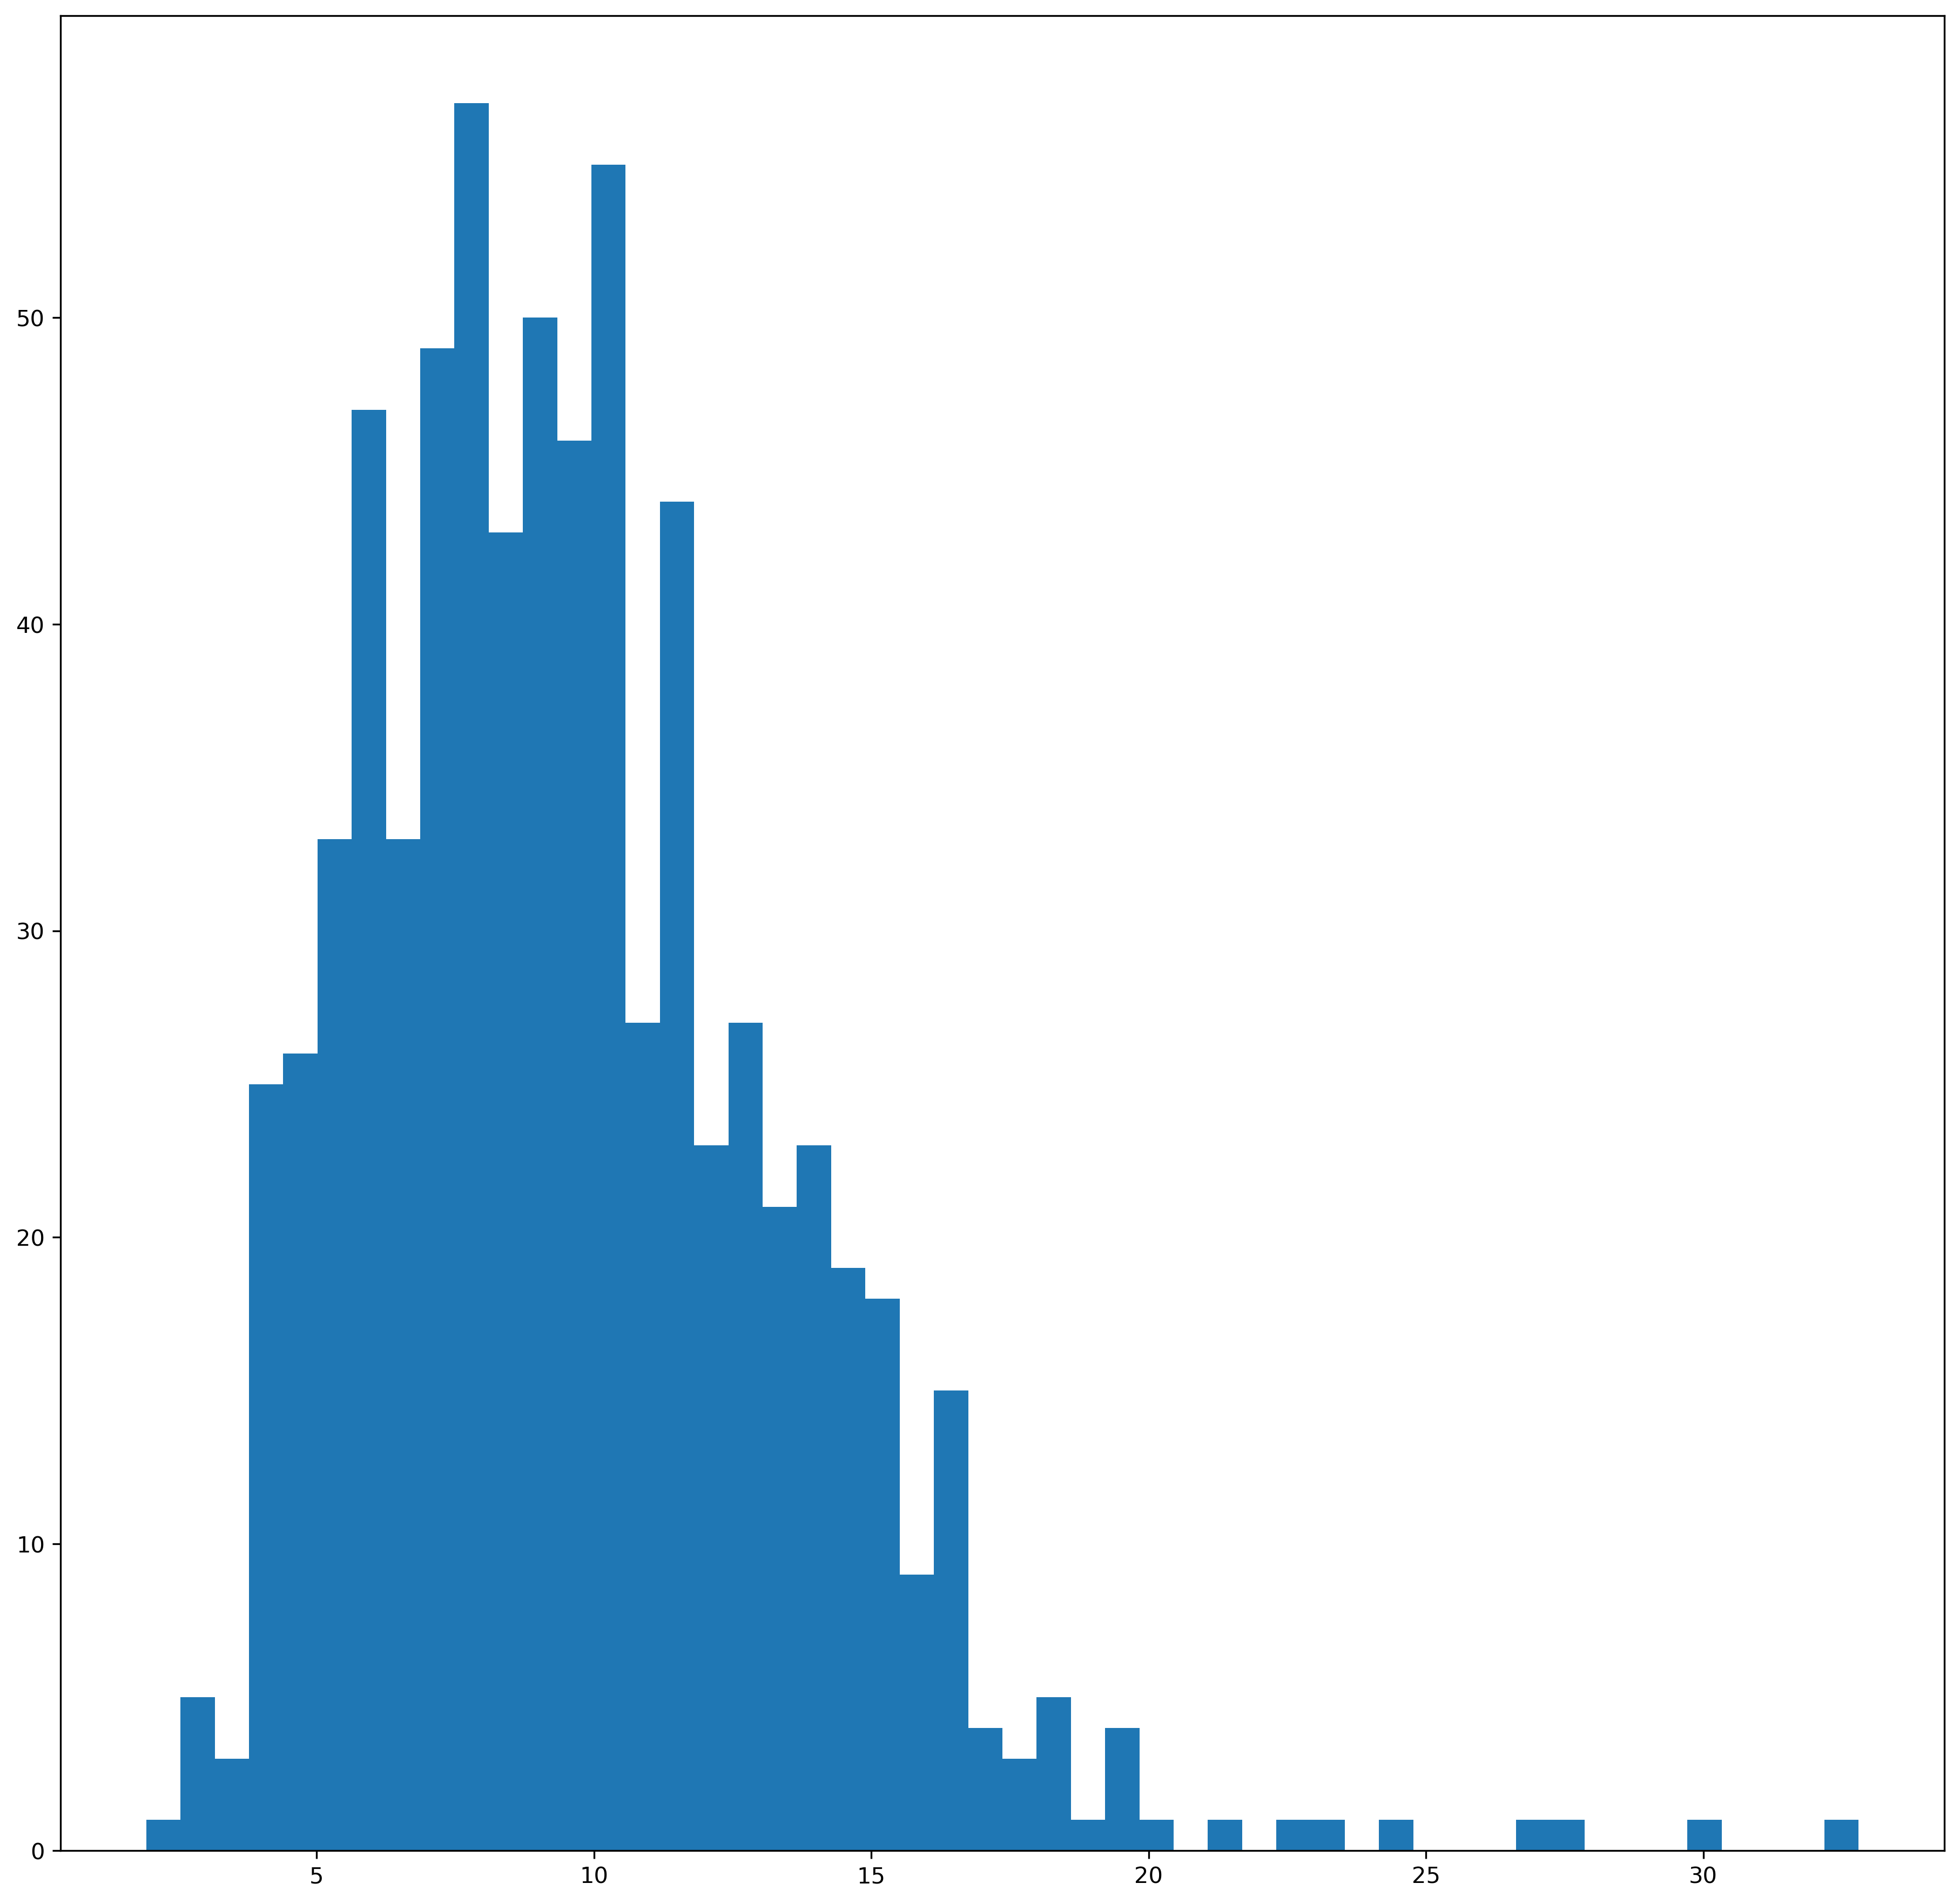

In [241]:
plt.hist(wbc_df.max_value,bins=50)

In [ ]:
# which patients have no lab values at any of their visits? Impute the values based on median value of all 795 people

def impute_lab_values(wbc_df,abpain_demo):
    median_val_max = wbc_df.max_value.describe()['50%']
    median_val_min = wbc_df.min_value.describe()['50%']


    wbc_df_imputed = wbc_df.copy()
    for PtSSN in abpain_demo_df.PtSSN:
        recs = wbc_df_imputed[wbc_df_imputed.PtSSN==PtSSN]
        missing = recs[(recs.max_value.isna()) & (recs.min_value.isna())]
        if missing.shape[0] > 0:
       
            # fill in median values for each visit
            for i in range(missing.shape[0]):
                wbc_df_imputed.loc[missing.index[i],'max_value'] = median_val_max
                wbc_df_imputed.loc[missing.index[i],'min_value'] = median_val_min
                wbc_df_imputed.loc[missing.index[i],'abnormal'] = None
    return wbc_df_imputed
       


In [243]:
wbc_df_imputed = impute_lab_values(wbc_df,abpain_demo)
wbc_df_imputed_labeled = pd.merge(wbc_df_imputed,labels_df,on='PtSSN')

In [244]:
albumin_df = lab_values(matches_albumin,abpain_cohort,abpain_labs2)
print(albumin_df.shape)
albumin_df_labeled = pd.merge(albumin_df,labels_df,on='PtSSN')
albumin_df_imputed = impute_lab_values(albumin_df,abpain_demo)

Total count =  814
(814, 5)


In [ ]:
albumin_df_imputed.head()

In [246]:
display(albumin_df_labeled.groupby('label')['max_value'].describe())
albumin_df_labeled.max_value.isna().sum()

count      mean       std  min    25%  50%    75%  max
label                                                        
MOD     23.0  3.856522  0.721001  2.5  3.500  4.0  4.400  4.9
NoMOD   66.0  3.913636  0.625825  1.6  3.525  4.0  4.275  5.4

25

In [247]:
glucose_df = lab_values(matches_glucose,abpain_cohort,abpain_labs2)
sodium_df = lab_values_loinc(matches_sodium_loinc,abpain_cohort,abpain_labs2)
albumin_df = lab_values(matches_albumin,abpain_cohort,abpain_labs2)
potassium_df = lab_values(matches_potassium,abpain_cohort,abpain_labs2)
calcium_df = lab_values_loinc(matches_calcium_loinc,abpain_cohort,abpain_labs2)
lactate_df = lab_values_loinc(matches_lact_loinc,abpain_cohort,abpain_labs2)
chloride_df = lab_values(matches_chloride,abpain_cohort,abpain_labs2)
bun_df = lab_values(matches_bun,abpain_cohort,abpain_labs2)
creat_df = lab_values_loinc(matches_creat_loinc,abpain_cohort,abpain_labs2)
troponin_df = lab_values(matches_troponin,abpain_cohort,abpain_labs2)
co2_df = lab_values(matches_CO2,abpain_cohort,abpain_labs2)
ast_df = lab_values(matches_ast,abpain_cohort,abpain_labs2)
alt_df = lab_values(matches_alt,abpain_cohort,abpain_labs2)
alkphos_df = lab_values(matches_alkphos,abpain_cohort,abpain_labs2)
lipase_df = lab_values(matches_lipase,abpain_cohort,abpain_labs2)
amylase_df = lab_values(matches_amylase,abpain_cohort,abpain_labs2)
urine_df = lab_values(matches_urine,abpain_cohort,abpain_labs2)

Total count =  816
Total count =  815
Total count =  814
Total count =  815
Total count =  814
Total count =  813
Total count =  815
Total count =  817
Total count =  815
Total count =  816
Total count =  818
Total count =  816
Total count =  815
Total count =  813
Total count =  813
Total count =  813
Total count =  807


In [248]:
glucose_df_labeled = pd.merge(glucose_df,labels_df,on='PtSSN')
sodium_df_labeled = pd.merge(sodium_df,labels_df,on='PtSSN')
albumin_df_labeled = pd.merge(albumin_df,labels_df,on='PtSSN')
potassium_df_labeled = pd.merge(potassium_df,labels_df,on='PtSSN')
calcium_df_labeled = pd.merge(calcium_df,labels_df,on='PtSSN')
lactate_df_labeled = pd.merge(lactate_df,labels_df,on='PtSSN')
chloride_df_labeled = pd.merge(chloride_df,labels_df,on='PtSSN')
bun_df_labeled = pd.merge(bun_df,labels_df,on='PtSSN')
creat_df_labeled = pd.merge(creat_df,labels_df,on='PtSSN')
troponin_df_labeled = pd.merge(troponin_df,labels_df,on='PtSSN')
co2_df_labeled = pd.merge(co2_df,labels_df,on='PtSSN')
ast_df_labeled = pd.merge(ast_df,labels_df,on='PtSSN')
alt_df_labeled = pd.merge(alt_df,labels_df,on='PtSSN')
alkphos_df_labeled = pd.merge(alkphos_df,labels_df,on='PtSSN')
lipase_df_labeled = pd.merge(lipase_df,labels_df,on='PtSSN')
amylase_df_labeled = pd.merge(amylase_df,labels_df,on='PtSSN')
urine_df_labeled = pd.merge(urine_df,labels_df,on='PtSSN')

In [249]:
glucose_df_imputed = impute_lab_values(glucose_df,abpain_demo)
sodium_df_imputed = impute_lab_values(sodium_df,abpain_demo)
albumin_df_imputed = impute_lab_values(albumin_df,abpain_demo)
potassium_df_imputed = impute_lab_values(potassium_df,abpain_demo)
calcium_df_imputed = impute_lab_values(calcium_df,abpain_demo)
lactate_df_imputed = impute_lab_values(lactate_df,abpain_demo)
chloride_df_imputed = impute_lab_values(chloride_df,abpain_demo)
bun_df_imputed = impute_lab_values(bun_df,abpain_demo)
creat_df_imputed = impute_lab_values(creat_df,abpain_demo)
troponin_df_imputed = impute_lab_values(troponin_df,abpain_demo)
co2_df_imputed = impute_lab_values(co2_df,abpain_demo)
ast_df_imputed = impute_lab_values(ast_df,abpain_demo)
alt_df_imputed = impute_lab_values(alt_df,abpain_demo)
alkphos_df_imputed = impute_lab_values(alkphos_df,abpain_demo)
lipase_df_imputed = impute_lab_values(lipase_df,abpain_demo)
amylase_df_imputed = impute_lab_values(amylase_df,abpain_demo)
urine_df_imputed = impute_lab_values(urine_df,abpain_demo)

In [250]:
glucose_df_imputed_labeled = pd.merge(glucose_df_imputed,labels_df,on='PtSSN')
sodium_df_imputed_labeled = pd.merge(sodium_df_imputed,labels_df,on='PtSSN')
albumin_df_imputed_labeled = pd.merge(albumin_df_imputed,labels_df,on='PtSSN')
potassium_df_imputed_labeled = pd.merge(potassium_df_imputed,labels_df,on='PtSSN')
calcium_df_imputed_labeled = pd.merge(calcium_df_imputed,labels_df,on='PtSSN')
lactate_df_imputed_labeled = pd.merge(lactate_df_imputed,labels_df,on='PtSSN')
chloride_df_imputed_labeled = pd.merge(chloride_df_imputed,labels_df,on='PtSSN')
bun_df_imputed_labeled = pd.merge(bun_df_imputed,labels_df,on='PtSSN')
creat_df_imputed_labeled = pd.merge(creat_df_imputed,labels_df,on='PtSSN')
troponin_df_imputed_labeled = pd.merge(troponin_df_imputed,labels_df,on='PtSSN')
co2_df_imputed_labeled = pd.merge(co2_df_imputed,labels_df,on='PtSSN')
ast_df_imputed_labeled = pd.merge(ast_df_imputed,labels_df,on='PtSSN')
alt_df_imputed_labeled = pd.merge(alt_df_imputed,labels_df,on='PtSSN')
alkphos_df_imputed_labeled = pd.merge(alkphos_df_imputed,labels_df,on='PtSSN')
lipase_df_imputed_labeled = pd.merge(lipase_df_imputed,labels_df,on='PtSSN')
amylase_df_imputed_labeled = pd.merge(amylase_df_imputed,labels_df,on='PtSSN')
urine_df_imputed_labeled = pd.merge(urine_df_imputed,labels_df,on='PtSSN')

<AxesSubplot:>

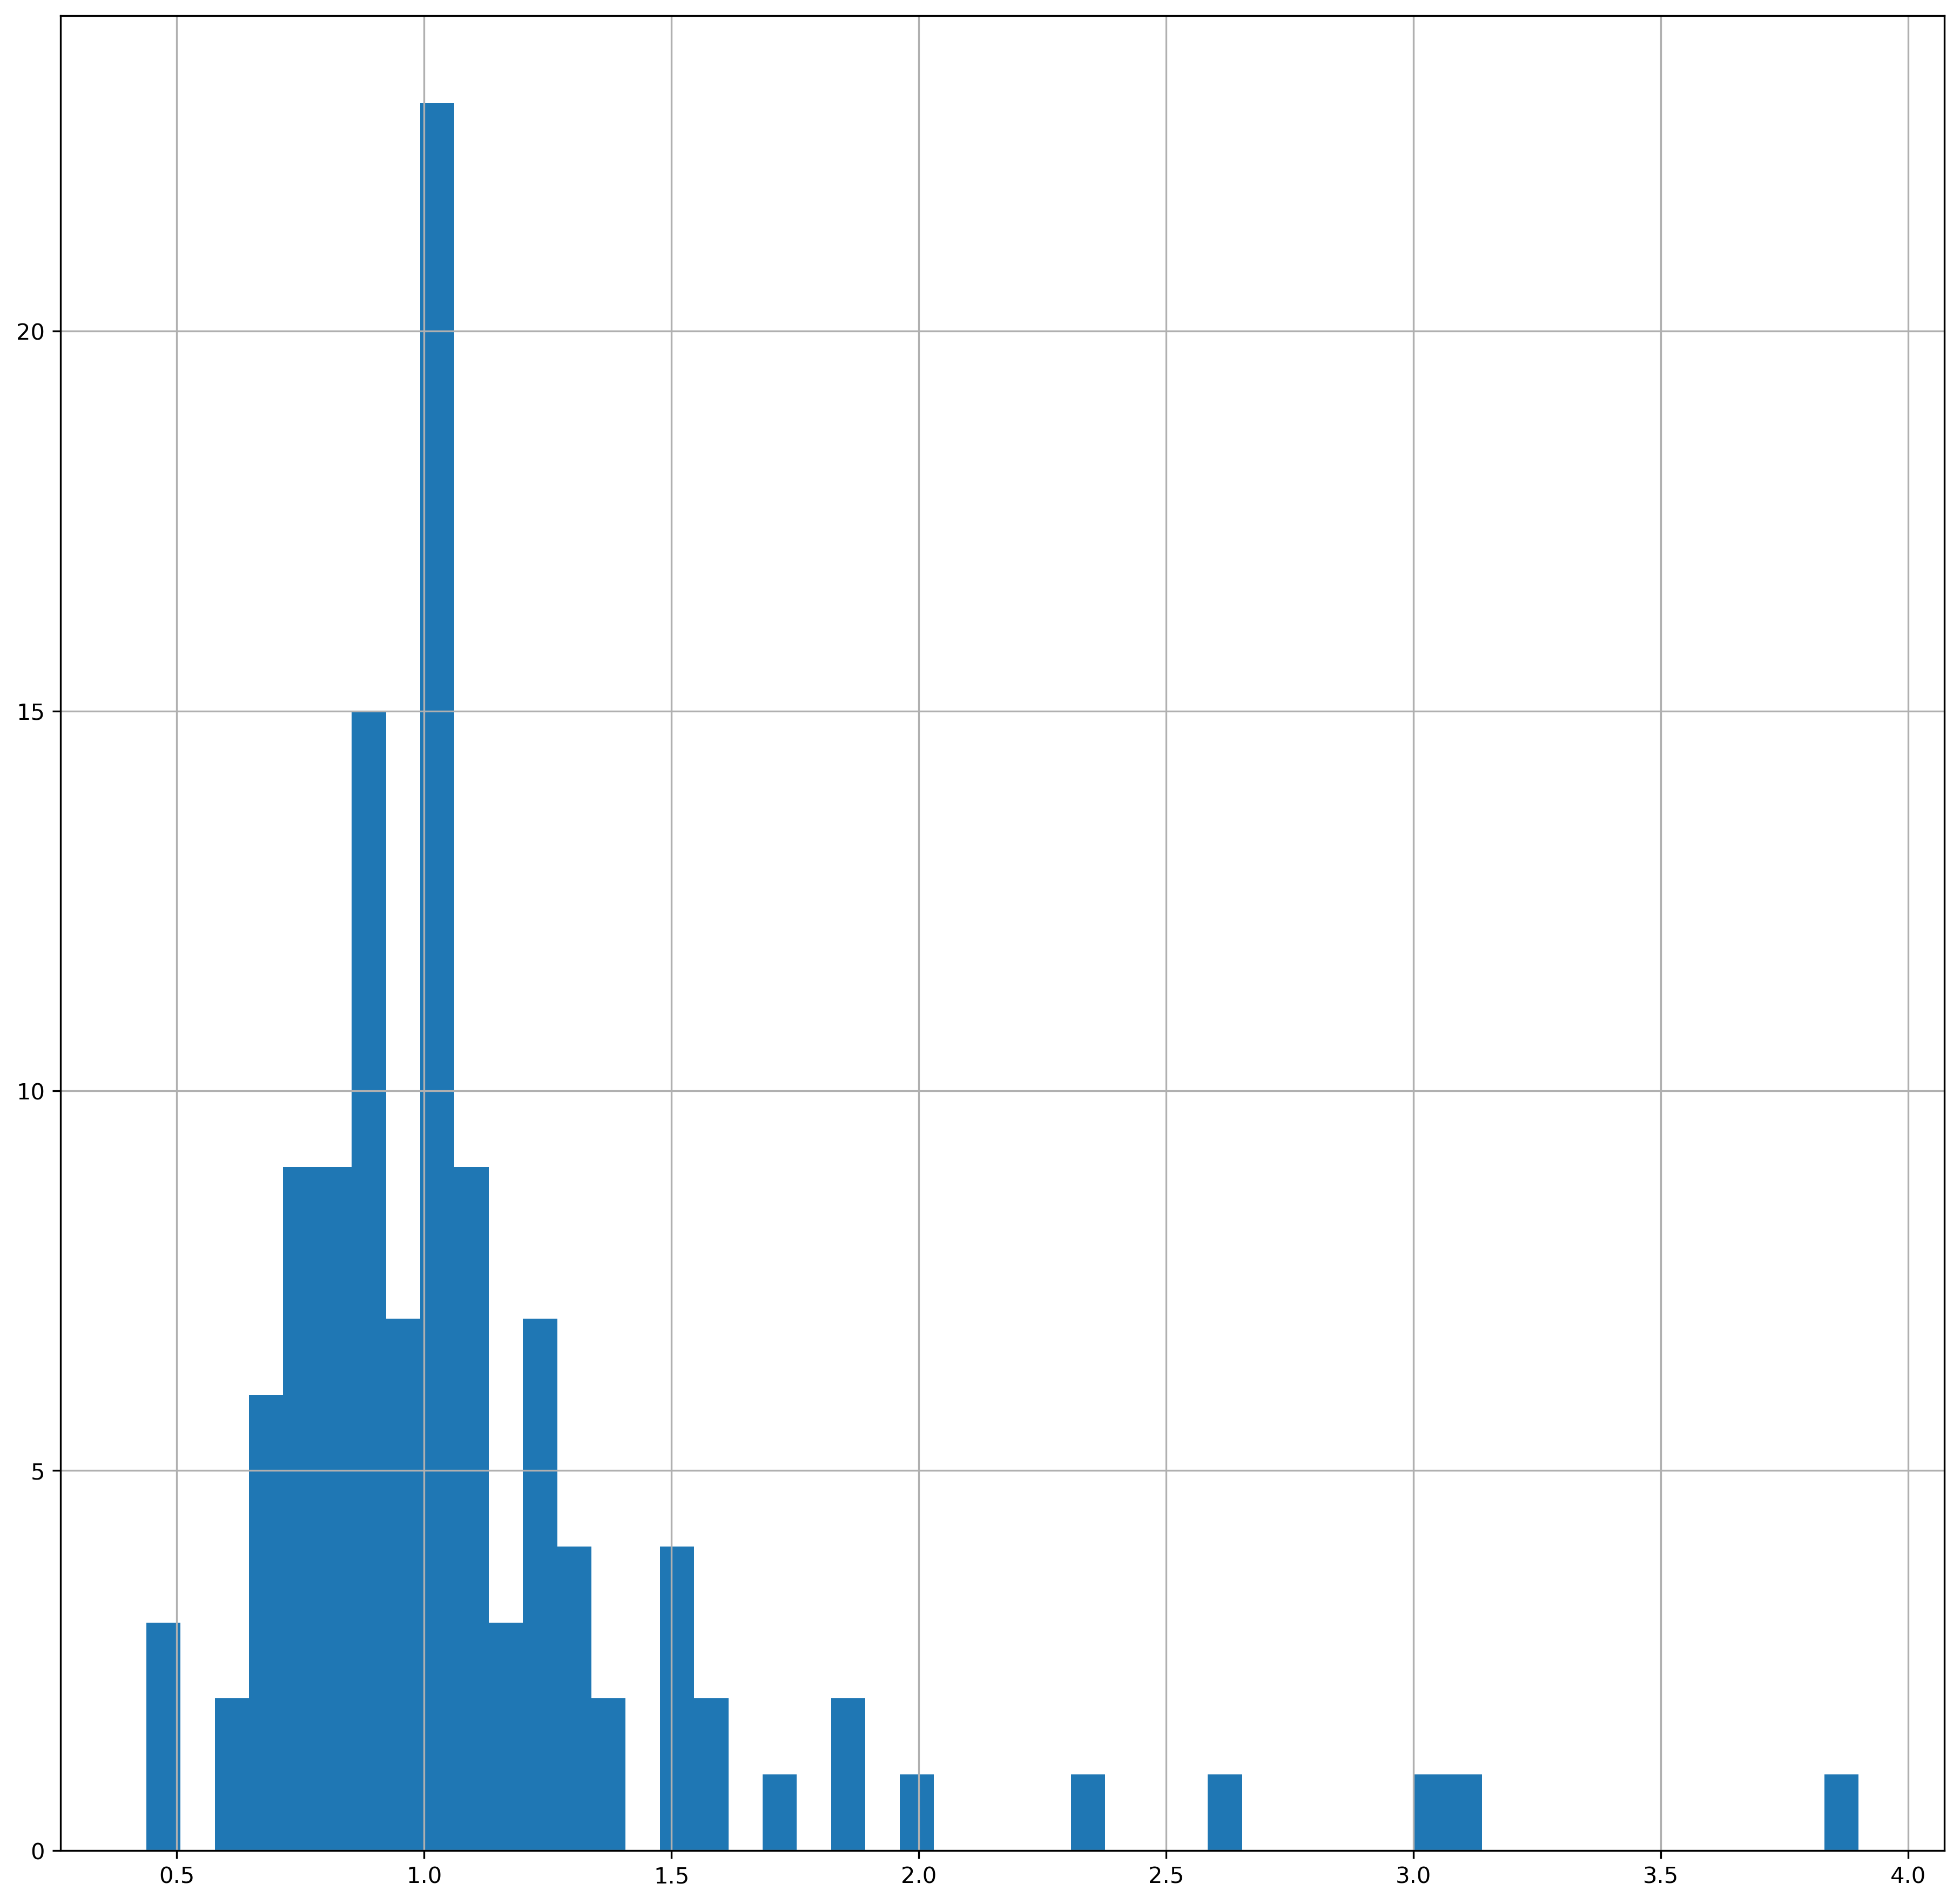

In [251]:
# check creatinine levels and eliminate urine derived creatinine
creat_df_imputed_labeled.max_value.hist(bins=50)

In [252]:
labnames = ['wbc','glucose','sodium','potassium','calcium','lactate','chloride','bun','creat','troponin',
           'co2','ast','alt','alkphos','lipase','amylase','urine','albumin']
for lab in labnames:
    print(ttest_lab(eval(lab+'_df_imputed_labeled'),lab))

('wbc', 0.2506632082542452)
('glucose', 0.36504773085476894)
('sodium', 0.016596413998747183)
('potassium', 0.15576232562143796)
('calcium', 0.9189252292951179)
('lactate', 0.5536025650977175)
('chloride', 0.05195889313007336)
('bun', 0.5688829381532181)
('creat', 0.5431975558520693)
('troponin', 0.041622633922901386)
('co2', 0.5292911045735618)
('ast', 0.27798575580437207)
('alt', 0.4571493910622284)
('alkphos', 0.9293074741334906)
('lipase', 0.6703437941162087)
('amylase', 0.01663484283901458)
('urine', 0.4569800046379441)
('albumin', 0.8501993115551124)


In [253]:
# how many non NA troponin?
troponin_df_imputed_labeled.max_value.isna().sum()

0

# Diagnosis at ED

In [254]:
icd_df = dataset['ICD']
icd_df.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
icd_df.PtSSN = icd_df.PtSSN.astype('int32')

# restrict to patients in abpain_cohort visit# restrict labs to abpain cohort
abpain_icd1 = pd.merge(icd_df,abpain_cohort[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')

# restrict to abpain cohort within the ED Start and End Times
abpain_icd2 = abpain_icd1[(abpain_icd1.DiagDateTime >= abpain_icd1.EDStartDateTime) & (abpain_icd1.DiagDateTime <= abpain_icd1.EDEndDateTime)]

# restrict to PrincipalDiagnosis
abpain_icd3 = abpain_icd2[abpain_icd2.IsPrincipalDiag==1].copy()
abpain_icd3_labeled = pd.merge(abpain_icd3,labels_df,on='PtSSN')
print(abpain_icd3.shape, abpain_icd3_labeled.shape)
print(abpain_icd3.ICD.value_counts().shape)
print(abpain_icd3_labeled.ICD.value_counts().shape)


(1678, 7) (220, 8)
(253,)
(55,)


In [ ]:
abpain_icd3.head()

In [256]:
abpain_icd3_labeled.ICDDiagnosis.value_counts()

Unspecified abdominal pain                                      48
Generalized abdominal pain                                      22
Epigastric pain                                                 19
Encntr for obs for oth suspected diseases and cond ruled out    14
Lower abdominal pain, unspecified                               13
Upper abdominal pain, unspecified                               12
Encounter for screening for cardiovascular disorders             9
Nausea with vomiting, unspecified                                8
Fever, unspecified                                               8
Left lower quadrant pain                                         4
Tachycardia, unspecified                                         3
Oth symptoms and signs involving the circ and resp systems       3
Illness, unspecified                                             3
Right lower quadrant pain                                        3
Other nonspecific abnormal finding of lung field              

# Analysis of differences between MOD and NoMOD cohort in principal ED diagnosis

In [257]:
mod_icds = abpain_icd3_labeled[abpain_icd3_labeled.label=='MOD'].groupby('ICDDiagnosis')['ICD'].agg('count').reset_index()
mod_icds.columns = ['ICDDiagnosis','icd_count']
mod_icds = mod_icds.sort_values(by='icd_count',ascending=False)

nomod_icds = abpain_icd3_labeled[abpain_icd3_labeled.label=='NoMOD'].groupby('ICDDiagnosis')['ICD'].agg('count').reset_index()
nomod_icds.columns = ['ICDDiagnosis','icd_count']
nomod_icds = nomod_icds.sort_values(by='icd_count',ascending=False)

display(mod_icds)
display(nomod_icds)
mod_icds.to_csv('mod_icds.csv')
nomod_icds.to_csv('nomod_icds.csv')

# which ICDs are exclusively in MOD but not in NoMOD
diff_icds = list(set(mod_icds.ICDDiagnosis).difference(set(nomod_icds.ICDDiagnosis)))


only_mods = abpain_icd3_labeled[abpain_icd3_labeled.ICDDiagnosis.isin(diff_icds)].groupby('ICDDiagnosis')['ICD'].agg('count').reset_index().sort_values(by='ICD',ascending=False)
only_mods.to_csv('only_mods.csv')

ICDDiagnosis  icd_count
22                                    Unspecified abdominal pain         15
10                                    Generalized abdominal pain          8
8                                             Fever, unspecified          7
14                             Nausea with vomiting, unspecified          6
3   Encntr for obs for oth suspected diseases and cond ruled out          4
24                             Upper abdominal pain, unspecified          3
7                                                Epigastric pain          3
12                                      Left lower quadrant pain          3
20                                     Right lower quadrant pain          3
19                                                  Palpitations          2
5           Encounter for screening for cardiovascular disorders          2
17              Other nonspecific abnormal finding of lung field          2
21                                      Tachycardia, unspecified          2
11      Hepatomegaly with splenomegaly, not elsewhere classified          2
0                                 Acute pharyngitis, unspecified          1
23      Unspecified complication of procedure, initial encounter          1
18                          Other specified diseases of pancreas          1
13                             Lower abdominal pain, unspecified          1
16                                                 Other malaise          1
15    Oth symptoms and signs involving the circ and resp systems          1
1                                                          Cough          1
9              Gastro-esophageal reflux disease with esophagitis          1
6               Encounter for screening for other viral diseases          1
4   Encntr for surgical aftcr following surgery on the dgstv sys          1
2     Dvrtclos of lg int w/o perforation or abscess w/o bleeding          1
25                   Urinary tract infection, site not specified          1

ICDDiagnosis  icd_count
39                                    Unspecified abdominal pain         33
20                                               Epigastric pain         16
22                                    Generalized abdominal pain         14
27                             Lower abdominal pain, unspecified         12
15  Encntr for obs for oth suspected diseases and cond ruled out         10
42                             Upper abdominal pain, unspecified          9
17          Encounter for screening for cardiovascular disorders          7
12                                         Diarrhea, unspecified          3
24                                          Illness, unspecified          3
38                   Type 2 diabetes mellitus with hyperglycemia          2
31    Oth symptoms and signs involving the circ and resp systems          2
7                                        Chest pain, unspecified          2
35     Problem related to unspecified psychosocial circumstances          2
28                             Nausea with vomiting, unspecified          2
29                                      Obstruction of bile duct          1
26                                      Left lower quadrant pain          1
41                                    Unspecified hydronephrosis          1
40                               Unspecified atrial fibrillation          1
36                               Retention of urine, unspecified          1
37                                      Tachycardia, unspecified          1
32                      Other cholelithiasis without obstruction          1
25           Infectious gastroenteritis and colitis, unspecified          1
33              Other nonspecific abnormal finding of lung field          1
34                                 Other specified health status          1
30            Oth problems related to psychosocial circumstances          1
0                     Abnormal results of liver function studies          1
23                                    Heart failure, unspecified          1
9                                                          Cough          1
2                                       Bradycardia, unspecified          1
3     Calculus of GB and bile duct w/o cholecyst w/o obstruction          1
4    Calculus of bile duct w/o cholangitis or cholecyst w/o obst          1
5      Calculus of gallbladder w/o cholecystitis w/o obstruction          1
6                                                   Cardiomegaly          1
8                                      Constipation, unspecified          1
10                                       Counseling, unspecified          1
1                           Atrioventricular block, first degree          1
11    Crohn's disease of small intestine with other complication          1
13                                   Duodenitis without bleeding          1
14     Dvtrcli of lg int w/o perforation or abscess w/o bleeding          1
16               Encounter for other administrative examinations          1
18               Encounter for therapeutic drug level monitoring          1
19                             Enlarged lymph nodes, unspecified          1
21                                            Fever, unspecified          1

In [258]:
only_mods

ICDDiagnosis  ICD
9                                      Right lower quadrant pain    3
5       Hepatomegaly with splenomegaly, not elsewhere classified    2
8                                                   Palpitations    2
0                                 Acute pharyngitis, unspecified    1
1     Dvrtclos of lg int w/o perforation or abscess w/o bleeding    1
2   Encntr for surgical aftcr following surgery on the dgstv sys    1
3               Encounter for screening for other viral diseases    1
4              Gastro-esophageal reflux disease with esophagitis    1
6                                                  Other malaise    1
7                           Other specified diseases of pancreas    1
10      Unspecified complication of procedure, initial encounter    1
11                   Urinary tract infection, site not specified    1

In [259]:
# commented out by Adel
# abpain_cohort1_labeled = pd.merge(abpain_cohort1,labels_df,on='PtSSN')

In [260]:
# group ICDs based on type
relevant_ICDs = ['Unspecified abdominal pain', 'Fever, unspecified',
       'Nausea with vomiting, unspecified', 'Generalized abdominal pain',
       'Right lower quadrant pain', 'Epigastric pain',
       'Upper abdominal pain, unspecified','Lower abdominal pain, unspecified',
       ]

# merge counts of unspecified abdominal pain and generalized abdominal pain
# count up presence/absence of these discharge codes on a per visit basis

c = 0
icd_dx_labeled = {}
for PtSSN in abpain_cohort_labeled.PtSSN.unique():
    recs = abpain_icd3_labeled[abpain_icd3_labeled.PtSSN==PtSSN]
    diags = recs.ICDDiagnosis
    tmp_vc = pd.merge(diags,pd.DataFrame(relevant_ICDs,columns=['ICDDiagnosis']),on='ICDDiagnosis').ICDDiagnosis.value_counts()
    icd_dx_labeled[c] = {'PtSSN':PtSSN}
    for icd in relevant_ICDs:
        if icd in tmp_vc:
            icd_dx_labeled[c][icd] = tmp_vc[icd]
        else:
            icd_dx_labeled[c][icd] = 0
    c = c + 1
icd_dx_labeled_df = pd.DataFrame.from_dict(icd_dx_labeled,orient='index')
icd_dx_labeled_df = pd.merge(icd_dx_labeled_df,labels_df,on='PtSSN')

In [261]:
for field in icd_dx_labeled_df.columns[1:-1]:
    print(field,scipy.stats.ttest_ind(icd_dx_labeled_df[icd_dx_labeled_df.label=='MOD'][field],
                      icd_dx_labeled_df[icd_dx_labeled_df.label=='NoMOD'][field] ))

Unspecified abdominal pain Ttest_indResult(statistic=0.21674550969542042, pvalue=0.8288396008936832)
Fever, unspecified Ttest_indResult(statistic=1.656143425308484, pvalue=0.10076611027823532)
Nausea with vomiting, unspecified Ttest_indResult(statistic=1.512488056455474, pvalue=0.13350201192681152)
Generalized abdominal pain Ttest_indResult(statistic=0.6214367846937814, pvalue=0.5356986836781398)
Right lower quadrant pain Ttest_indResult(statistic=1.5448425361629774, pvalue=0.12548138176666324)
Epigastric pain Ttest_indResult(statistic=-0.7761403184271659, pvalue=0.4394621247734525)
Upper abdominal pain, unspecified Ttest_indResult(statistic=-0.38365215899944705, pvalue=0.7020347939269052)
Lower abdominal pain, unspecified Ttest_indResult(statistic=-1.2450435643475524, pvalue=0.21596857224966104)


In [262]:
# # count up presence/absence of these discharge codes on a per visit basis
# c = 0
# icd_dx_labeled = {}
# for PtSSN in abpain_cohort1_labeled.PtSSN.unique():
#     recs = abpain_icd3_labeled[abpain_icd3_labeled.PtSSN==PtSSN]
#     diags = recs.ICDDiagnosis
#     tmp_vc = pd.merge(diags,dx_codes_df,on='ICDDiagnosis').ICDDiagnosis.value_counts()
#     icd_dx_labeled[c] = {'PtSSN':PtSSN}
#     for icd in dx_codes_df.ICDDiagnosis:
#         if icd in tmp_vc:
#             icd_dx_labeled[c][icd] = tmp_vc[icd]
#         else:
#             icd_dx_labeled[c][icd] = 0
#     c = c + 1
# icd_dx_labeled_df = pd.DataFrame.from_dict(icd_dx_labeled,orient='index')

In [263]:
# c = 0
# icd_dx = {}
# for PtSSN in abpain_cohort1.PtSSN.unique():
#     recs = abpain_icd3[abpain_icd3.PtSSN==PtSSN]
#     diags = recs.ICDDiagnosis
#     tmp_vc = pd.merge(diags,dx_codes_df,on='ICDDiagnosis').ICDDiagnosis.value_counts()
#     icd_dx[c] = {'PtSSN':PtSSN}
#     for icd in dx_codes_df.ICDDiagnosis:
#         if icd in tmp_vc:
#             icd_dx[c][icd] = tmp_vc[icd]
#         else:
#             icd_dx[c][icd] = 0
#     c = c + 1
# icd_dx_df = pd.DataFrame.from_dict(icd_dx,orient='index')
# icd_dx_labeled_df = pd.merge(icd_dx_df,labels_df,on=['PtSSN'])

In [264]:
# icd_dx_df.head()

In [265]:
# how frequent are these in the general trigger positive set?
abpain_icd3[abpain_icd3.ICDDiagnosis.isin(diff_icds)].groupby('ICDDiagnosis')['ICD'].agg('count').reset_index().sort_values(by='ICD',ascending=False)

ICDDiagnosis  ICD
11                   Urinary tract infection, site not specified   20
9                                      Right lower quadrant pain   11
6                                                  Other malaise    6
3               Encounter for screening for other viral diseases    5
4              Gastro-esophageal reflux disease with esophagitis    2
5       Hepatomegaly with splenomegaly, not elsewhere classified    2
8                                                   Palpitations    2
0                                 Acute pharyngitis, unspecified    1
1     Dvrtclos of lg int w/o perforation or abscess w/o bleeding    1
2   Encntr for surgical aftcr following surgery on the dgstv sys    1
7                           Other specified diseases of pancreas    1
10      Unspecified complication of procedure, initial encounter    1

In [266]:
abpain_icd3.groupby('ICDDiagnosis')['ICD'].agg('count').reset_index().sort_values(by='ICD',ascending=False)

ICDDiagnosis  ICD
236                                  Unspecified abdominal pain  317
245                           Upper abdominal pain, unspecified  145
110                                  Generalized abdominal pain  116
144                           Lower abdominal pain, unspecified  104
100                                             Epigastric pain   82
..                                                          ...  ...
114                                  Heart disease, unspecified    1
115                                  Heart failure, unspecified    1
116  Helicobacter pylori as the cause of diseases classd elswhr    1
118                               Hemorrhage of anus and rectum    1
254                                                    Weakness    1

[255 rows x 2 columns]

In [267]:
# aggregate by number of ICDs at discharge and check if there is difference bwteen mod and nomod
# no difference in number of ICDs between MOD and NoMOD
num_icds_labeled = pd.merge(abpain_icd3.groupby('PtSSN')['ICD'].agg('count').reset_index(),labels_df,on='PtSSN')
num_icds_labeled.groupby('label').describe()
scipy.stats.ttest_ind(num_icds_labeled[num_icds_labeled.label=='MOD'].ICD,
                     num_icds_labeled[num_icds_labeled.label=='NoMOD'].ICD)

Ttest_indResult(statistic=1.0339473618149435, pvalue=0.30363014066181715)

# Get vitals data for abpain cohort

In [268]:
vitals = dataset['Vital']
vitals.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
vitals.PtSSN = vitals.PtSSN.astype('int32')
# restrict vitals to abpain cohort
abpain_vitals1 = pd.merge(vitals,abpain_cohort,on='PtSSN')

# restrict vitals to abpain cohort within the ED Start and End Times
abpain_vitals2 = abpain_vitals1[(abpain_vitals1.VitalSignTakenDateTime >= abpain_vitals1.EDStartDateTime) & (abpain_vitals1.VitalSignTakenDateTime <= abpain_vitals1.EDEndDateTime)].copy()


In [269]:
# get vitals for a patient for a specific ED visit
abpain_vitals2.columns
vital_columns = ['VitalSignTakenDateTime', 'VitalType', 'VitalResult',
       'VitalResultNumeric', 'Systolic', 'Diastolic', 'SupplementalO2',
       'LocationSID', 'VitalSignSID']
vital_fields = ['BLOOD PRESSURE','PULSE','RESPIRATION','PULSE OXIMETRY','PAIN','TEMPERATURE']

vital_dict = {}

# take the first vital sign upon admission (likely to be the worst)

for PtSSN in abpain_cohort.PtSSN.unique():
    vital_dict[PtSSN] = {}
    rec = abpain_vitals2[abpain_vitals2.PtSSN==PtSSN][vital_columns].sort_values(by='VitalSignTakenDateTime')
    
    for field in vital_fields:
        if (field != 'BLOOD PRESSURE'):
            results = rec[rec.VitalType==field]
            if results.shape[0] > 0:
                max_val = np.max(results.VitalResultNumeric)
                min_val = np.min(results.VitalResultNumeric)
            else:
                max_val = None
                min_val = None
            vital_dict[PtSSN][field+'_max'] = max_val
            vital_dict[PtSSN][field+'_min'] = min_val
           
        else:
            results = rec[rec.VitalType==field]
            if results.shape[0] > 0:
                dbp_list, sbp_list = [],[]
                for i in range(results.shape[0]):
                    try:
                        (sbp, dbp) = results.iloc[i].VitalResult.split('/')
                    except ValueError as exc:
                        # found a pt w SBP/DBP/MAP
                        (sbp, dbp, _map) = results.iloc[i].VitalResult.split('/')
                    if sbp:
                        sbp_list.append(sbp)
                    if dbp:
                        dbp_list.append(dbp)
                if sbp_list:
                    vital_dict[PtSSN]['SBP_max'] = float(max(sbp_list))
                    vital_dict[PtSSN]['SBP_min'] = float(min(sbp_list))
                else:
                    vital_dict[PtSSN]['SBP_max'] = None
                    vital_dict[PtSSN]['SBP_min'] = None
                if dbp_list:
                    vital_dict[PtSSN]['DBP_max'] = float(max(dbp_list))
                    vital_dict[PtSSN]['DBP_min'] = float(min(dbp_list))
                else:
                    vital_dict[PtSSN]['DBP_max'] = None
                    vital_dict[PtSSN]['DBP_min'] = None
                    
            else:
                vital_dict[PtSSN]['SBP_max'] = None
                vital_dict[PtSSN]['SBP_min'] = None
                vital_dict[PtSSN]['DBP_max'] = None
                vital_dict[PtSSN]['DBP_min'] = None
          


clean_vitals_df = pd.DataFrame.from_dict(vital_dict,orient='index').reset_index()
clean_vitals_df.rename(columns={'index':'PtSSN'},inplace=True)

clean_vitals_df_labeled = pd.merge(clean_vitals_df,labels_df,on='PtSSN')


In [270]:
vitals_fields = clean_vitals_df_labeled.columns[1:-1]
ttest_fields(clean_vitals_df_labeled,vitals_fields)

SBP_max Ttest_indResult(statistic=0.17638457051531226, pvalue=0.8603415609557608)
SBP_min Ttest_indResult(statistic=-0.34278457667934453, pvalue=0.7324659431864183)
DBP_max Ttest_indResult(statistic=-1.3150064105837926, pvalue=0.19145649126747705)
DBP_min Ttest_indResult(statistic=-1.3578910820502685, pvalue=0.1774945497494701)
PULSE_max Ttest_indResult(statistic=1.801332597670873, pvalue=0.0746050606593397)
PULSE_min Ttest_indResult(statistic=1.1056084250948786, pvalue=0.27149701420397393)
RESPIRATION_max Ttest_indResult(statistic=0.2852752868313784, pvalue=0.7760117117678847)
RESPIRATION_min Ttest_indResult(statistic=-0.9256308099098027, pvalue=0.35682272222102174)
PULSE OXIMETRY_max Ttest_indResult(statistic=nan, pvalue=nan)
PULSE OXIMETRY_min Ttest_indResult(statistic=nan, pvalue=nan)
PAIN_max Ttest_indResult(statistic=nan, pvalue=nan)
PAIN_min Ttest_indResult(statistic=nan, pvalue=nan)
TEMPERATURE_max Ttest_indResult(statistic=2.1427220465661834, pvalue=0.034514246090698954)
TEMPE

In [271]:
# how many have high temperature and tachycardia
clean_vitals_df[(clean_vitals_df.TEMPERATURE_max > 100.4) & (clean_vitals_df.PULSE_max > 90)].shape

(115, 15)

# Imaging for abpain cohort
- ct images: how many ordered, how many w/contrast, how many abnormal
- xr images: how many ordered, how many abnormal
- us images: how many ordered, how many abnormal

In [272]:
images = dataset['Rad']
images.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
images.PtSSN = images.PtSSN.astype('int32')
# restrict vitals to abpain cohort
abpain_img1 = pd.merge(images,abpain_cohort[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')

# restrict vitals to abpain cohort within the ED Start and End Times
abpain_img2 = abpain_img1[(abpain_img1.ExamDateTime >= abpain_img1.EDStartDateTime) & (abpain_img1.ExamDateTime <= abpain_img1.EDEndDateTime)].copy()

abpain_img2.shape

(1032, 11)

In [273]:
#abpain_img2[abpain_img2.CPTName.str.contains('CT')].value_counts()
abpain_img3 = abpain_img2.dropna(subset={'CPTName'})
abpain_img3[abpain_img3.CPTName.str.contains('US ')].CPTName.value_counts()
#abpain_img3[abpain_img3.CPTName.str.contains('US ')].RadiologyDiagnosticCode.value_counts()

US EXAM SCROTUM                 3
TRANSVAGINAL US NON-OB          3
US EXAM OF HEAD AND NECK        2
US EXAM ABDO BACK WALL LIM      2
US EXAM PELVIC LIMITED          2
US EXAM PELVIC COMPLETE         2
US COMPL JOINT R-T W/IMG        2
US EXAM ABDOM COMPLETE          2
INJECT SINUS TRACT FOR X-RAY    1
LUNG VENTILAT&PERFUS IMAGING    1
Name: CPTName, dtype: int64

In [274]:
def is_img_abnormal(radiology_code):
    if radiology_code:
        return ('abnormal' in radiology_code.lower()) | ('malignan' in radiology_code.lower()) 
    else:
        return False
    
def is_ct_with_contrast(cptname):
    return ('w/contrast' in cptname.lower()) | ('w/dye' in cptname.lower())

In [275]:
img_cols = ['PtSSN', 'ExamDateTime', 'CPTCode', 'CPTName',
       'RadiologyDiagnosticCode']

# need to look at it on a visit basis, not a patient basis
# REDO
ct_img = {}

for PtSSN in abpain_cohort.PtSSN.unique():
    recs = abpain_img3[abpain_img3.PtSSN==PtSSN].sort_values(by='ExamDateTime')[img_cols]
    ct_recs = recs[recs.CPTName.str.contains('CT ABD')]
    if ct_recs.shape[0] > 0:
        abcount = 0
        contrast = 0
        for i in range(ct_recs.shape[0]):
            if is_img_abnormal(ct_recs.iloc[i].RadiologyDiagnosticCode):
                abcount = abcount + 1
            if is_ct_with_contrast(ct_recs.iloc[i].CPTName):
                contrast = contrast + 1
        ct_img[PtSSN] = {'num_ct': ct_recs.shape[0],'num_abnormal_ct':abcount,'num_contrast':contrast}
    else:
        ct_img[PtSSN] = {'num_ct': 0,'num_abnormal_ct':0,'num_contrast':0}
        
   
ct_df = pd.DataFrame.from_dict(ct_img,orient='index').reset_index()
ct_df.rename(columns={'index':'PtSSN'},inplace=True)

xr_img = {}
for PtSSN in abpain_cohort.PtSSN.unique():
    recs = abpain_img3[abpain_img3.PtSSN==PtSSN].sort_values(by='ExamDateTime')[img_cols]
    xr_recs = recs[recs.CPTName.str.contains('X-RAY ')]
    if xr_recs.shape[0] > 0:
        abcount = 0
        for i in range(xr_recs.shape[0]):
            if is_img_abnormal(xr_recs.iloc[i].RadiologyDiagnosticCode):
                abcount = abcount + 1
        xr_img[PtSSN] = {'num_xr': xr_recs.shape[0],'num_abnormal_xr':abcount}
    else:
        xr_img[PtSSN] = {'num_xr': 0,'num_abnormal_xr':0}
        
   
xr_df = pd.DataFrame.from_dict(xr_img,orient='index').reset_index()
xr_df.rename(columns={'index':'PtSSN'},inplace=True)

us_img = {}
for PtSSN in abpain_cohort.PtSSN.unique():
    recs = abpain_img3[abpain_img3.PtSSN==PtSSN].sort_values(by='ExamDateTime')[img_cols]
    us_recs = recs[recs.CPTName.str.contains('US ')]
    if us_recs.shape[0] > 0:
        abcount = 0
        for i in range(us_recs.shape[0]):
            if is_img_abnormal(us_recs.iloc[i].RadiologyDiagnosticCode):
                abcount = abcount + 1
        us_img[PtSSN] = {'num_us': us_recs.shape[0],'num_abnormal_us':abcount}
    else:
        us_img[PtSSN] = {'num_us': 0,'num_abnormal_us':0}
        
us_df = pd.DataFrame.from_dict(us_img,orient='index').reset_index()
us_df.rename(columns={'index':'PtSSN'},inplace=True)


In [276]:
# make labeled versions of these three dataframes
ct_df_labeled = pd.merge(ct_df,labels_df,on='PtSSN')
xr_df_labeled = pd.merge(xr_df,labels_df,on='PtSSN')
us_df_labeled = pd.merge(us_df,labels_df,on='PtSSN')

In [277]:
# check if any of the columns are different between MOD and NoMOD
for field in ct_df.columns[1:]:
    tstat,pval = scipy.stats.ttest_ind(ct_df_labeled[ct_df_labeled.label=='MOD'][field].dropna(),
                                      ct_df_labeled[ct_df_labeled.label=='NoMOD'][field].dropna())
    print(field,pval)
    
for field in xr_df.columns[1:]:
    tstat,pval = scipy.stats.ttest_ind(xr_df_labeled[xr_df_labeled.label=='MOD'][field].dropna(),
                                      xr_df_labeled[xr_df_labeled.label=='NoMOD'][field].dropna())
    print(field,pval)
    
for field in us_df.columns[1:]:
    tstat,pval = scipy.stats.ttest_ind(us_df_labeled[us_df_labeled.label=='MOD'][field].dropna(),
                                      us_df_labeled[us_df_labeled.label=='NoMOD'][field].dropna())
    print(field,pval)

num_ct 0.667047287007645
num_abnormal_ct 0.6363025237637542
num_contrast 0.5115448683847308
num_xr 0.20484478990437613
num_abnormal_xr 0.9489704040881103
num_us 0.35691944042997203
num_abnormal_us 0.5172645382674323


# Consults

In [ ]:
consult_df = dataset['Consult']
consult_df.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
consult_df.PtSSN = consult_df.PtSSN.astype('int32')
# restrict consult to abpain cohort
abpain_consult1 = pd.merge(consult_df,abpain_cohort[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')

# restrict consult to abpain cohort within the ED Start and End Times
abpain_consult2 = abpain_consult1[(abpain_consult1.requestDateTime >= abpain_consult1.EDStartDateTime) & 
                                  (abpain_consult1.requestDateTime <= abpain_consult1.EDEndDateTime)].copy()

abpain_consult2.shape
abpain_consult2.head()

In [279]:
abpain_consult2_labeled = pd.merge(abpain_consult2,labels_df,on='PtSSN')
print(len(abpain_consult2_labeled.PtSSN.unique()))
abpain_consult2_labeled.label.value_counts()

18


NoMOD    21
MOD      12
Name: label, dtype: int64

In [280]:
# lets count number of consults ordered
# unfortunately, none were ordered during visit for the MOD; only a few of the NoMODs got consults

num_consults = {}
c = 0
for index,row in abpain_cohort.iterrows():
    PtSSN = row.PtSSN
    edstart = row.EDStartDateTime
    edend = row.EDEndDateTime
    recs = abpain_consult2[abpain_consult2.PtSSN==PtSSN].sort_values(by='EDStartDateTime')
    num_consults[c] = recs[(recs.requestDateTime >= edstart) & (recs.requestDateTime <= edend)].shape[0]
    c = c + 1

num_consults_df = pd.concat([abpain_cohort_labeled[['PtSSN']],pd.DataFrame.from_dict(num_consults,orient='index')],axis=1)
num_consults_df.rename(columns={0:'nconsults'},inplace=True)
num_consults_df_labeled = pd.merge(num_consults_df,labels_df,on='PtSSN')

In [281]:
field = 'nconsults'
scipy.stats.ttest_ind(num_consults_df_labeled[num_consults_df_labeled.label=='MOD'][field],
                                      num_consults_df_labeled[num_consults_df_labeled.label=='NoMOD'][field])

Ttest_indResult(statistic=-1.887746908046465, pvalue=0.06162502465419432)

In [282]:
num_consults_df_labeled.groupby('label')['nconsults'].describe()

count      mean       std  min  25%  50%  75%  max
label                                                    
MOD     35.0  0.257143  0.885931  0.0  0.0  0.0  0.0  5.0
NoMOD   80.0  0.762500  1.469037  0.0  0.0  0.0  1.0  6.0

label
MOD      AxesSubplot(0.125,0.125;0.775x0.755)
NoMOD    AxesSubplot(0.125,0.125;0.775x0.755)
Name: nconsults, dtype: object

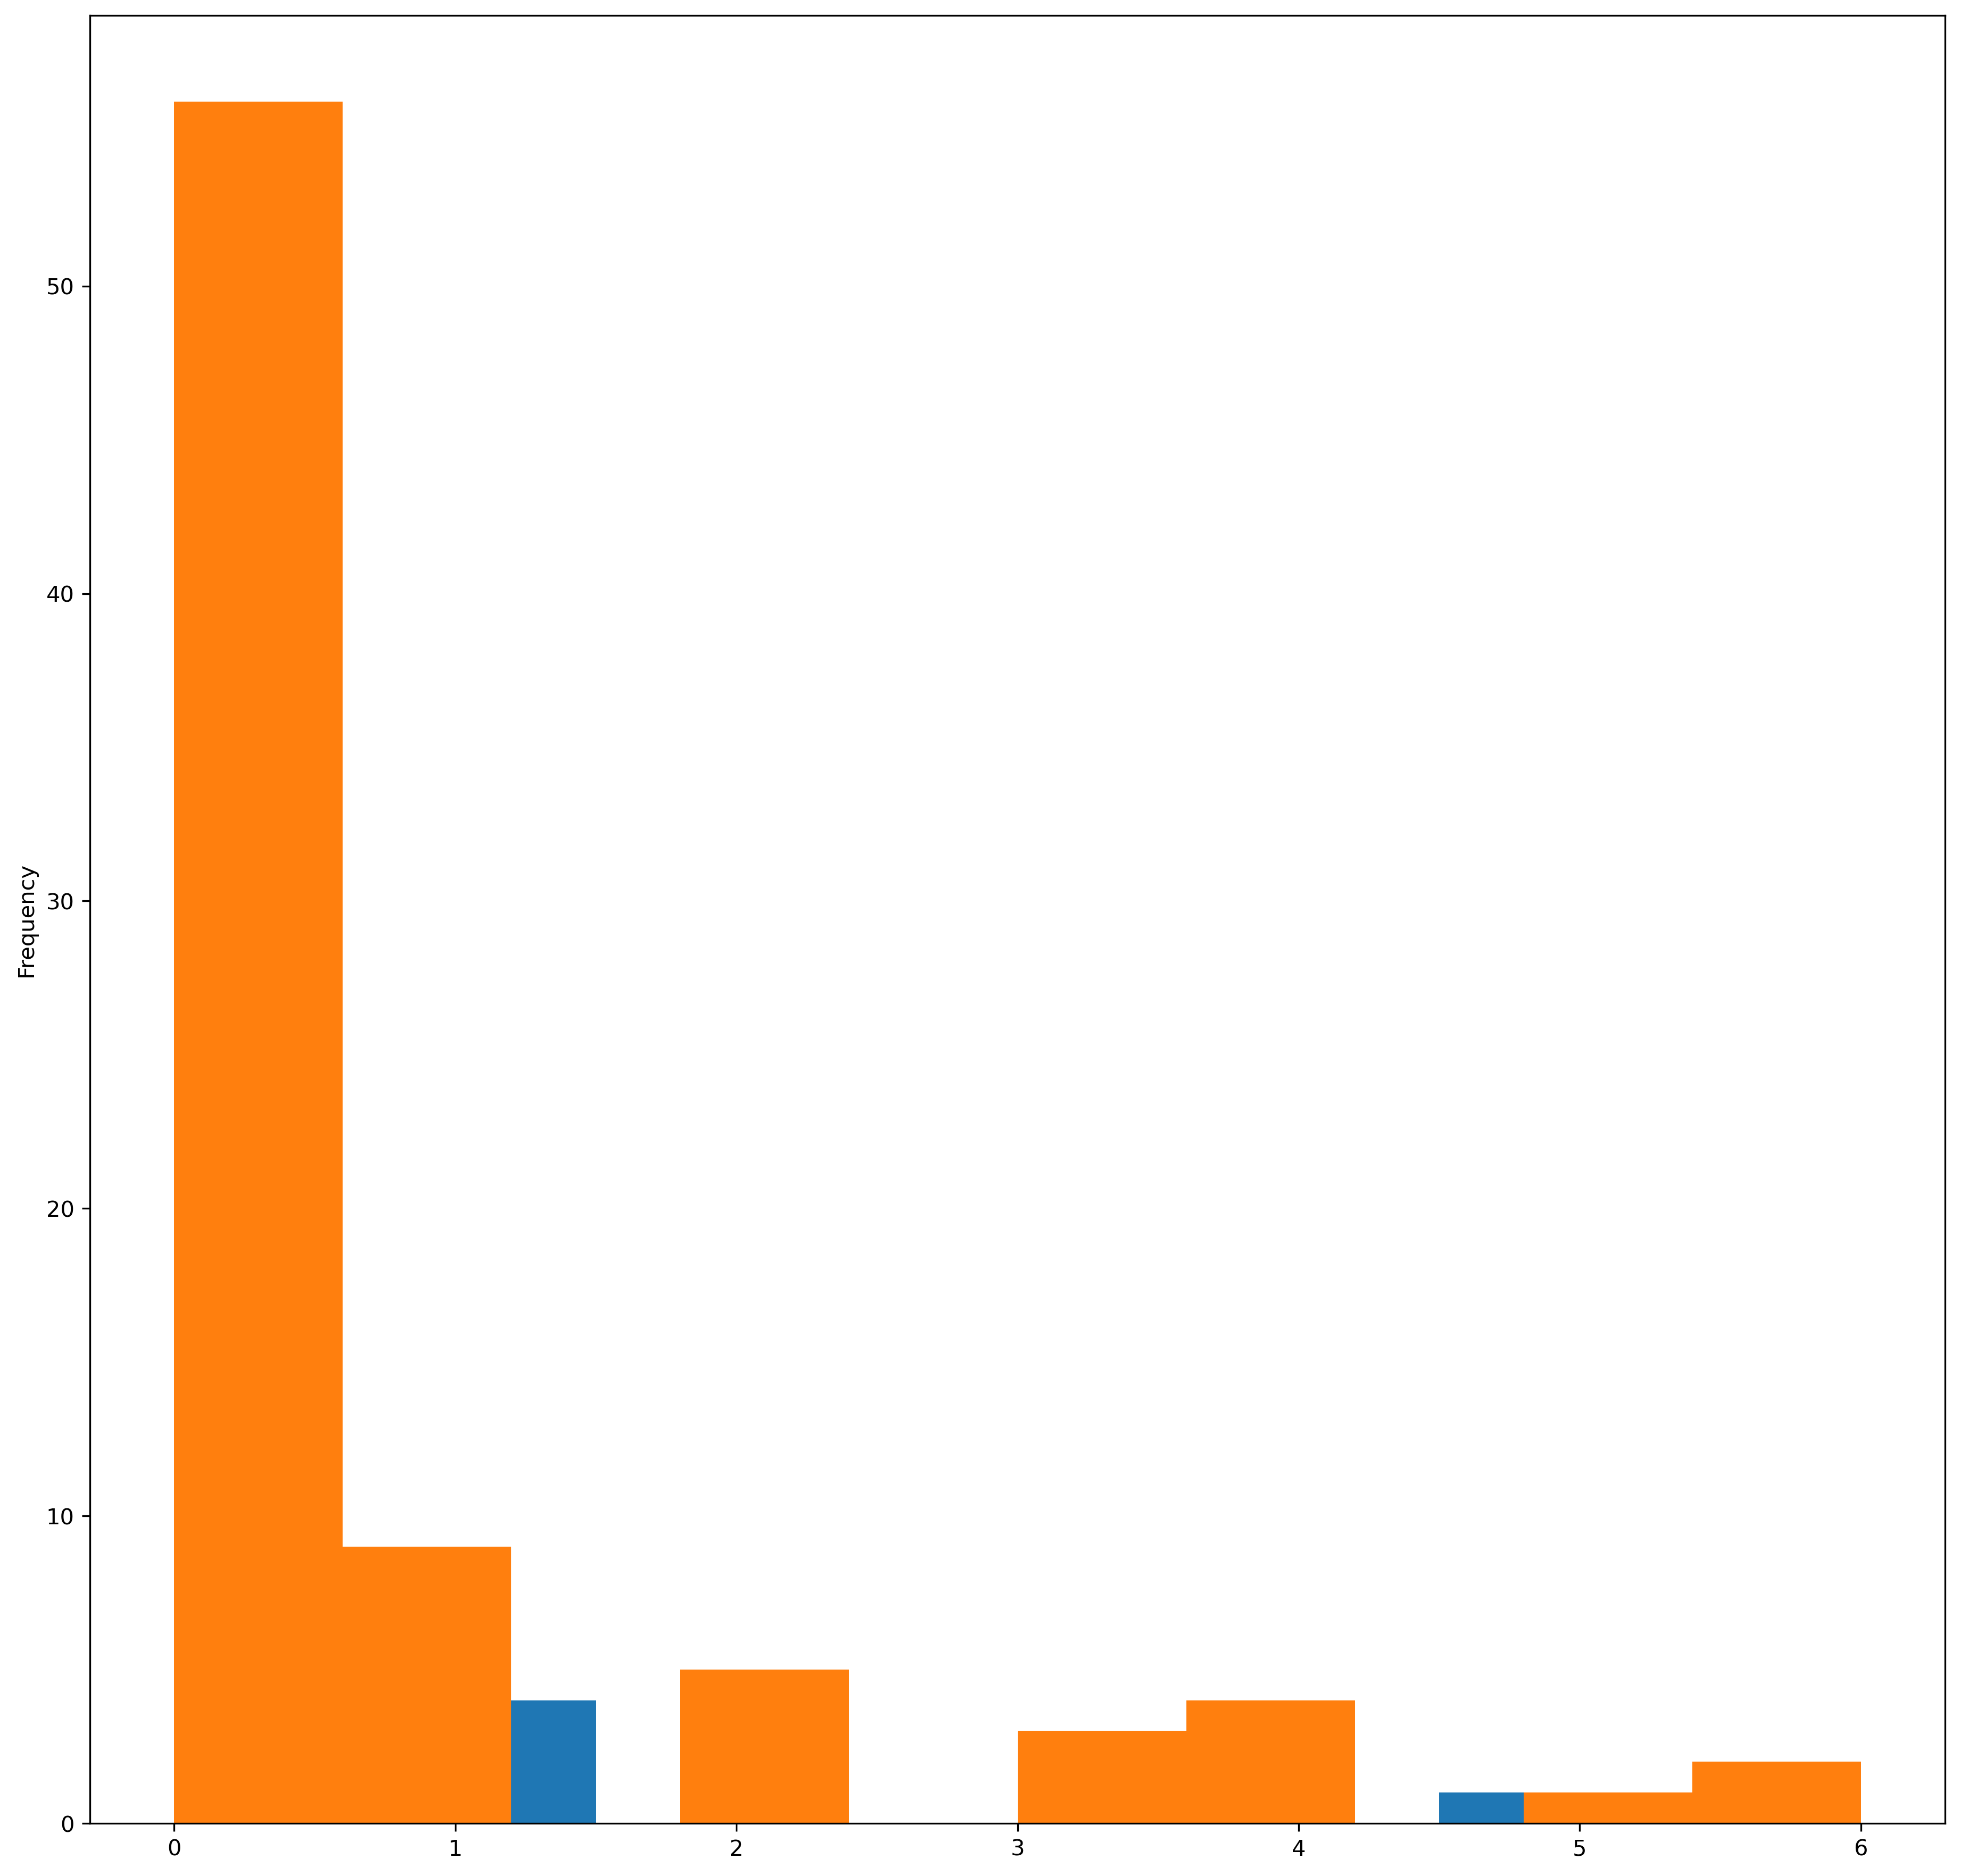

In [283]:
num_consults_df_labeled.groupby('label')['nconsults'].plot(kind='hist')

In [284]:
# look at which departments are being consulted (pick top seven)
top7_consult_df = pd.DataFrame(list(abpain_consult2.ConStopCodeName.value_counts()[:7].index),columns=['ConStopCodeName'])
top7_consult_df

ConStopCodeName
0   GENERAL SURGERY
1               EKG
2     CHART CONSULT
3    UROLOGY CLINIC
4  GASTROENTEROLOGY
5      GI ENDOSCOPY
6        CARDIOLOGY

In [ ]:
c = 0
consult_dept = {}
for PtSSN in abpain_cohort.PtSSN.unique():
    recs = abpain_consult2[abpain_consult2.PtSSN==PtSSN]
    con = recs.ConStopCodeName
    tmp_vc = pd.merge(con,top7_consult_df,on='ConStopCodeName').ConStopCodeName.value_counts()
    consult_dept[c] = {'PtSSN':PtSSN}
    for code in top7_consult_df.ConStopCodeName:
        if code in tmp_vc:
            consult_dept[c][code] = tmp_vc[code]
        else:
            consult_dept[c][code] = 0
    c = c + 1
consult_dept_df = pd.DataFrame.from_dict(consult_dept,orient='index')
consult_dept_df

In [286]:
consult_dept_df_labeled = pd.merge(consult_dept_df,labels_df,on='PtSSN')

# is any consult significant
for field in consult_dept_df_labeled.columns[2:-1]:
    print(field)
    print(scipy.stats.ttest_ind(consult_dept_df_labeled[consult_dept_df_labeled.label=='MOD'][field],
                                      consult_dept_df_labeled[consult_dept_df_labeled.label=='NoMOD'][field]))

EKG
Ttest_indResult(statistic=1.4327681760438251, pvalue=0.15498190345653504)
CHART CONSULT
Ttest_indResult(statistic=-0.8767192025210492, pvalue=0.38269934543053397)
UROLOGY CLINIC
Ttest_indResult(statistic=nan, pvalue=nan)
GASTROENTEROLOGY
Ttest_indResult(statistic=-0.6498273932558098, pvalue=0.5172645382674323)
GI ENDOSCOPY
Ttest_indResult(statistic=0.6254942727738887, pvalue=0.5330437111232542)
CARDIOLOGY
Ttest_indResult(statistic=nan, pvalue=nan)


# Code for extracting meds

In [287]:
meds = dataset['RxOutpat']

meds.rename(columns={'PatientSSN':'PtSSN'},inplace=True)
meds.PtSSN = meds.PtSSN.astype('int32')
# restrict meds to abpain cohort
abpain_meds1 = pd.merge(meds,abpain_cohort[['PtSSN','EDStartDateTime','EDEndDateTime']],on='PtSSN')

# restrict meds to abpain cohort within the ED Start and End Times
abpain_meds2 = abpain_meds1[(abpain_meds1.DispensedDate >= abpain_meds1.EDStartDateTime) & 
                                  (abpain_meds1.DispensedDate <= abpain_meds1.EDEndDateTime)].copy()

print(abpain_meds2.shape)

(1444, 15)


In [288]:
# is a drug an antibiotic?

antibiotics_list = ['CIPRO','AMOXI','CEF','CEPH','CLIND','DOXYC','METRONIDA','VANCO']
def is_antibiotic(drug):
    for a in antibiotics_list:
        if drug.find(a)>= 0:
            print(drug)
            return 1
    return 0



In [289]:
vc = abpain_meds2.LocalDrugNameWithDose.value_counts()
[(a,is_antibiotic(a)) for a in list(vc.index) if is_antibiotic(a)]
#abpain_meds2.columns

CIPROFLOXACIN HCL 500MG TAB
CIPROFLOXACIN HCL 500MG TAB
AMOXICILLIN 875/CLAV K 125MG TAB
AMOXICILLIN 875/CLAV K 125MG TAB
METRONIDAZOLE 500MG TAB
METRONIDAZOLE 500MG TAB
METRONIDAZOLE 250MG TAB
METRONIDAZOLE 250MG TAB
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
DOXYCYCLINE HYCLATE 100MG TAB
DOXYCYCLINE HYCLATE 100MG TAB
CEFDINIR 300MG CAP
CEFDINIR 300MG CAP
METRONIDAZOLE TAB 500MG
METRONIDAZOLE TAB 500MG
CEFPODOXIME PROXETIL 200MG TAB
CEFPODOXIME PROXETIL 200MG TAB
CLINDAMYCIN HCL 150MG CAP
CLINDAMYCIN HCL 150MG CAP
DOXYCYCLINE MONOHYDRATE 100MG CAP
DOXYCYCLINE MONOHYDRATE 100MG CAP
AMOXICILLIN 500/CLAV K 125MG TAB
AMOXICILLIN 500/CLAV K 125MG TAB
VANCOMYCIN 125MG CAP
VANCOMYCIN 125MG CAP
CIPROFLOXACIN 500MG TAB ##
CIPROFLOXACIN 500MG TAB ##
VANCOMYCIN HCL 125MG CAP
VANCOMYCIN HCL 125MG CAP
CEFUROXIME AXETIL 500MG TAB
CEFUROXIME AXETIL 500MG TAB
CIPROFLOXACIN  500 MG TAB
CIPROFLOXACIN  500 MG TAB
CIPROFLOXACIN HCL 250MG TAB
CIPROFLOXACIN HCL 250MG TAB
CLINDAMYCIN HCL 300MG CAP
CLINDAMYCI

[('CIPROFLOXACIN HCL 500MG TAB', 1),
 ('AMOXICILLIN 875/CLAV K 125MG TAB', 1),
 ('METRONIDAZOLE 500MG TAB', 1),
 ('METRONIDAZOLE 250MG TAB', 1),
 ('CEPHALEXIN 500MG CAP', 1),
 ('DOXYCYCLINE HYCLATE 100MG TAB', 1),
 ('CEFDINIR 300MG CAP', 1),
 ('METRONIDAZOLE TAB 500MG', 1),
 ('CEFPODOXIME PROXETIL 200MG TAB', 1),
 ('CLINDAMYCIN HCL 150MG CAP', 1),
 ('DOXYCYCLINE MONOHYDRATE 100MG CAP', 1),
 ('AMOXICILLIN 500/CLAV K 125MG TAB', 1),
 ('VANCOMYCIN 125MG CAP', 1),
 ('CIPROFLOXACIN 500MG TAB ##', 1),
 ('VANCOMYCIN HCL 125MG CAP', 1),
 ('CEFUROXIME AXETIL 500MG TAB', 1),
 ('CIPROFLOXACIN  500 MG TAB', 1),
 ('CIPROFLOXACIN HCL 250MG TAB', 1),
 ('CLINDAMYCIN HCL 300MG CAP', 1),
 ('CIPROFLOXACIN HCL TAB 250MG', 1),
 ('CEFPODOXIME 200MG TAB', 1),
 ('VANCOMYCIN HCL 250MG CAP', 1),
 ('CEPHALEXIN 250MG CAP', 1),
 ('AMOXICILLIN 875/CLAVUL K 125MG TAB', 1),
 ('CEFTRIAXONE SOD INJ 500 MG VIAL', 1)]

In [290]:
# for every patient in abpain_cohort check if they were given antibiotics a

abpain_cohort_meds = pd.merge(abpain_cohort,abpain_meds2[['PtSSN','LocalDrugNameWithDose']],on='PtSSN',how='left')

antibiotics = {}
for PtSSN in abpain_cohort.PtSSN:
    recs = abpain_cohort_meds[abpain_cohort_meds.PtSSN==PtSSN]
    antibiotics[PtSSN] = recs.LocalDrugNameWithDose.dropna().apply(is_antibiotic).sum()

antibiotics_df = pd.DataFrame.from_dict(antibiotics,orient='index').reset_index()
antibiotics_df.rename(columns={'index':'PtSSN'},inplace=True)

antibiotics_df_labeled = pd.merge(antibiotics_df,labels_df,on='PtSSN')

CIPROFLOXACIN  500 MG TAB
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CEPHALEXIN 500MG CAP
CIPROFLOXACIN HCL 500MG TAB
AMOXICILLIN 875/CLAV K 125MG TAB
VANCOMYCIN HCL 250MG CAP
METRONIDAZOLE 250MG TAB
CIPROFLOXACIN HCL 250MG TAB
METRONIDAZOLE 500MG TAB
DOXYCYCLINE HYCLATE 100MG TAB
CEPHALEXIN 500MG CAP
CEFTRIAXONE SOD INJ 500 MG VIAL
AMOXICILLIN 875/CLAV K 125MG TAB
METRONIDAZOLE 500MG TAB
CIPROFLOXACIN HCL 500MG TAB
CLINDAMYCIN HCL 150MG CAP
DOXYCYCLINE MONOHYDRATE 100MG CAP
CEFDINIR 300MG CAP
AMOXICILLIN 875/CLAVUL K 125MG TAB
AMOXICILLIN 875/CLAV K 125MG TAB
CIPROFLOXACIN HCL 500MG TAB
CIPROFLOXACIN HCL 500MG TAB
CIPROFLOXACIN HCL 500MG TAB
CIPROFLOXACIN HCL 500MG TAB
AMOXICILLIN 875/CLAV K 125MG TAB
CIPROFLOXACIN HC

# Build models gradually adding more information
- demographics and cohort information alone

In [291]:
abpain_demo.columns

Index(['PtSSN', 'rowid', 'IndexDateTime', 'DOB', 'Gender', 'Ethnicity', 'Race',
       'age', 'new_race'],
      dtype='object')

In [292]:
abpain_cohort_labeled.columns

Index(['PtSSN', 'EDStartDateTime', 'EDEndDateTime', 'AdmitDateTime',
       'DischargeDateTime', 'ed_duration', 'ed_inp_delta', 'visits', 'label'],
      dtype='object')

In [293]:
abpain_demo_labeled.columns

Index(['PtSSN', 'rowid', 'IndexDateTime', 'DOB', 'Gender', 'Ethnicity', 'Race',
       'age', 'new_race', 'label'],
      dtype='object')

In [ ]:
abpain_cohort_labeled

In [ ]:
cohort_features = ['ed_duration','ed_inp_delta'] #,'visits']
demo_features = ['Gender','Ethnicity','age','new_race']

df1 = pd.merge(abpain_cohort_labeled,abpain_demo_labeled,on=['PtSSN','label'])[['PtSSN','label'] + cohort_features + demo_features]
df1.head()

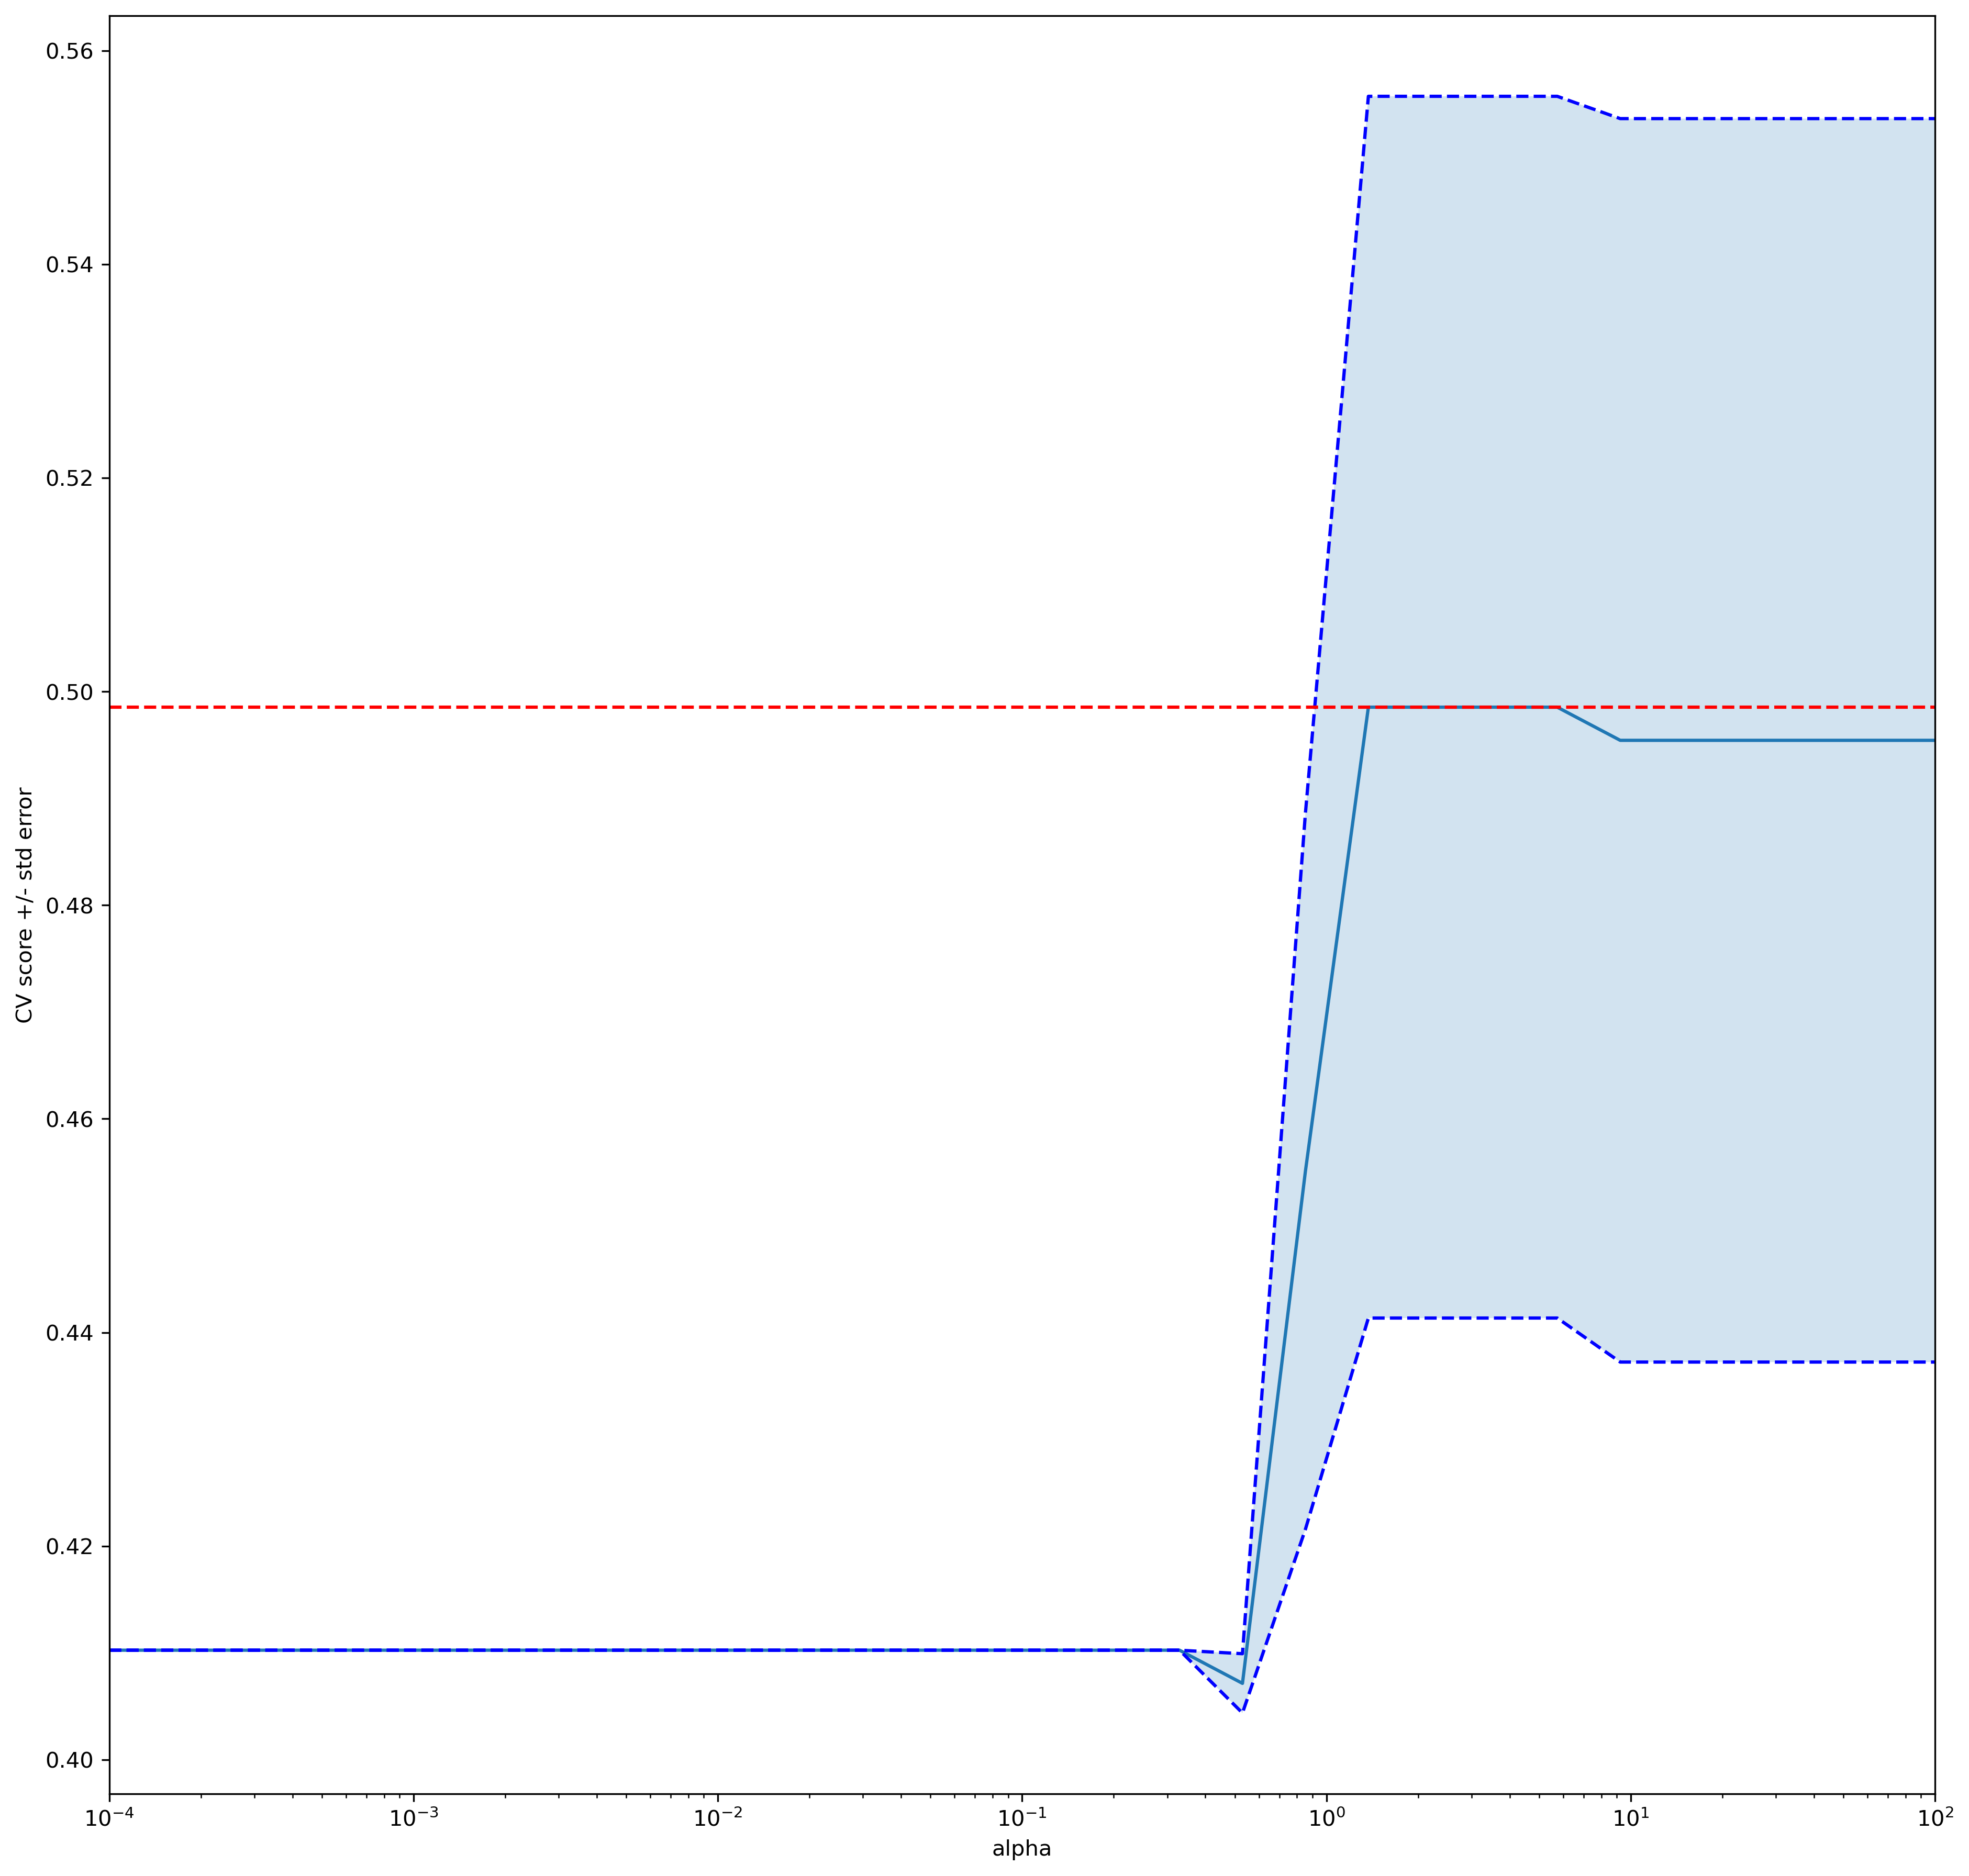

In [296]:
# code Gender, Ethnicity, new_race using get_dummies
tmp1 = pd.get_dummies(df1[['new_race']])
tmp2 = pd.DataFrame(df1['Gender'].apply(lambda x: 1 if x=='M' else 0))
tmp3 = pd.DataFrame(df1['Ethnicity'].apply(lambda x: 1 if x=='HISPANIC OR LATINO' else 0))
df_cohort_demo = pd.concat([df1[['PtSSN','label','age','ed_duration','ed_inp_delta']],tmp1,tmp2,tmp3],axis=1)
# Adel removed visits column from line above

X = df_cohort_demo[df_cohort_demo.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df_cohort_demo['label']])


clf = tune_model(X,y)

In [297]:
clf.best_params_['C']

1.3738237958832638

(115, 10) (115,)
AUC =  0.6 0.11085820139406256
F1 =  0.4985361880098722 0.12786827115504434
Accuracy =  0.7043478260869566 0.06956521739130435
Confusion matrix:
[[78  2]
 [32  3]]
6  features chosen by L1 model.


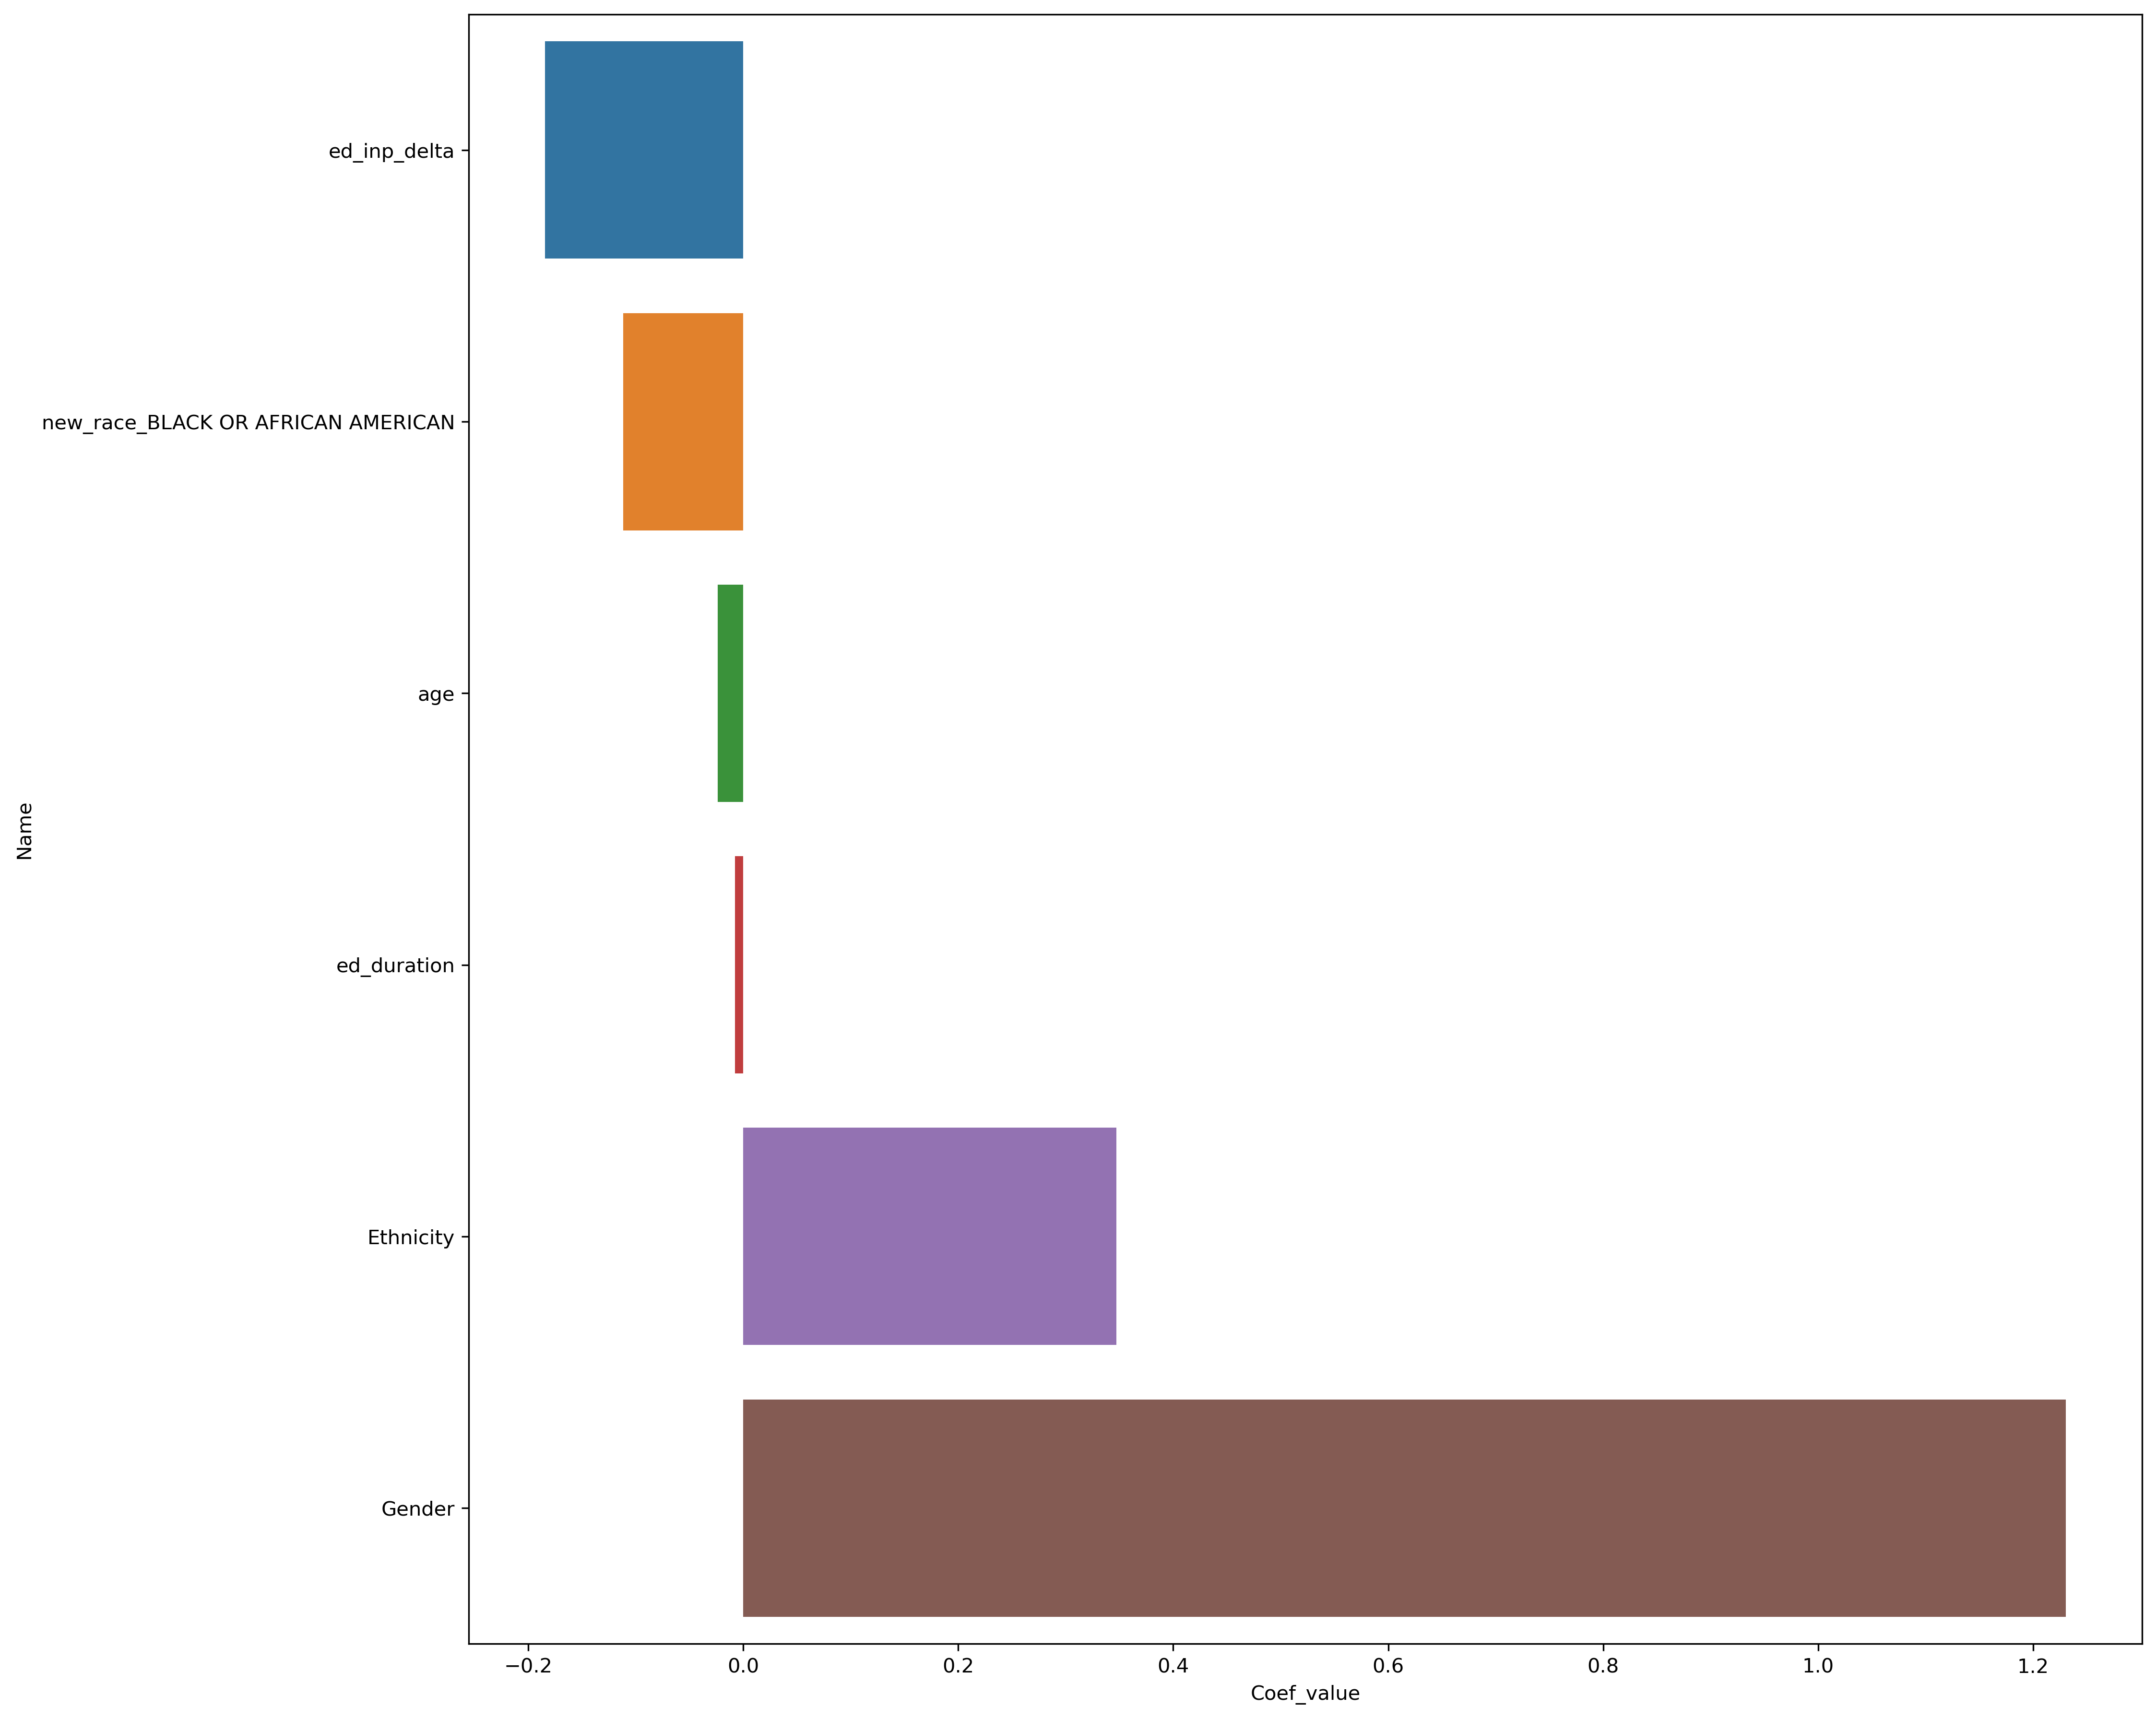

In [298]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

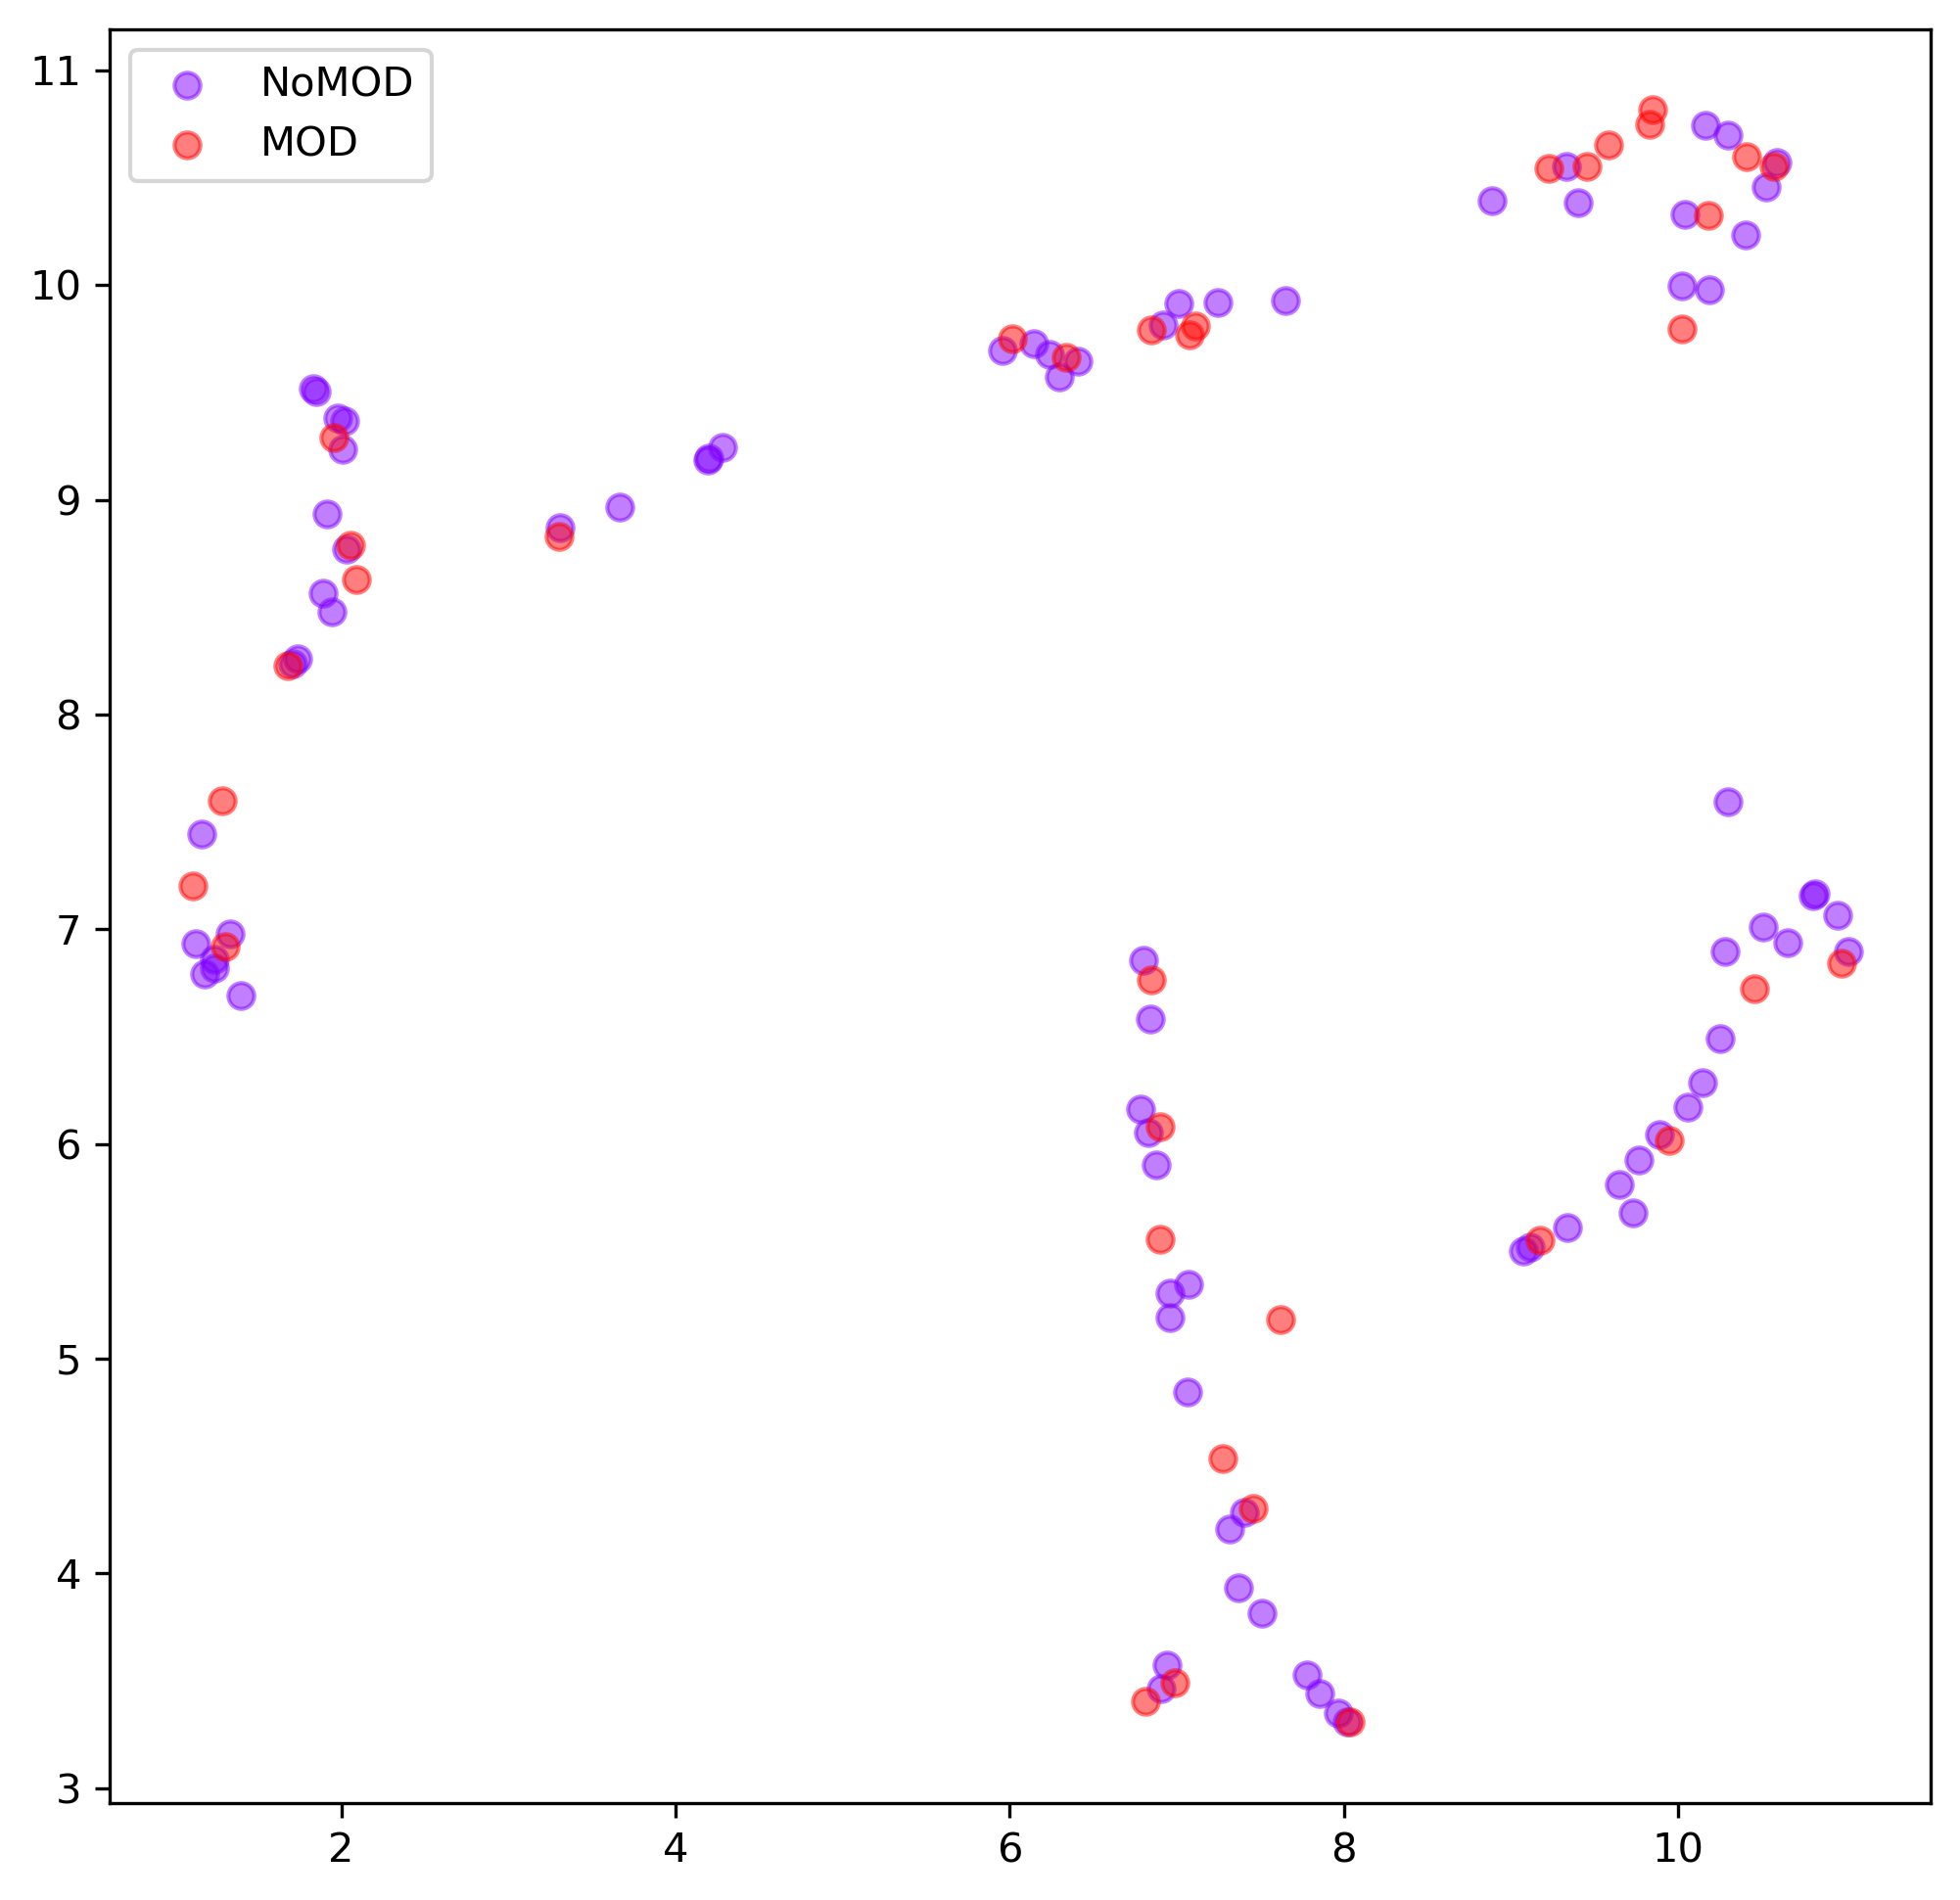

In [299]:
# UMAP visualization with just the selected features
umap_plot_label(X[select_feats],y,1,7,['NoMOD','MOD']);

In [300]:
# which labs are worthy of addition? Use those for which we have the fewest missing values.
labnames = ['wbc','glucose','sodium','potassium','calcium','lactate','chloride','bun','creat','troponin',
           'co2','ast','alt','alkphos','lipase','amylase','urine','albumin']
goodlabs = []
for lab in labnames:
    missing = eval(lab+'_df_labeled').max_value.isna().sum()
    print(missing,lab)
    if missing < 24:
        goodlabs.append(lab)
        
print(goodlabs)

11 wbc
12 glucose
7 sodium
9 potassium
19 calcium
62 lactate
7 chloride
84 bun
7 creat
101 troponin
110 co2
60 ast
62 alt
28 alkphos
22 lipase
83 amylase
95 urine
25 albumin
['wbc', 'glucose', 'sodium', 'potassium', 'calcium', 'chloride', 'creat', 'lipase']


In [301]:
# for labs that have lots of missing values; use a boolean to indicate whether test was done at all 
# at any of the visits.
boolean_labs = ['lactate','troponin','amylase','urine']
boolean_labs_df = pd.DataFrame(labels_df[['PtSSN']])
for lab in boolean_labs:
    tmp = eval(lab + '_df_labeled')
    vals = pd.DataFrame(tmp.groupby('PtSSN')['max_value'].agg('count')).reset_index()
    vals.columns=['PtSSN',lab+'_count']
    boolean_labs_df = pd.merge(boolean_labs_df,vals,on='PtSSN')

In [302]:
# now add lab work to the cohort+demo information
# simply consider sodium, potassium, chloride, troponin, amylase (drop lasttwo, too many NaNs)

# when there are multiple lab values for a patient, take the max and min

# take only those labs that pass the p-value test (add wbc for checking SIRS)
goodlabs = ['sodium','potassium','chloride','creat','wbc','albumin']
goodlabs_df = pd.DataFrame(labels_df[['PtSSN']])
for lab in goodlabs:
    tmp = eval(lab + '_df_labeled')
    lmin = pd.DataFrame(tmp.groupby('PtSSN')['min_value'].agg('min')).reset_index()
    lmin.columns=['PtSSN',lab+'_min']
    lmax = pd.DataFrame(tmp.groupby('PtSSN')['max_value'].agg('max')).reset_index()
    lmax.columns=['PtSSN',lab+'_max']
    ldf = pd.merge(lmin,lmax,on='PtSSN')
    goodlabs_df = pd.merge(goodlabs_df,ldf,on='PtSSN')
    
lab_features = [l+'_min' for l in goodlabs] + [l+'_max' for l in goodlabs]

In [303]:
df_cohort_demo_labs1 = pd.merge(df_cohort_demo,goodlabs_df,on='PtSSN')
df_cohort_demo_labs = pd.merge(df_cohort_demo_labs1,boolean_labs_df,on='PtSSN')
df_cohort_demo_labs.shape

(115, 28)

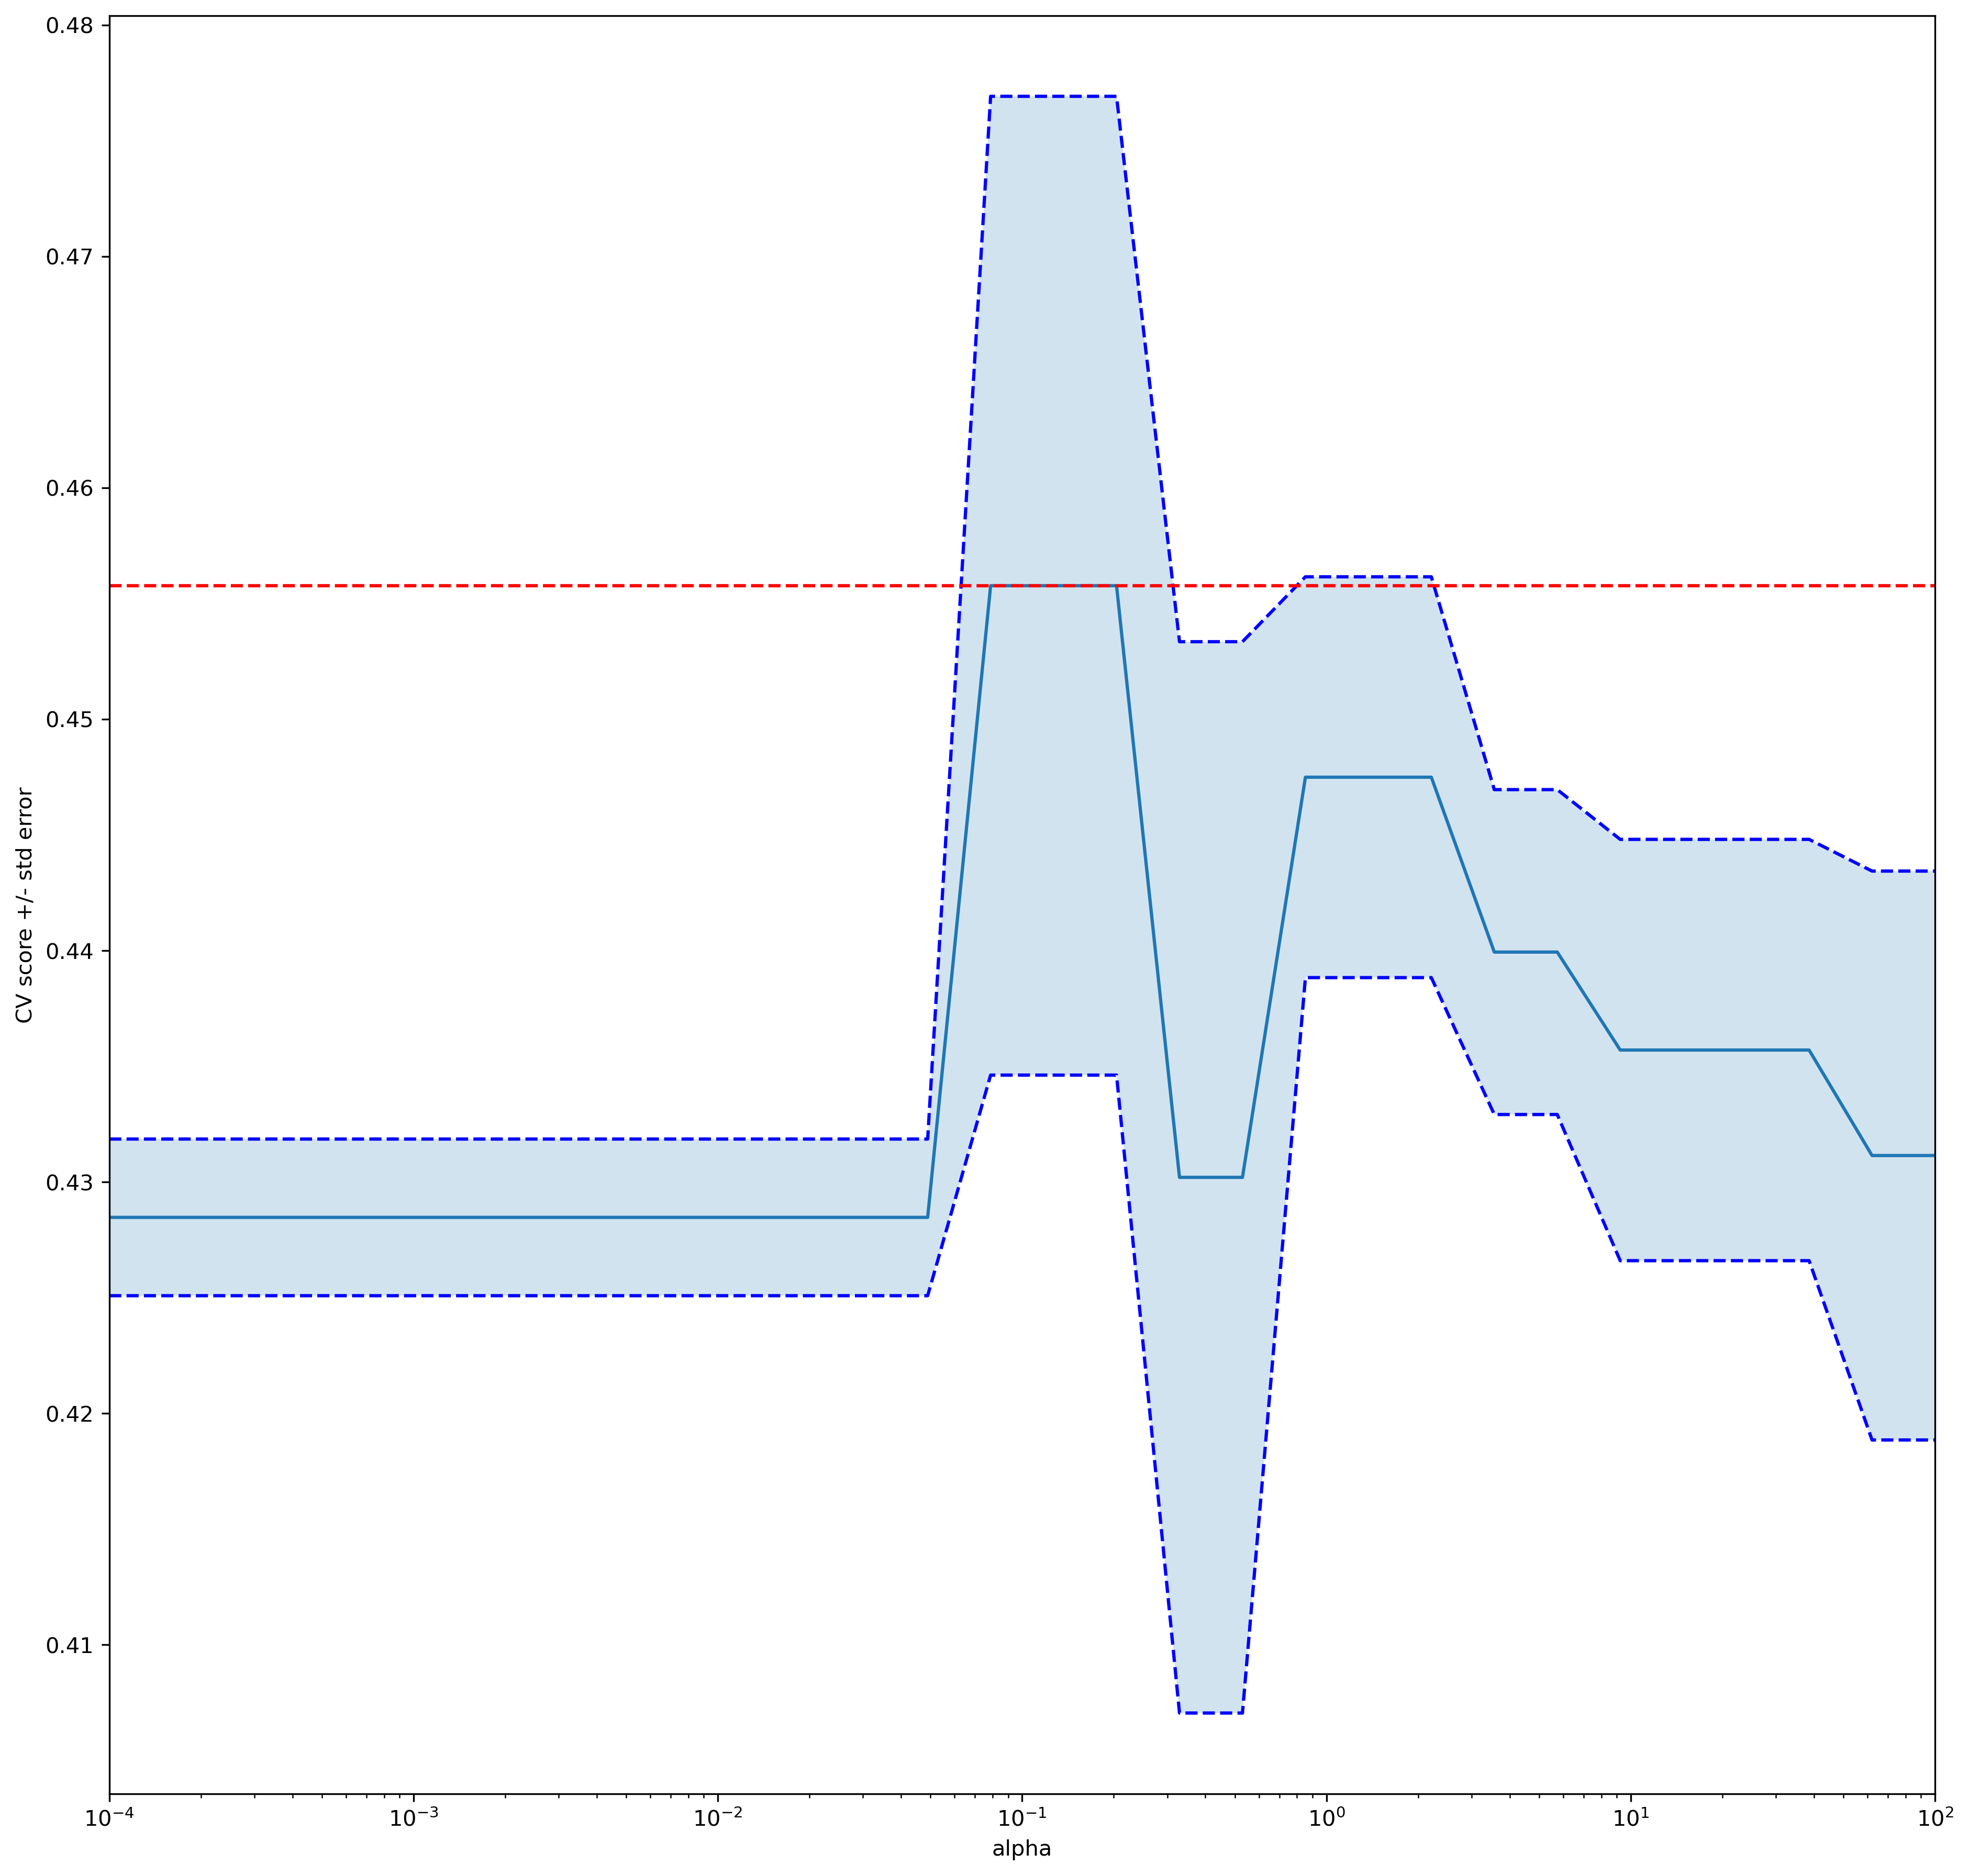

In [304]:
df2_clean = df_cohort_demo_labs.dropna()
X = df2_clean[df2_clean.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df2_clean['label']])

clf = tune_model(X,y)

(84, 26) (84,)
AUC =  0.562628205128205 0.19421824449759217
F1 =  0.4557671957671957 0.04728465778975131
Accuracy =  0.75 0.02278225497769065
Confusion matrix:
[[62  1]
 [21  0]]
4  features chosen by L1 model.


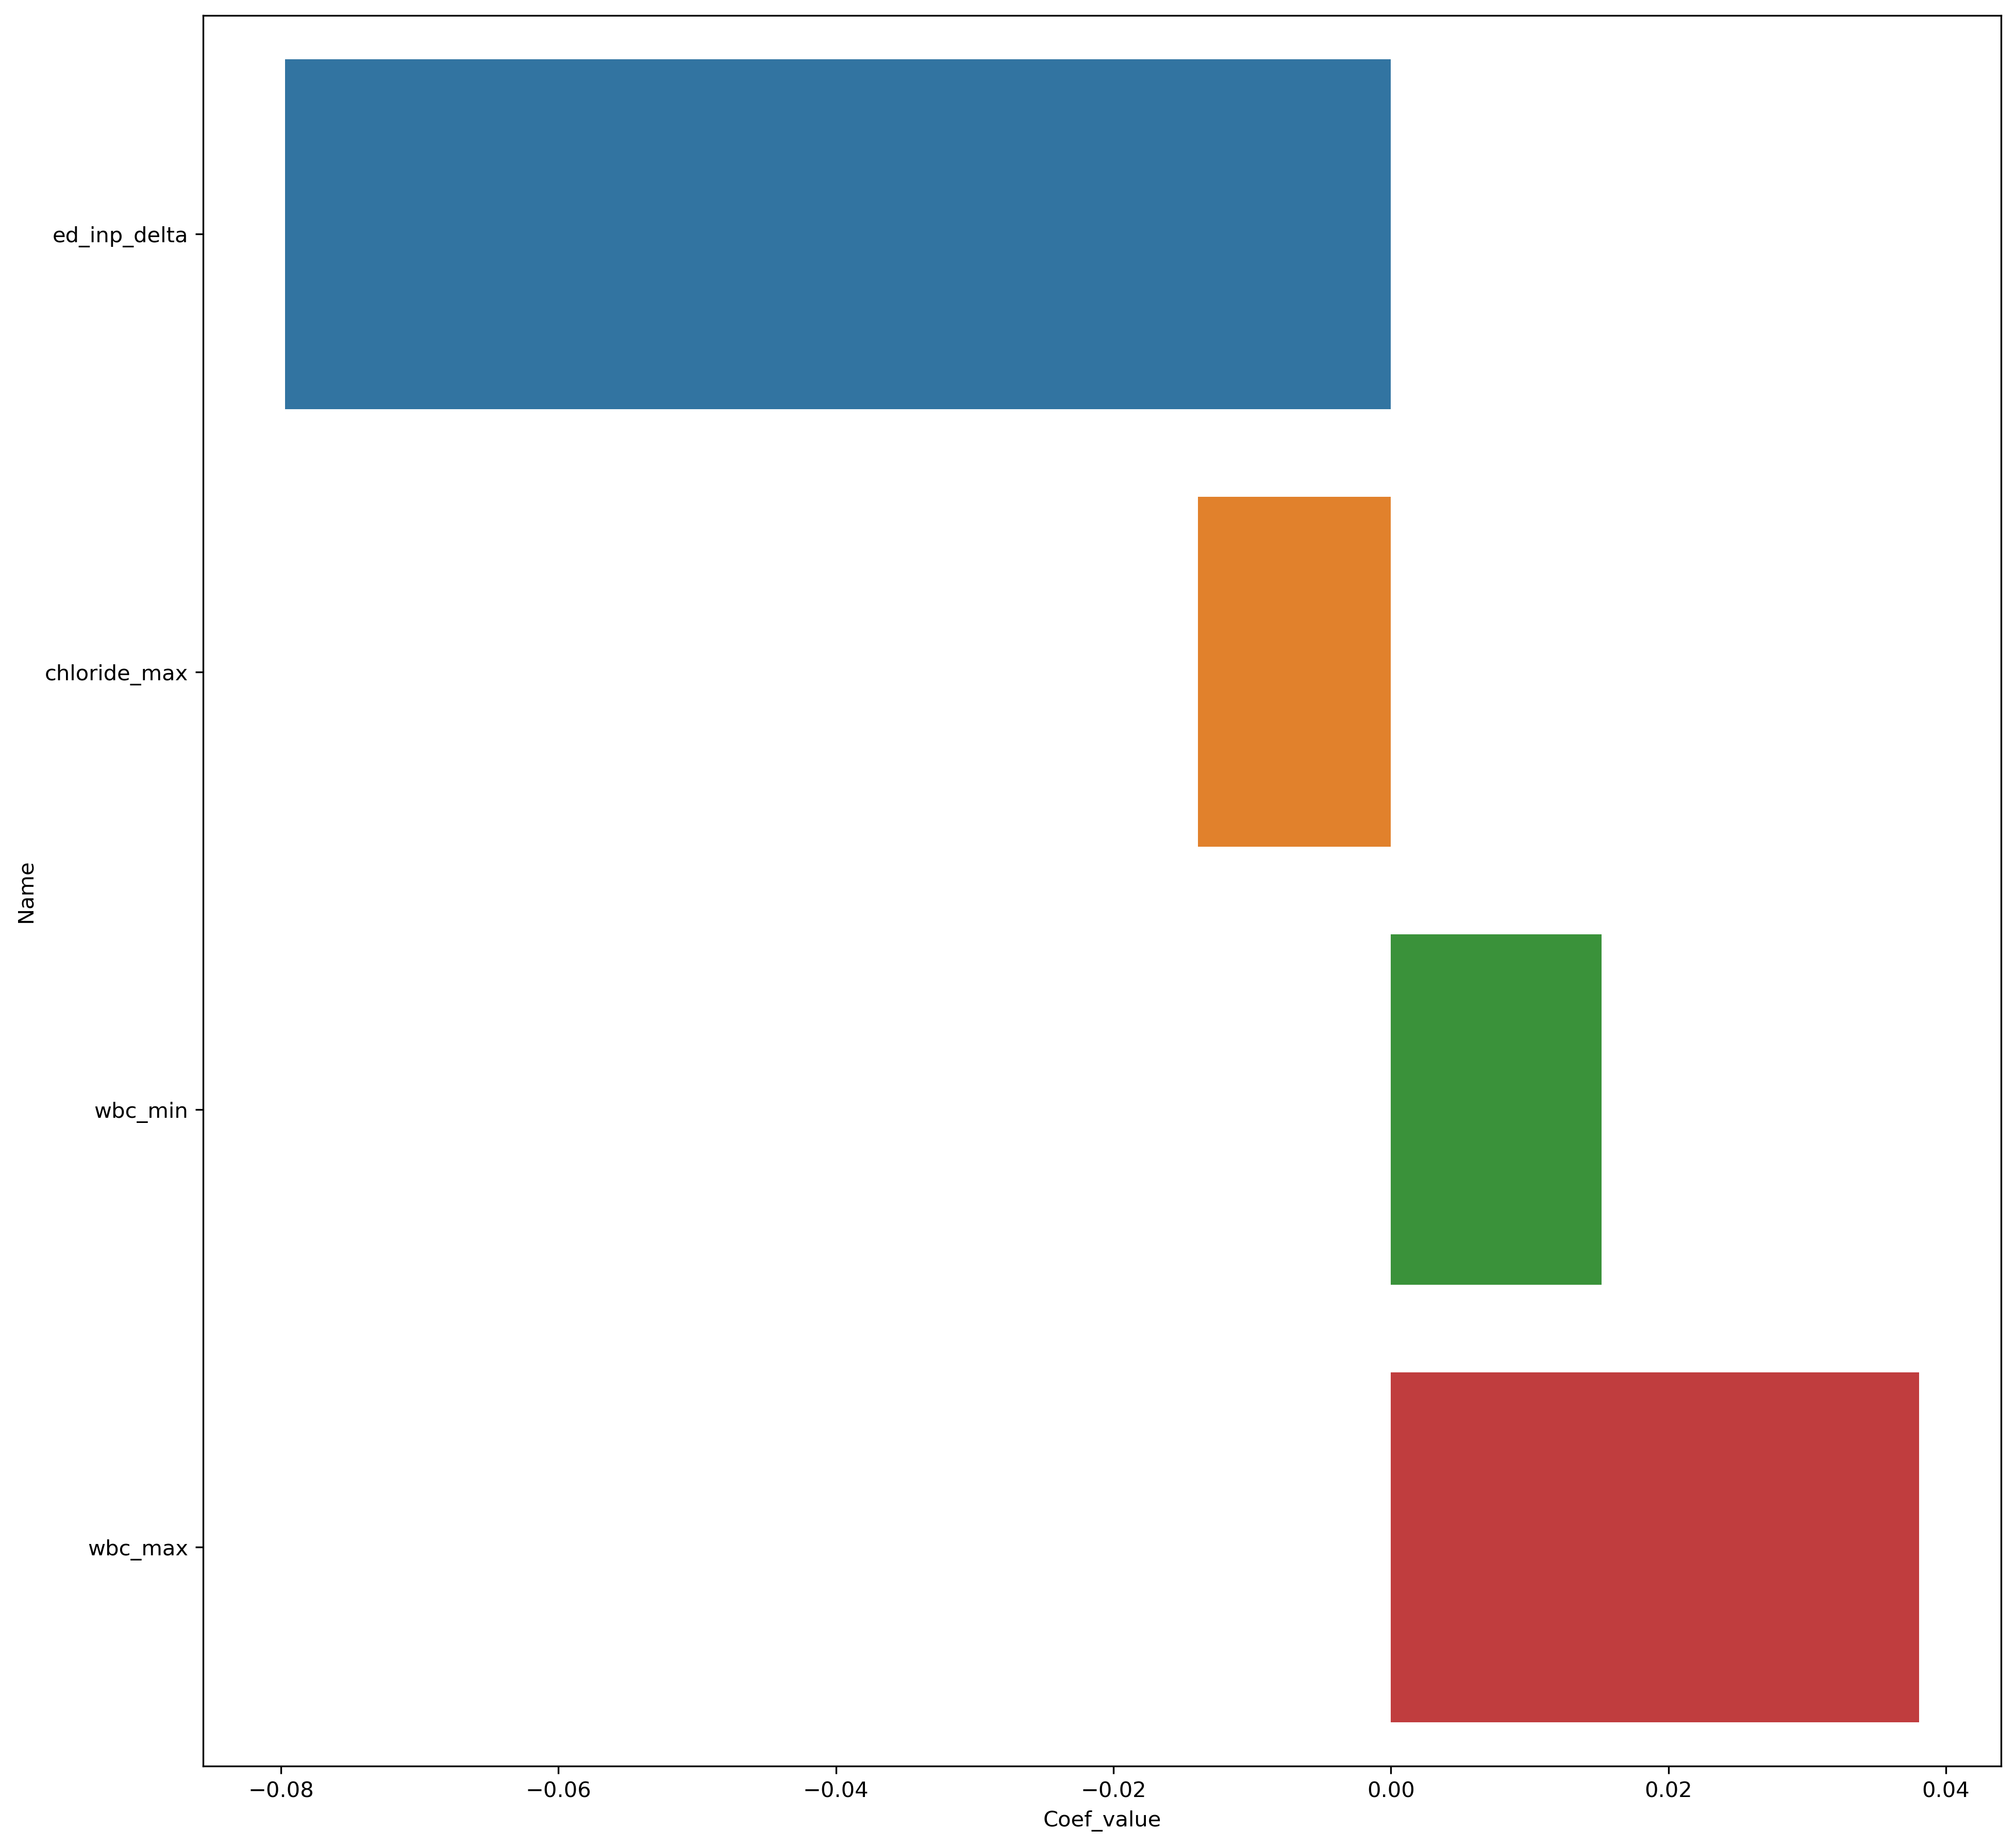

In [305]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

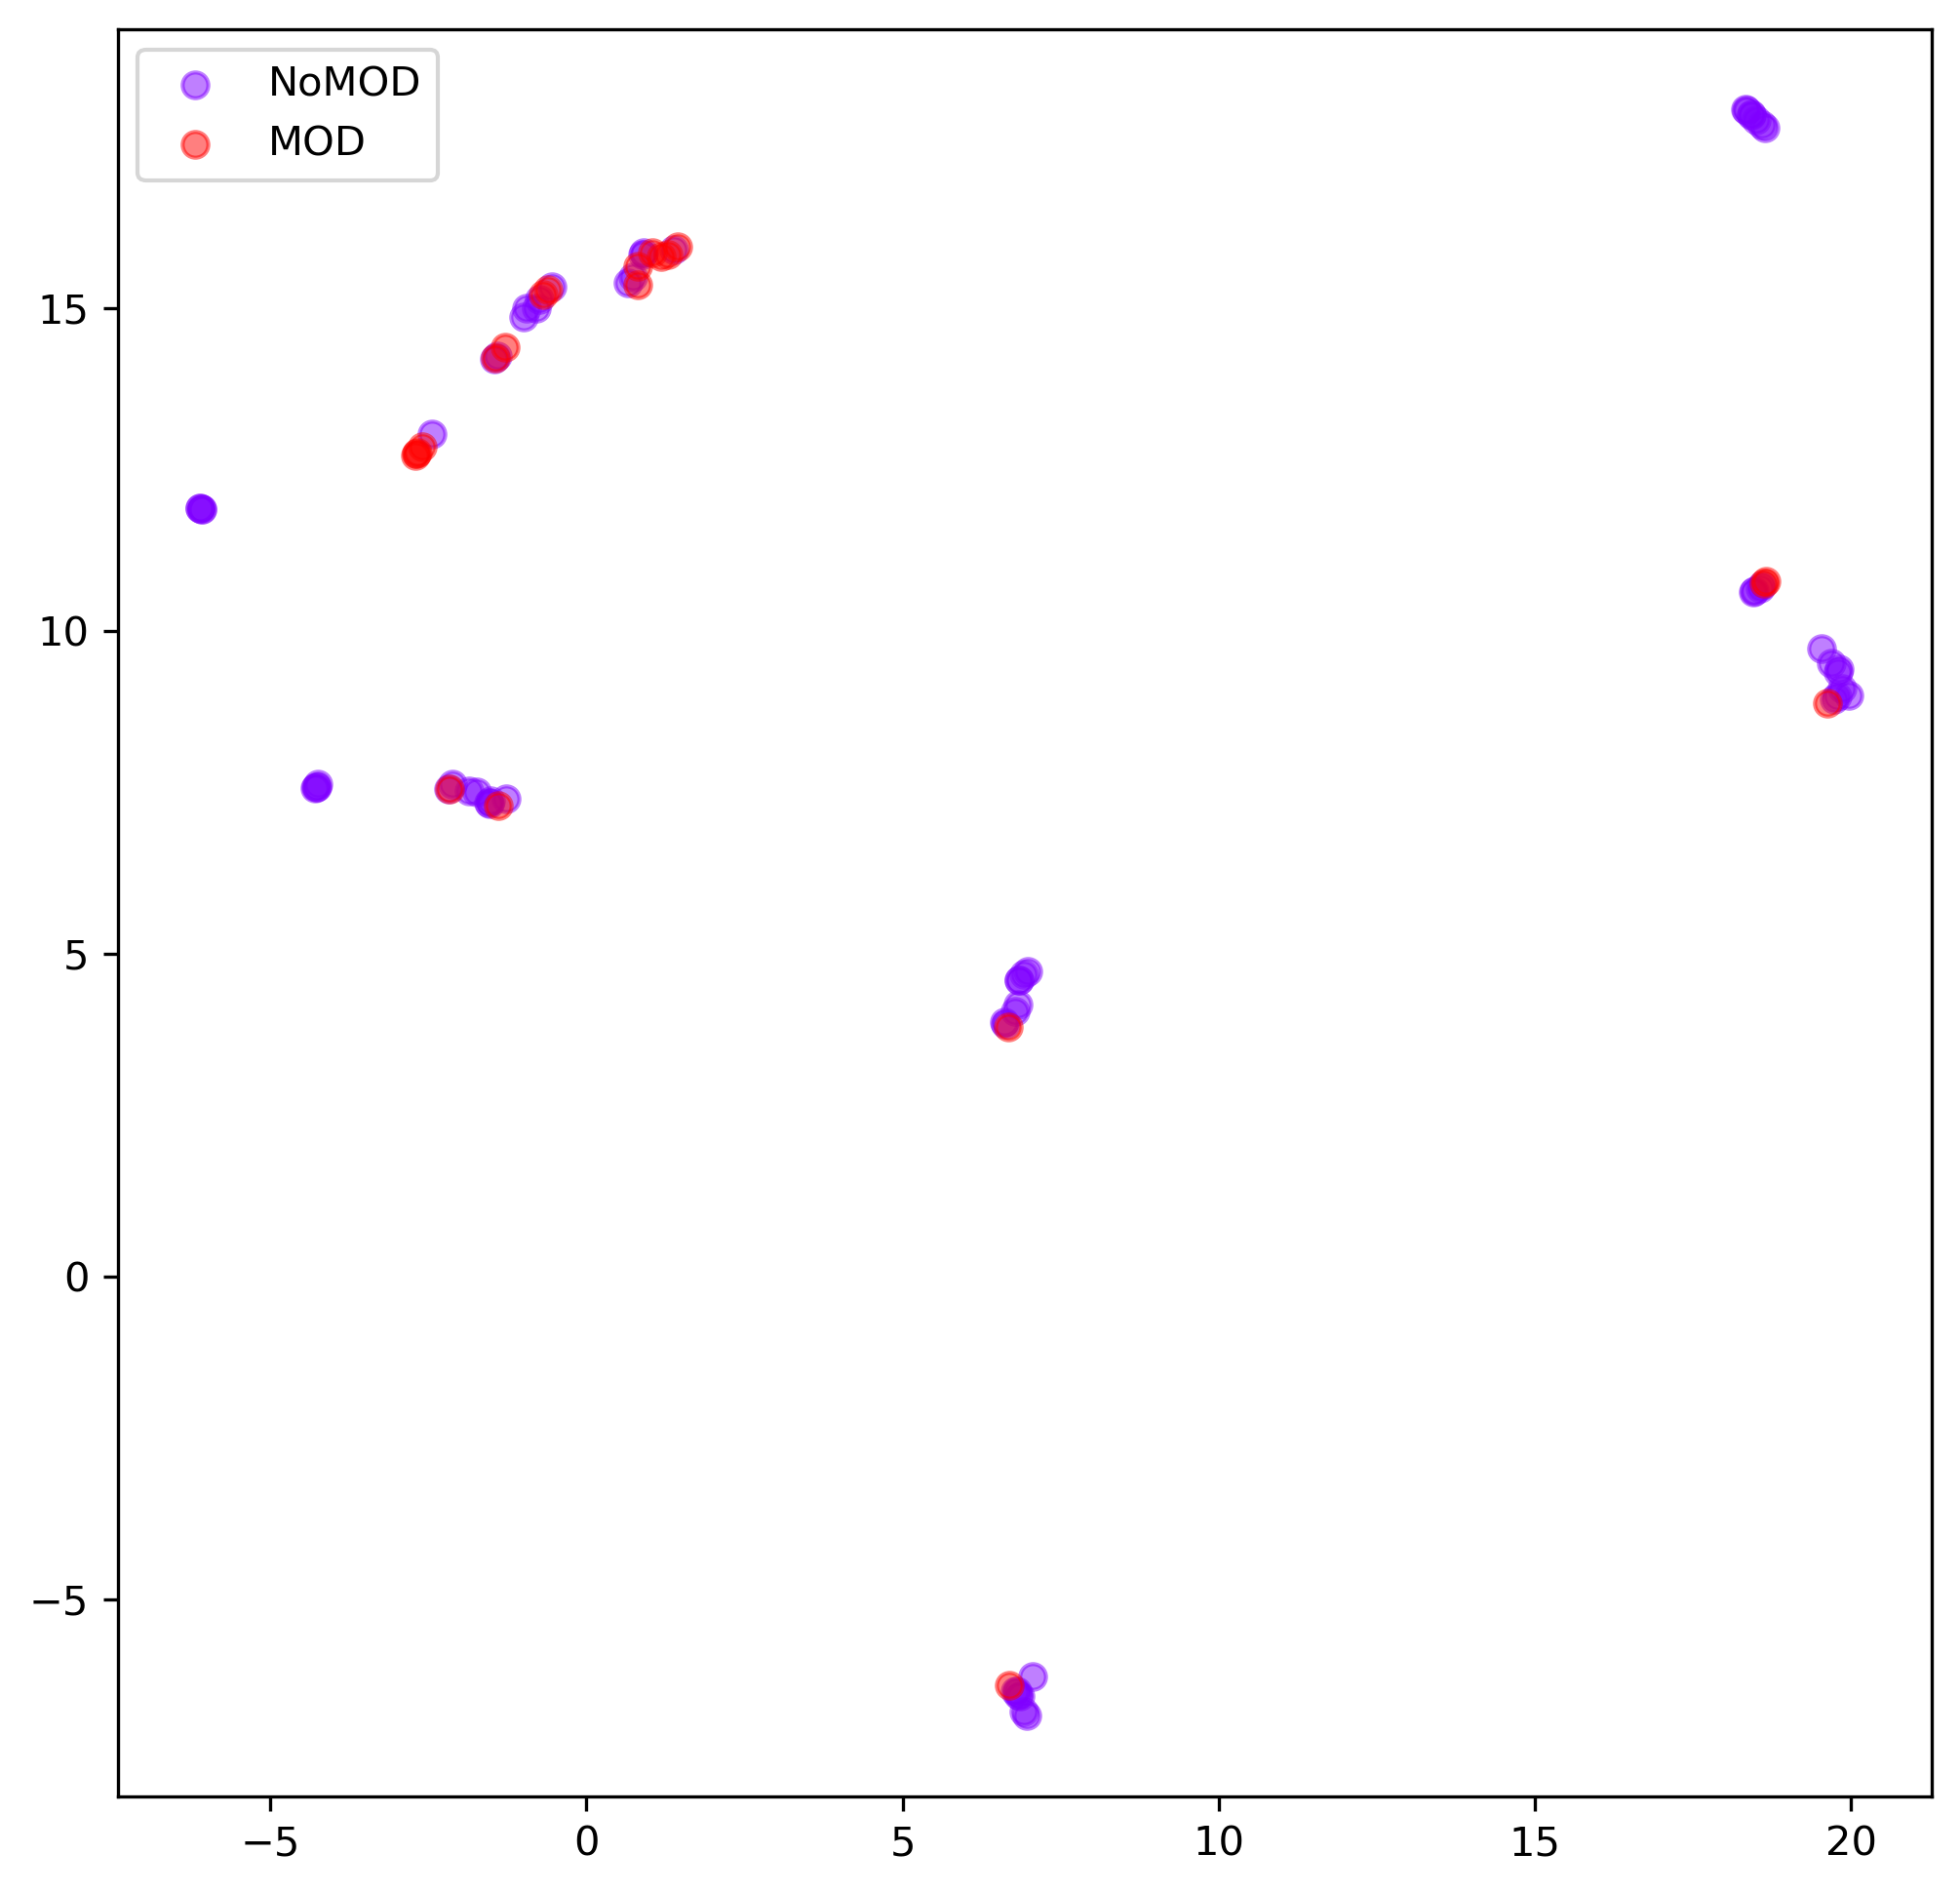

In [306]:
# UMAP visualization with just the selected features
umap_plot_label(X[select_feats],y,2,7,['NoMOD','MOD']);

In [ ]:
clean_vitals_df_labeled.head()

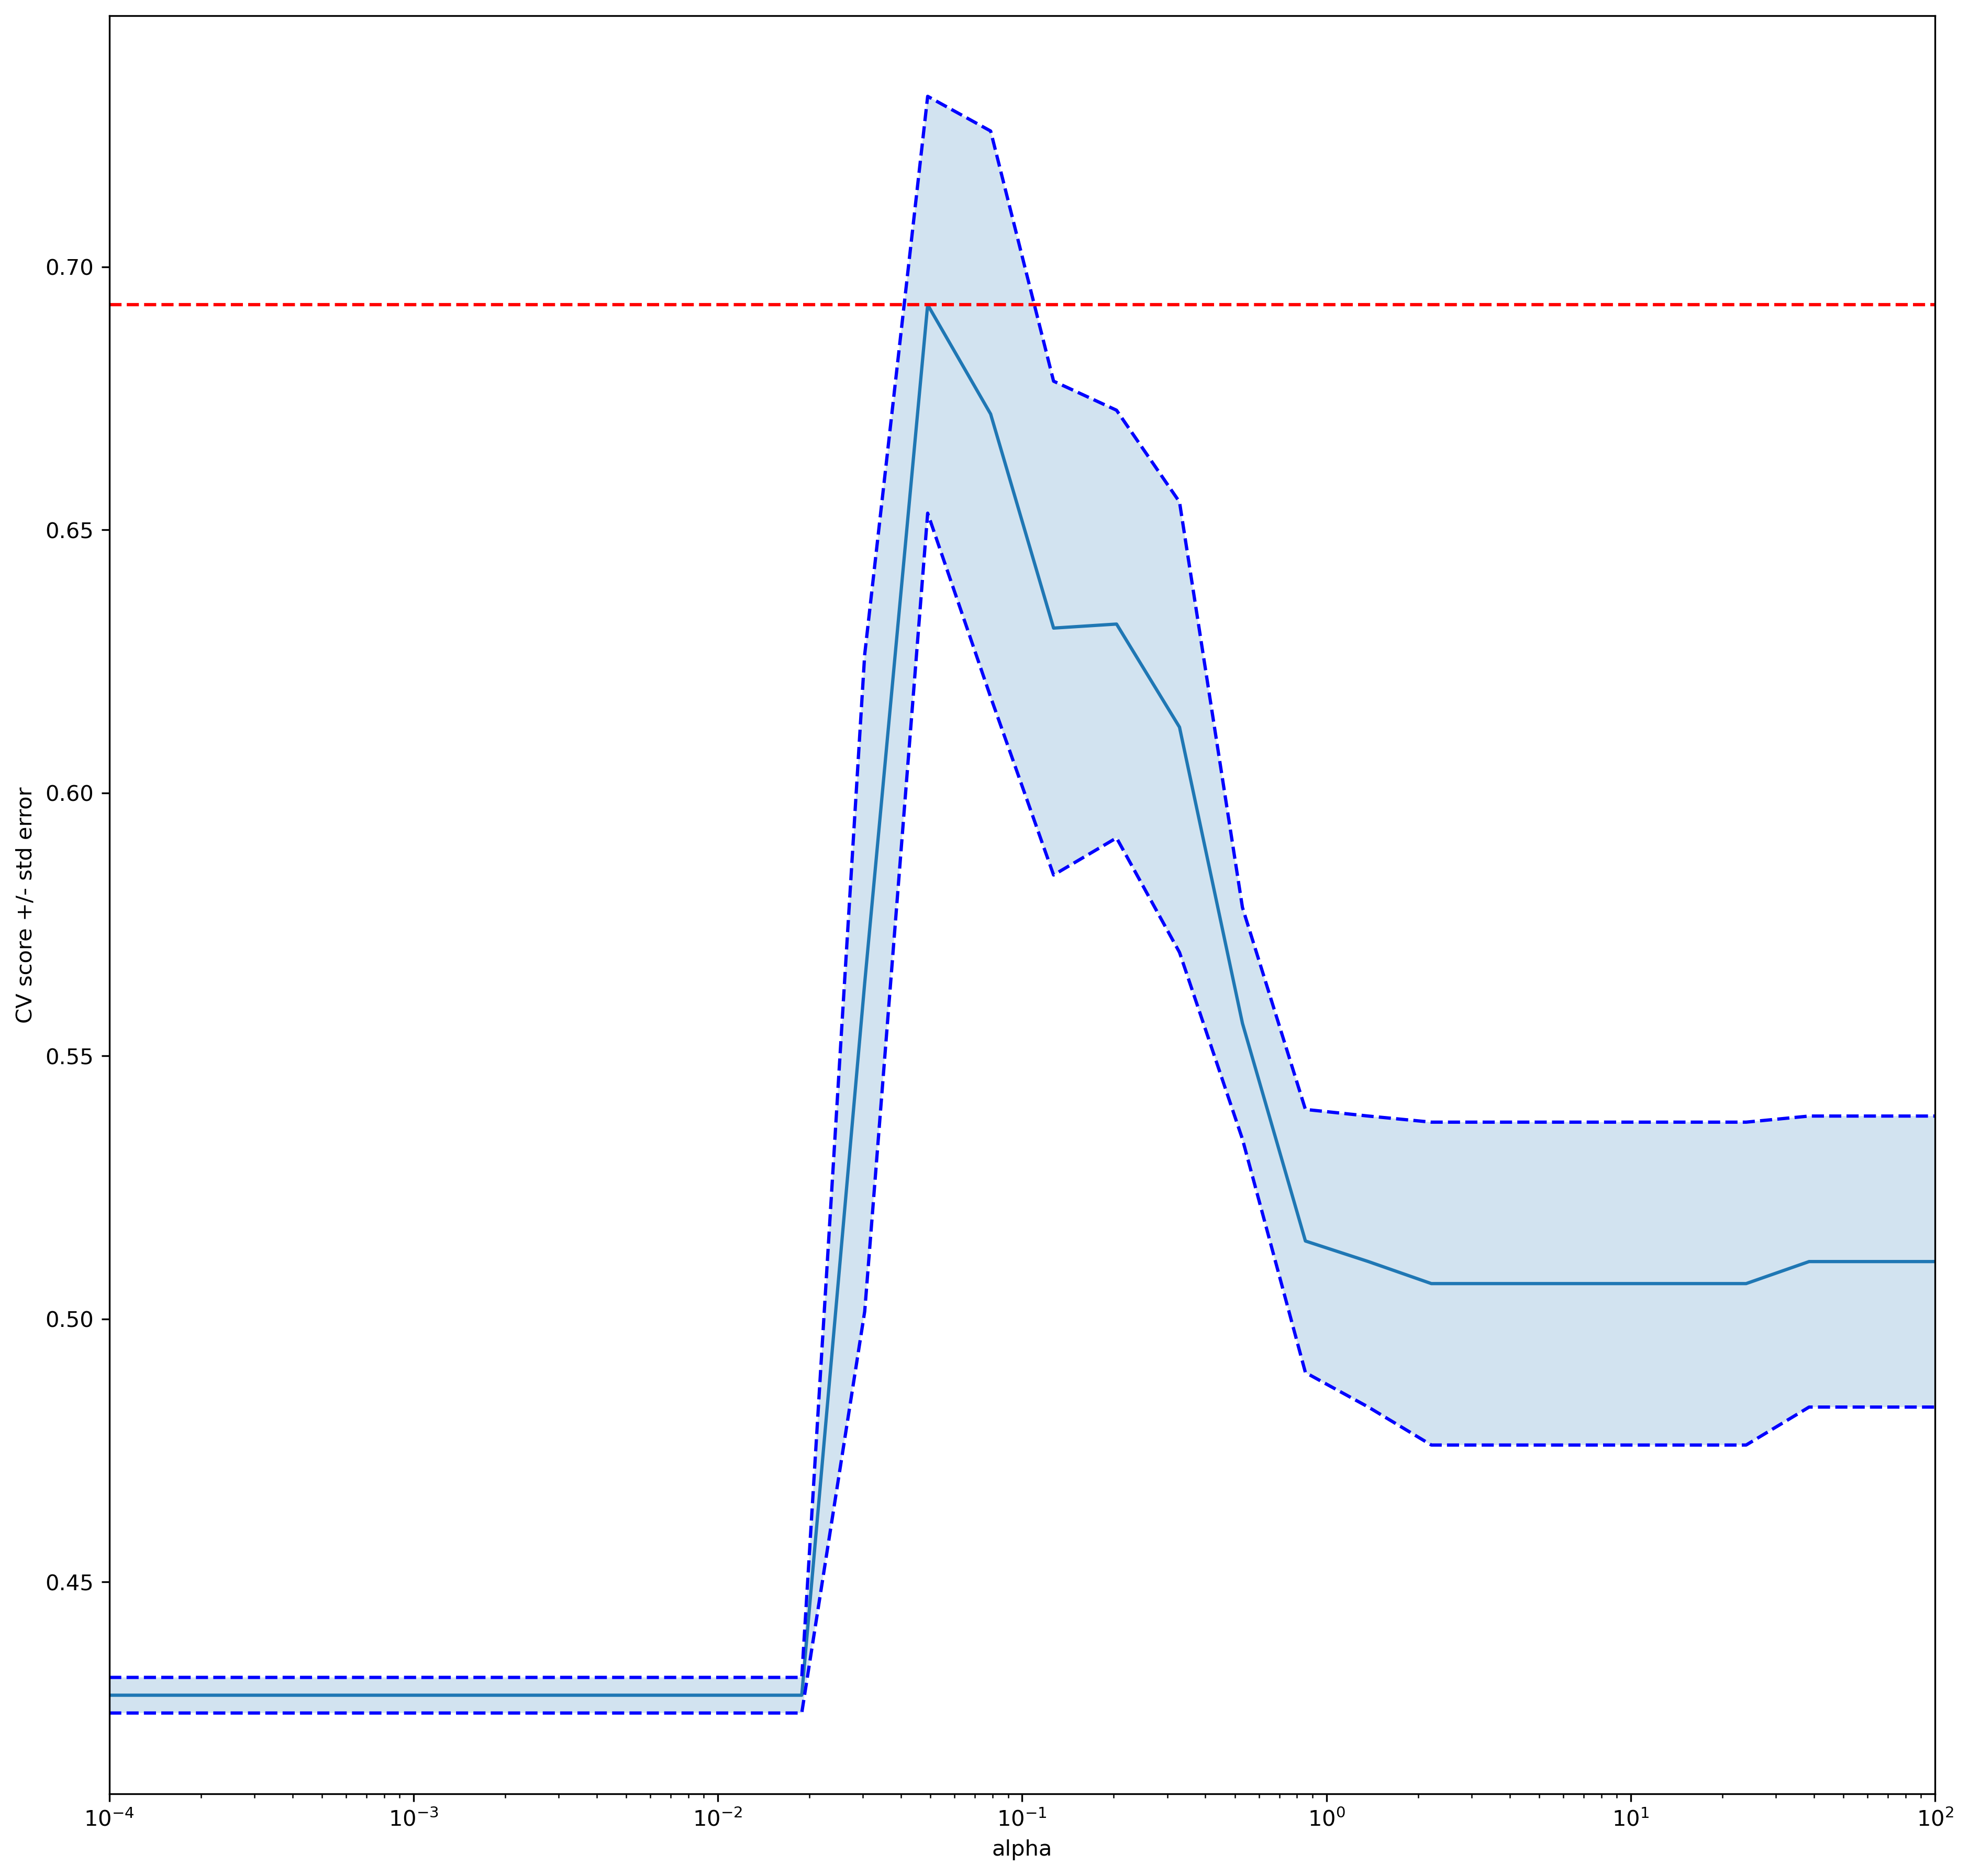

In [308]:
# now take df2_clean and add vitals data
vitals_cols = ['PULSE','TEMPERATURE','SBP','DBP','RESPIRATION']
maxima = [vital+'_max' for vital in vitals_cols]
minima = [vital+'_min' for vital in vitals_cols]
df3 = pd.merge(df2_clean,clean_vitals_df_labeled[['PtSSN','label'] + maxima + minima],on=['PtSSN','label'])
clean_df3 = df3.dropna()

X = clean_df3[clean_df3.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in clean_df3['label']])

clf = tune_model(X,y)

(84, 36) (84,)
AUC =  0.6916025641025643 0.18517414551796996
F1 =  0.6928085133257547 0.08859720244650383
Accuracy =  0.8102941176470587 0.08529411764705881
Confusion matrix:
[[63  0]
 [15  6]]
10  features chosen by L1 model.


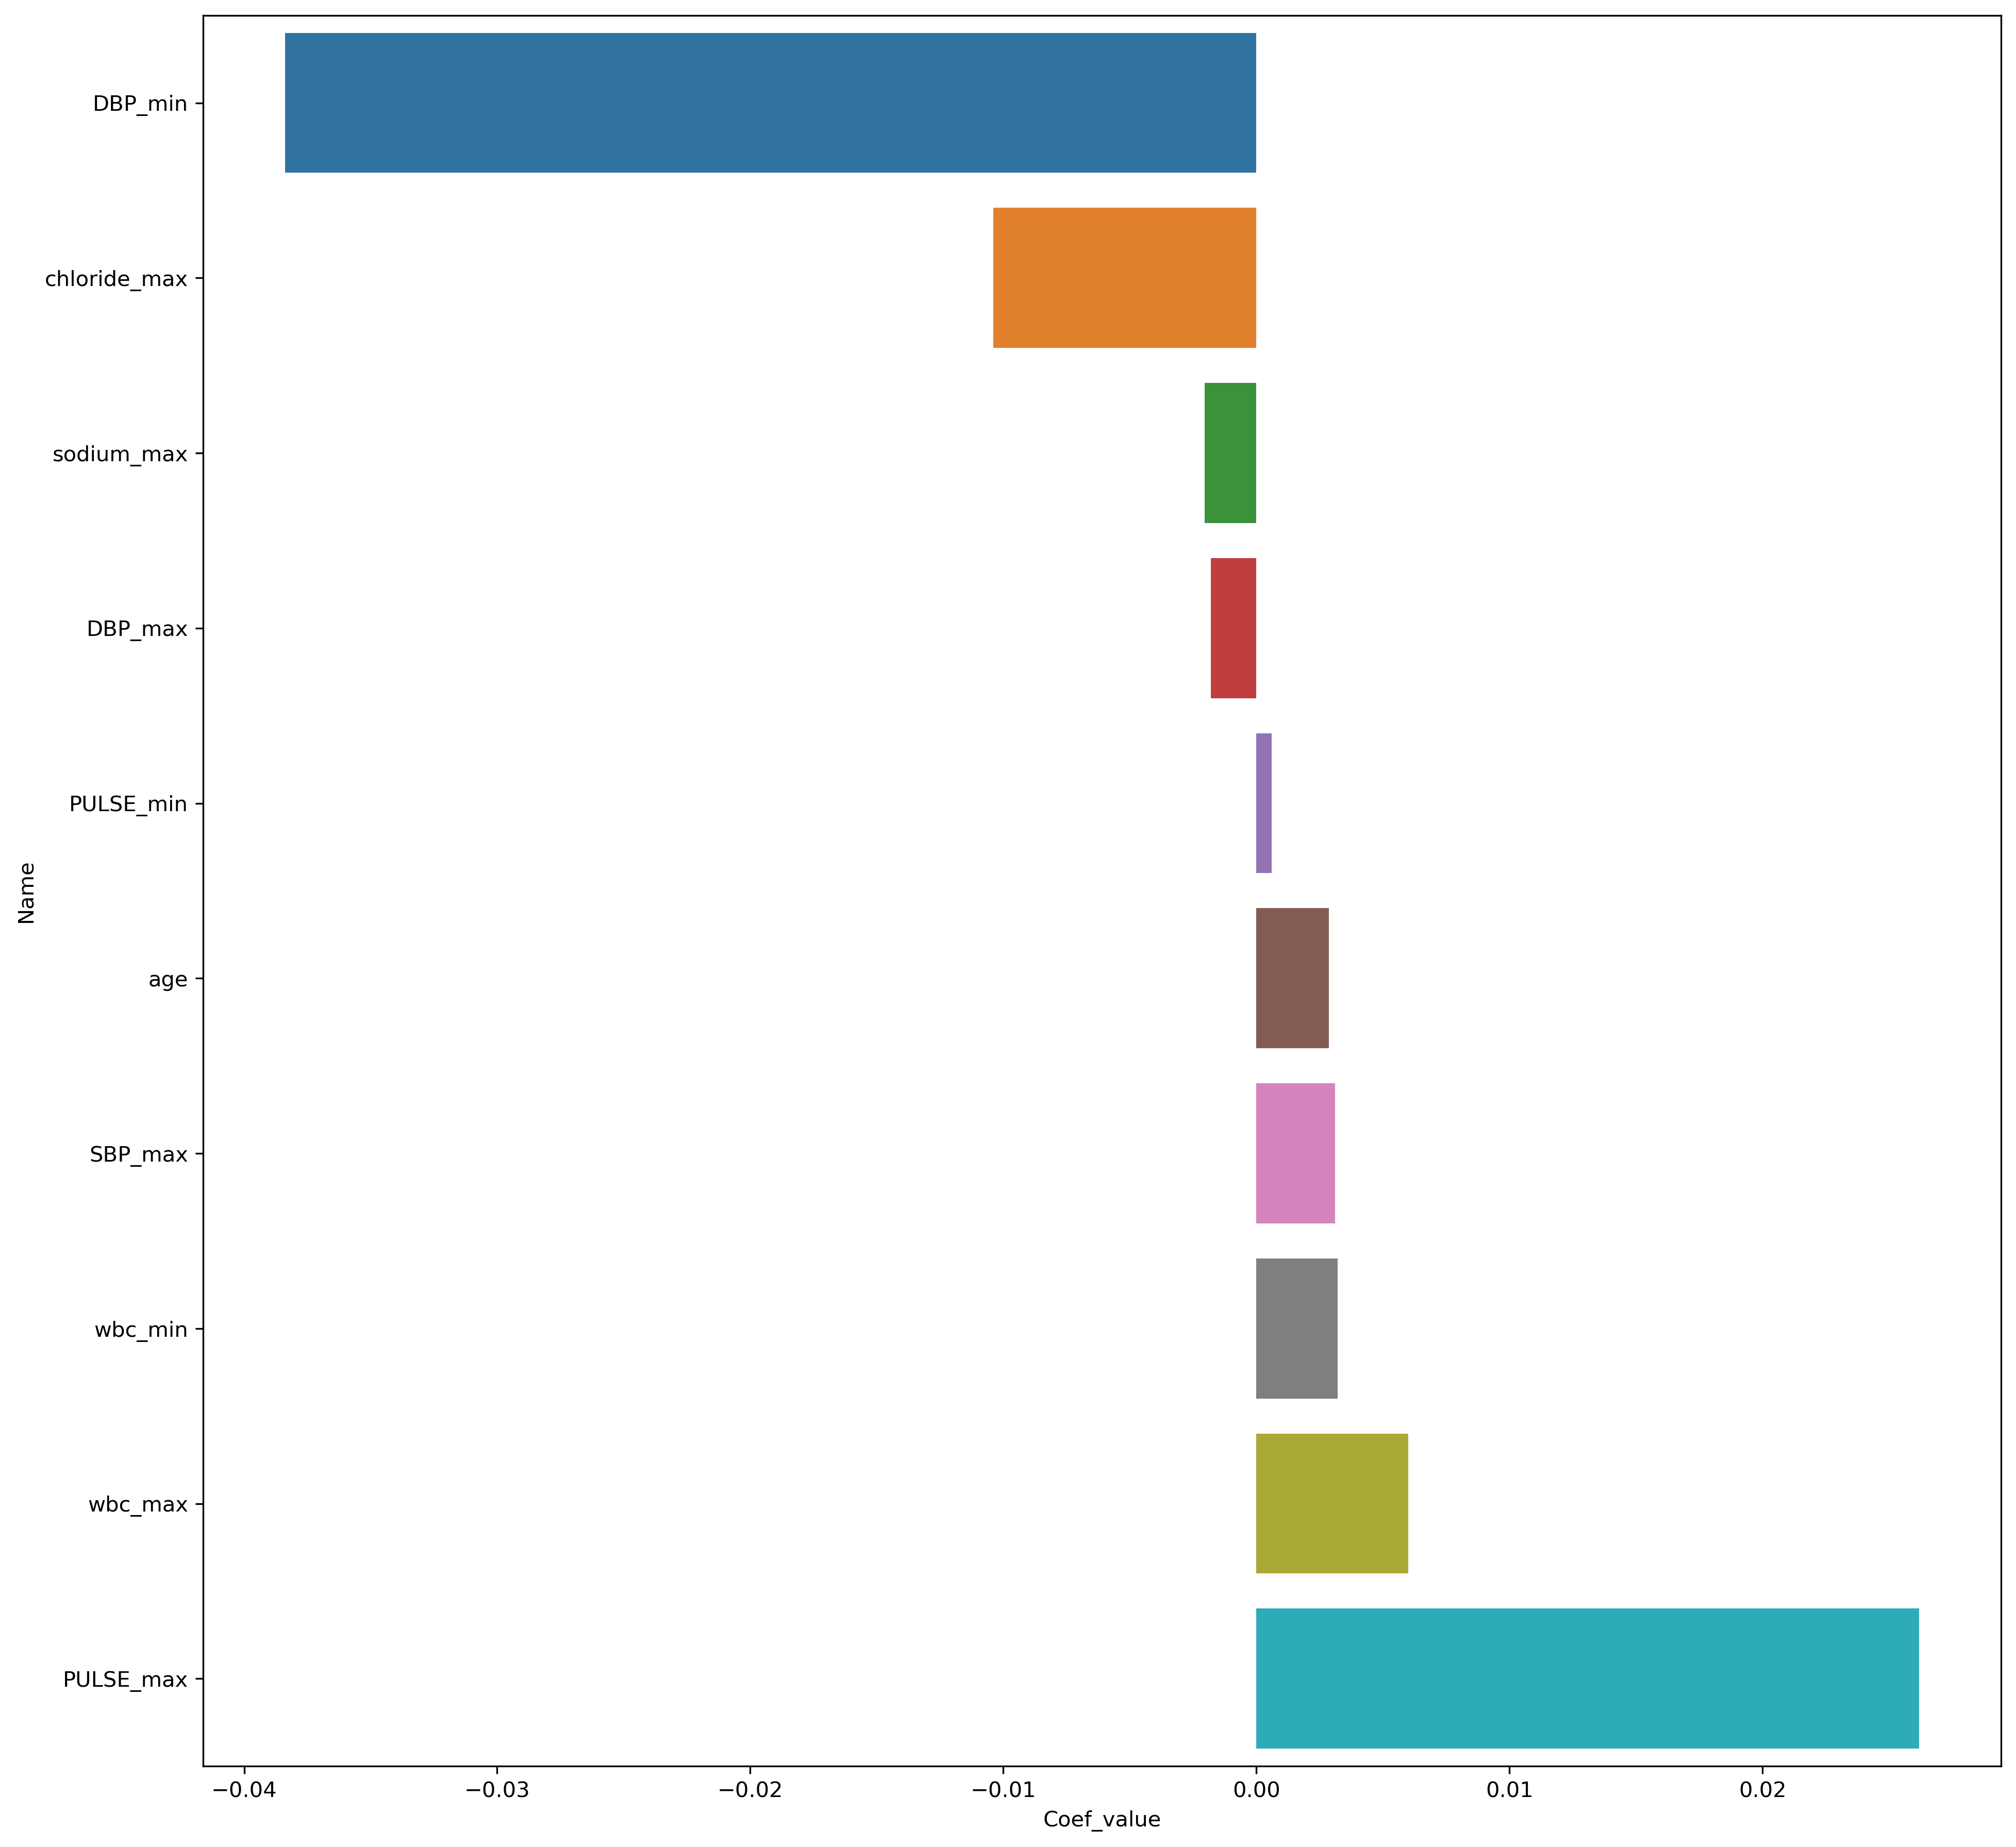

In [309]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

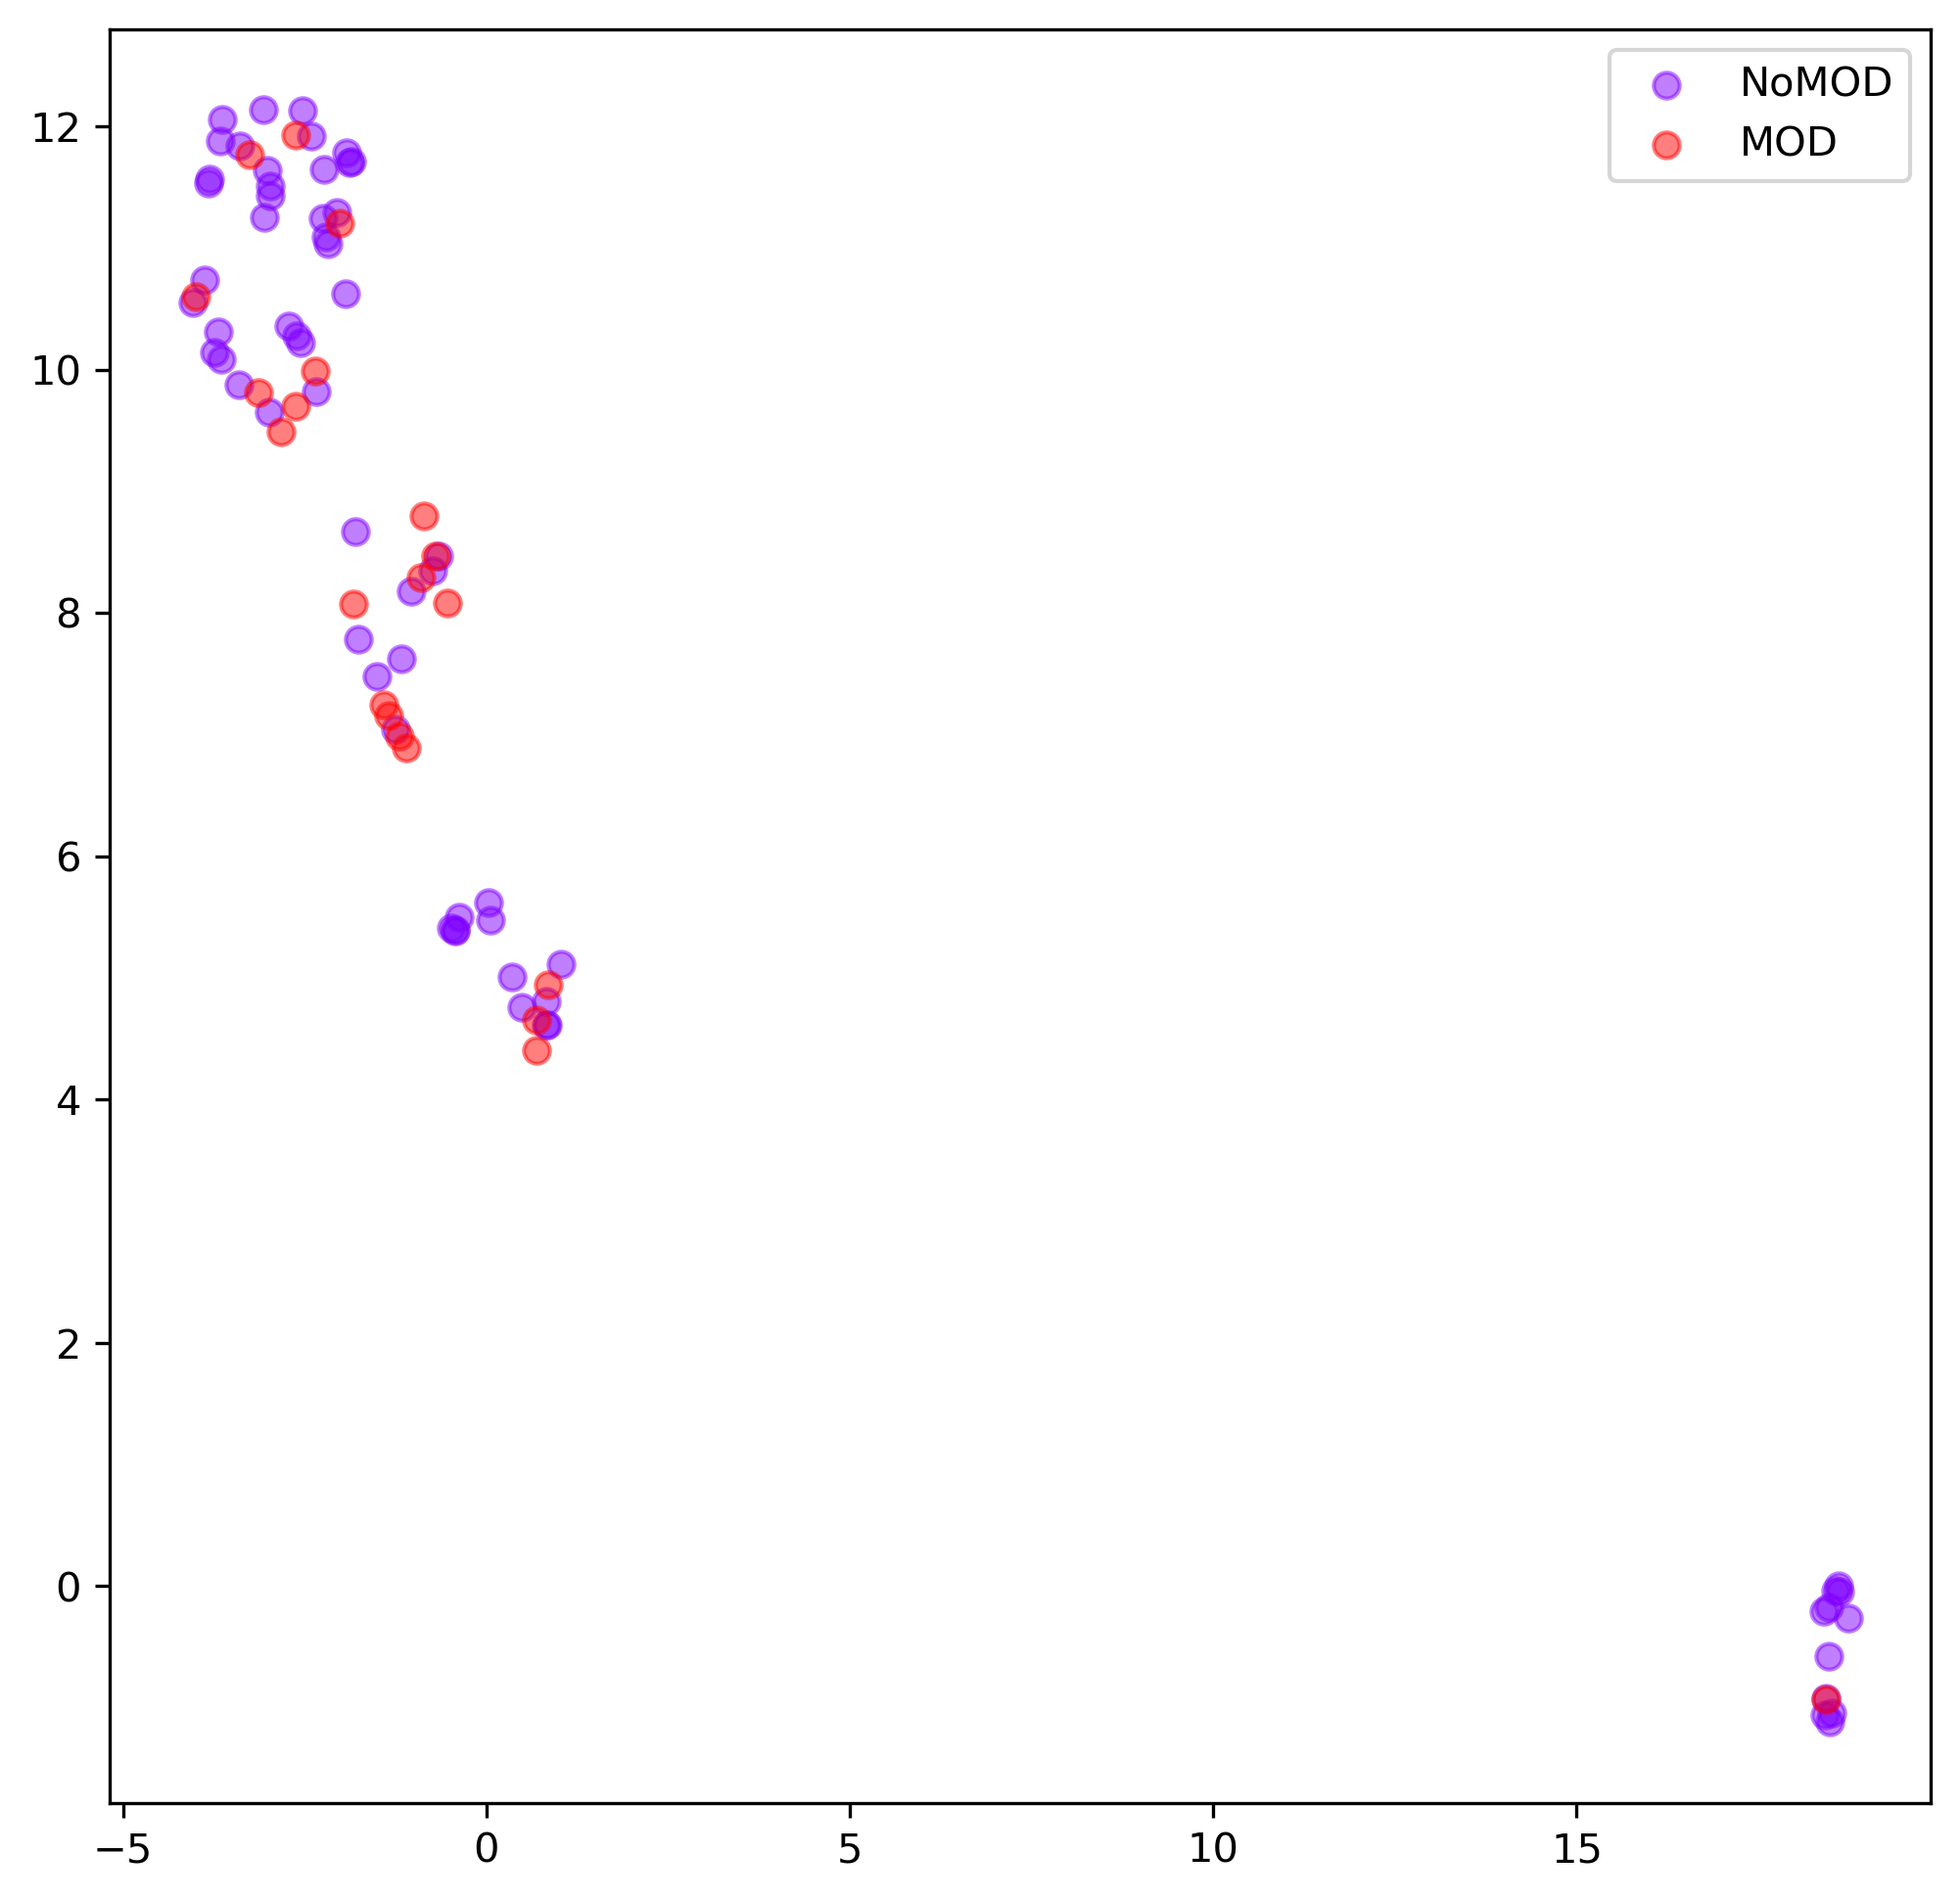

In [310]:
u = umap_plot_label(X[select_feats],y,1,7,['NoMOD','MOD']);

Cluster  1
MOD      5
NoMOD    4
Name: label, dtype: int64
Cluster  2
NoMOD    11
MOD       1
Name: label, dtype: int64
Cluster  3
NoMOD    10
MOD       1
Name: label, dtype: int64
Cluster  4
NoMOD    6
MOD      3
Name: label, dtype: int64
Cluster  5
NoMOD    11
MOD       5
Name: label, dtype: int64
Cluster  6
NoMOD    11
MOD       2
Name: label, dtype: int64
Cluster  7
NoMOD    6
Name: label, dtype: int64
Cluster  8
MOD      4
NoMOD    4
Name: label, dtype: int64


KMeans()

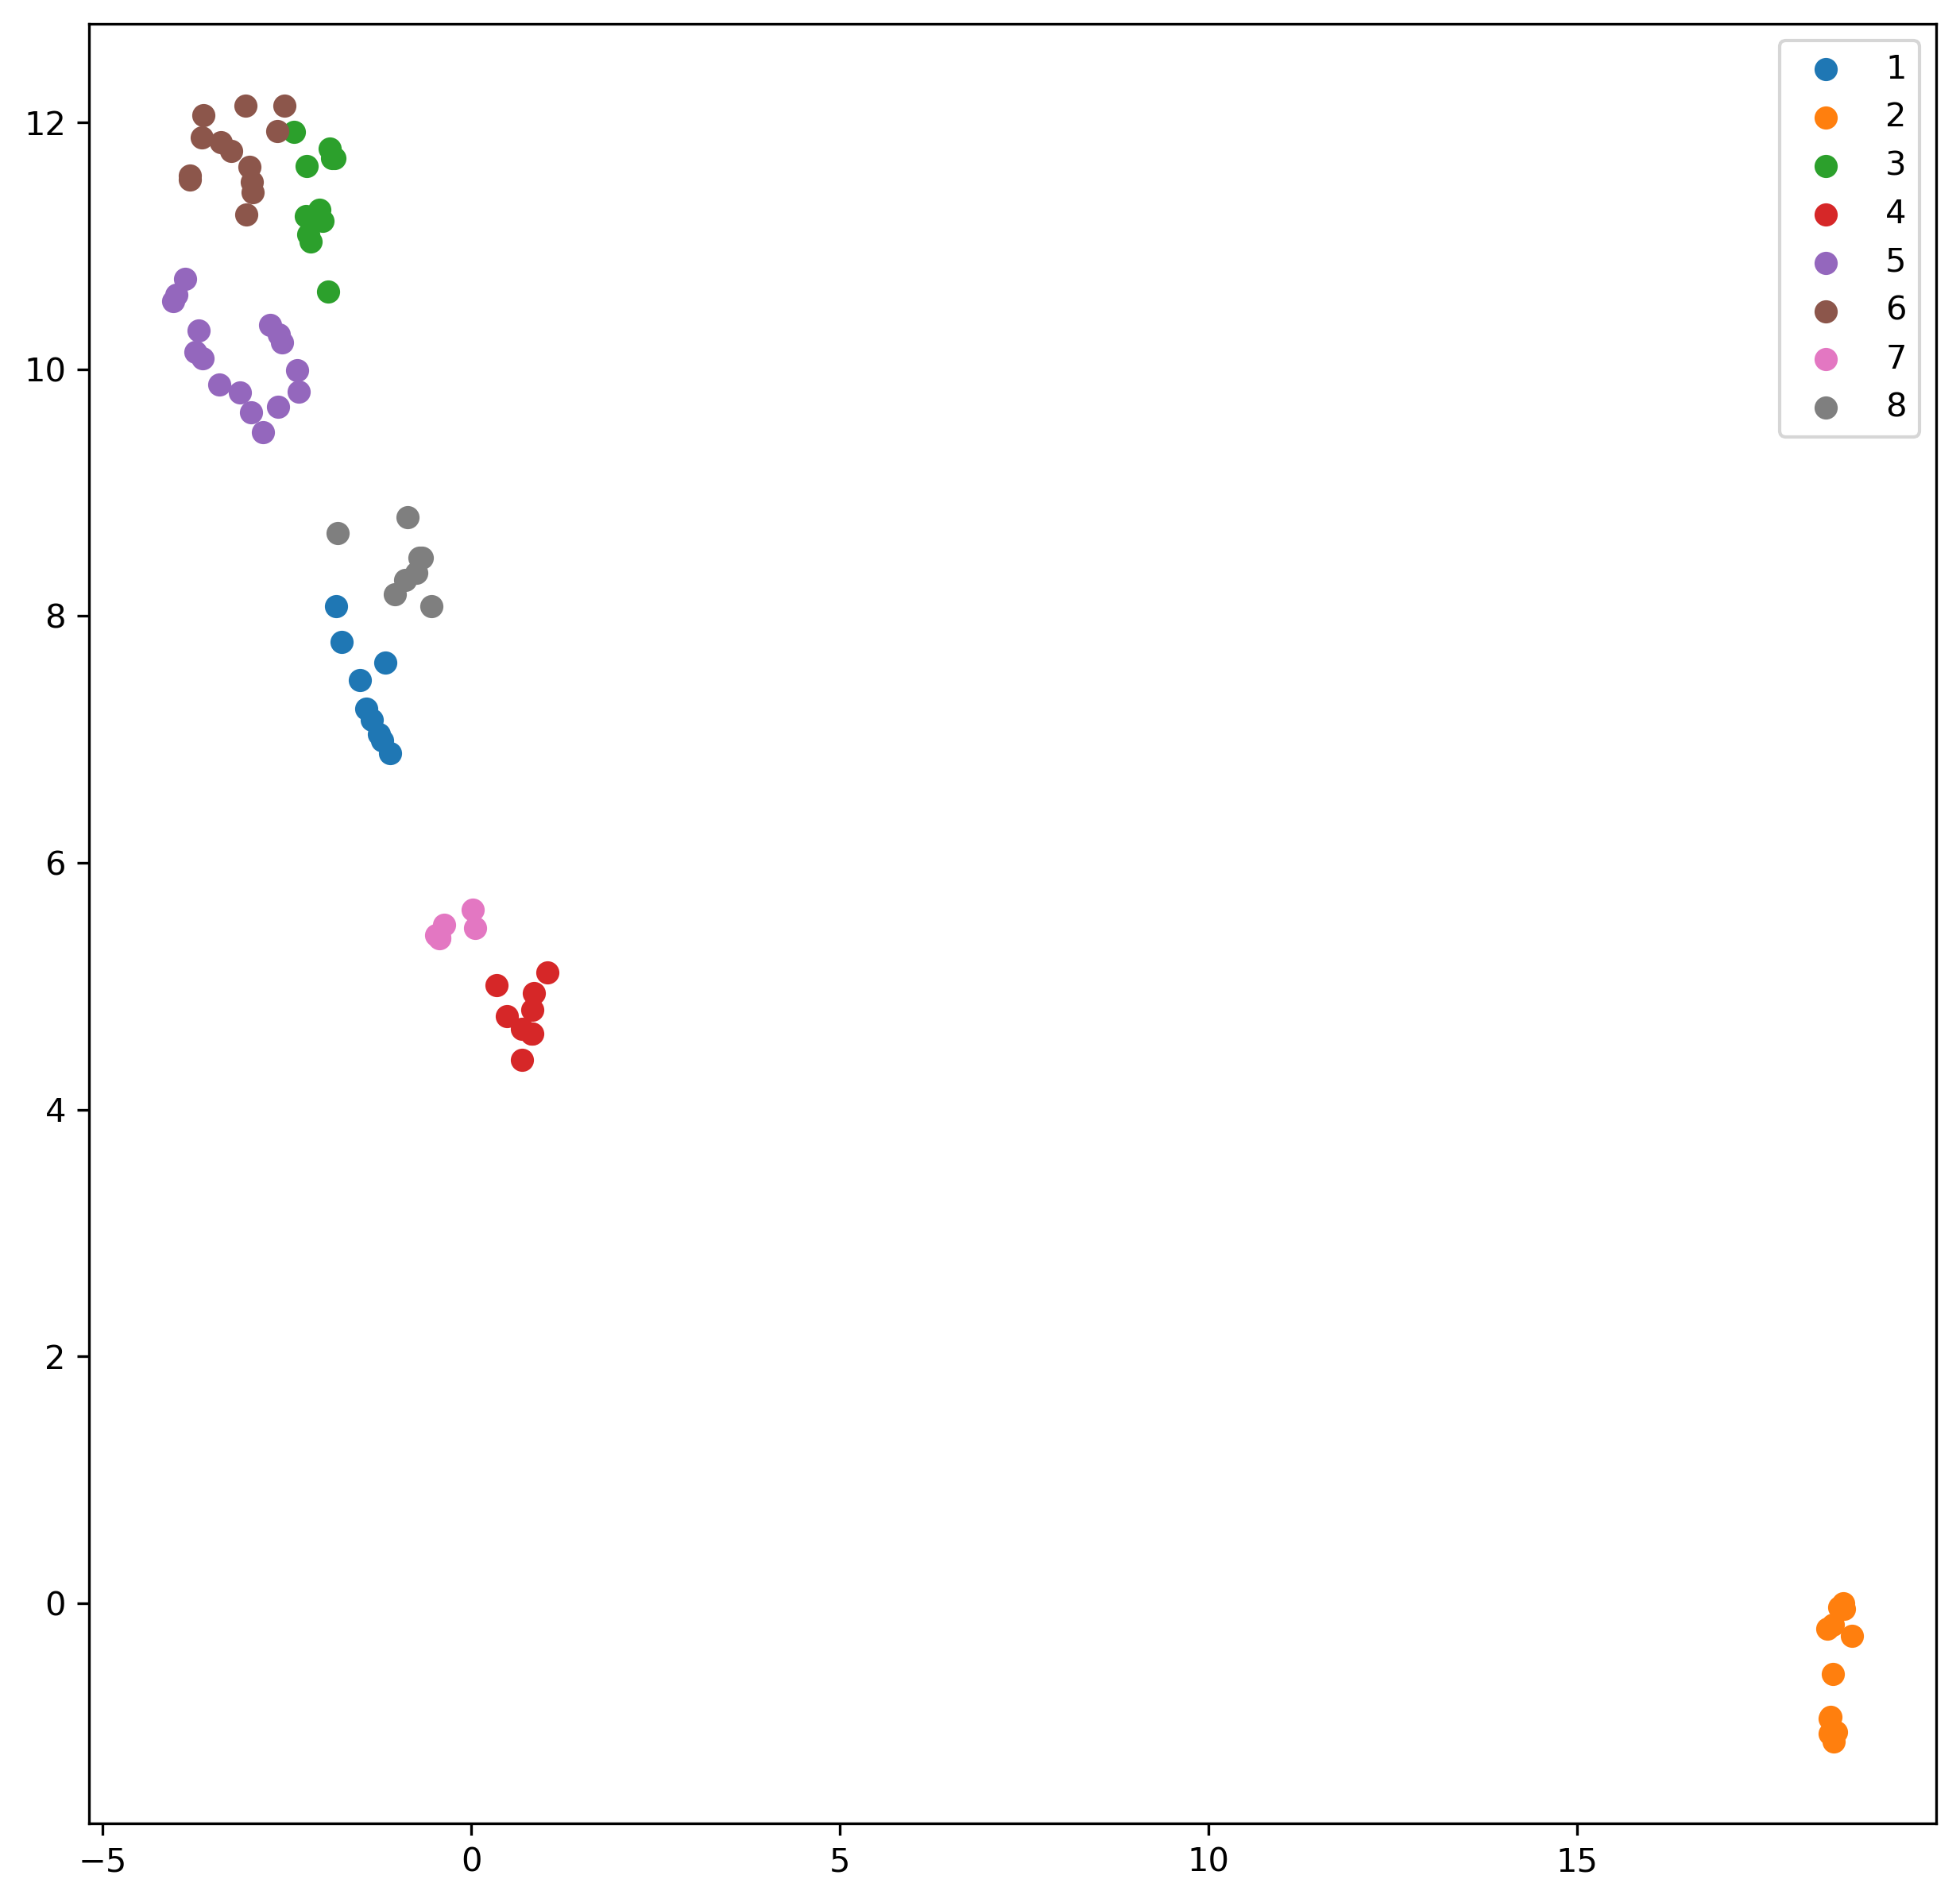

In [311]:
cmap = cluster_umap(u,8,clean_df3)
cmap

In [312]:
# characterize the points in these clusters by the selected features

clean_df3.iloc[cmap.labels_==5].groupby('label')[select_feats].describe().T

label                MOD       NoMOD
age     count   2.000000   11.000000
        mean   68.524997   62.250565
        std     4.436810   16.116836
        min    65.387699   37.424346
        25%    66.956348   48.902302
...                  ...         ...
DBP_min min    70.000000   69.000000
        25%    74.250000   72.000000
        50%    78.500000   79.000000
        75%    82.750000   86.500000
        max    87.000000  102.000000

[80 rows x 2 columns]

In [313]:
xr_df_labeled.columns

Index(['PtSSN', 'num_xr', 'num_abnormal_xr', 'label'], dtype='object')

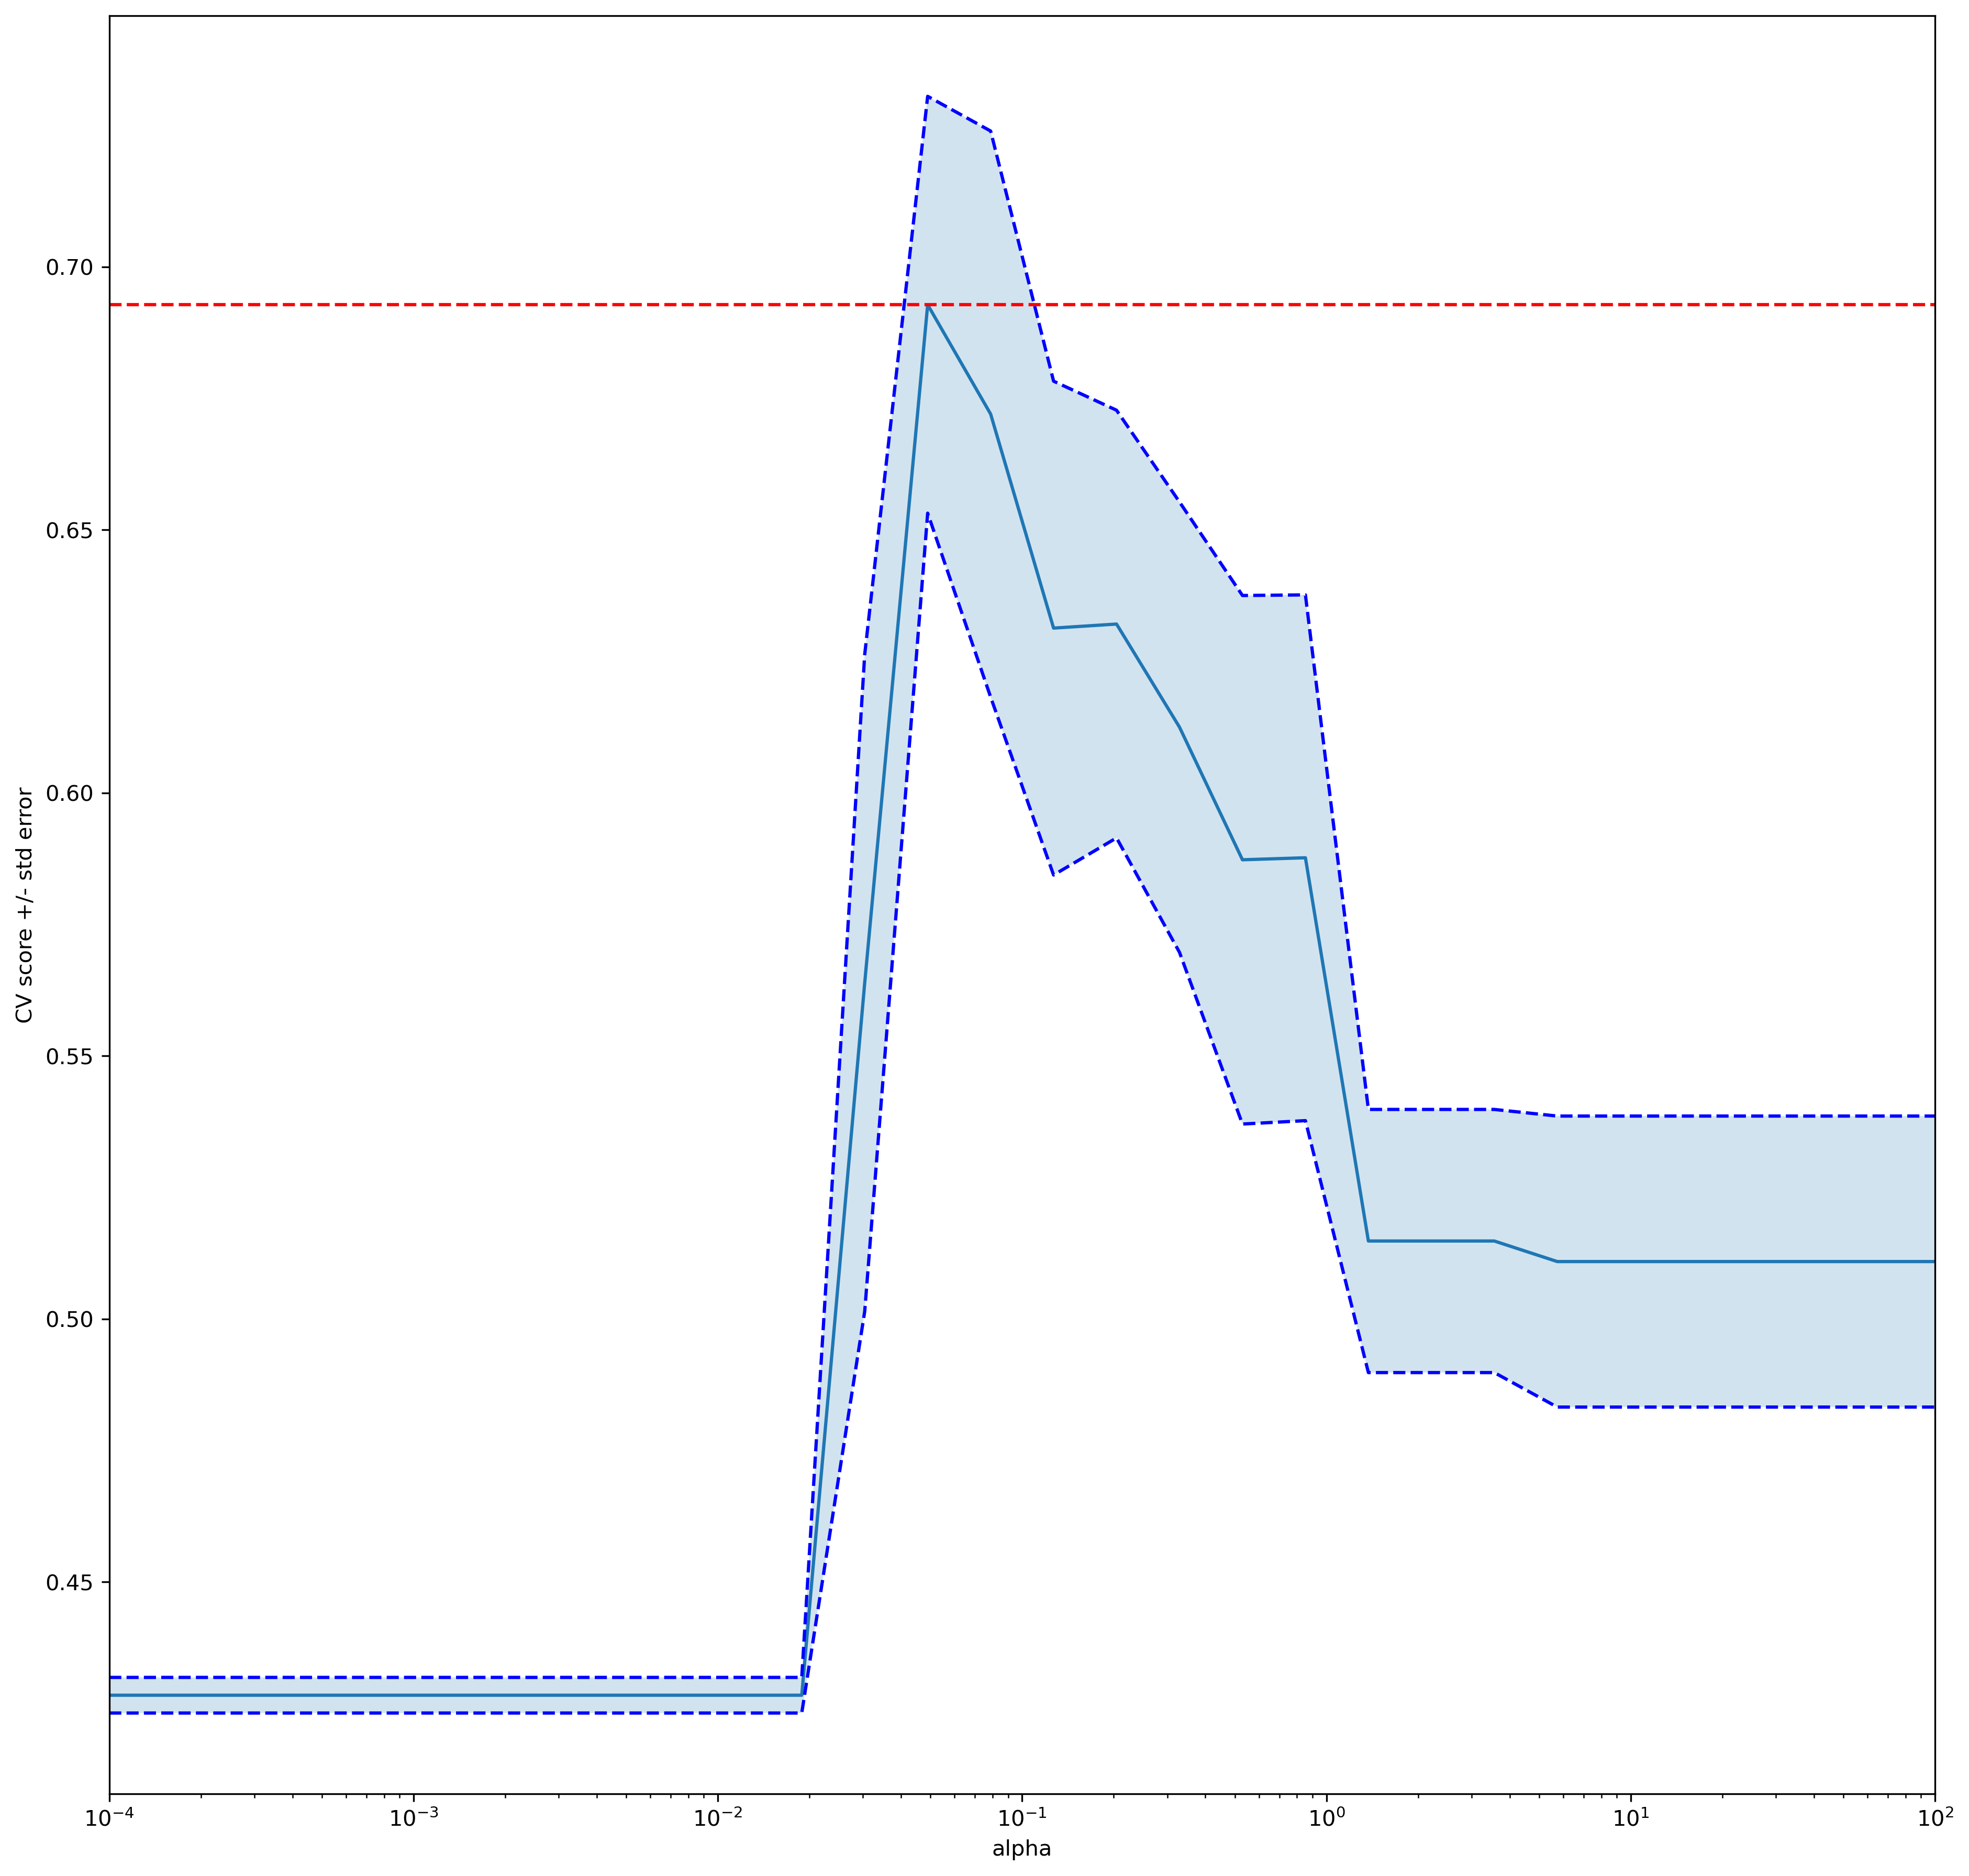

In [314]:
# now take clean_df3 and add imaging data
xr_cols = ['num_xr','num_abnormal_xr']
ct_cols = ['num_ct','num_abnormal_ct','num_contrast']
us_cols = ['num_us']

df4 = pd.merge(clean_df3,xr_df_labeled[['PtSSN','label'] + xr_cols],on=['PtSSN','label'])
df4 = pd.merge(df4,ct_df_labeled[['PtSSN','label'] + ct_cols],on=['PtSSN','label'])
df4 = pd.merge(df4,us_df_labeled[['PtSSN','label'] + us_cols],on=['PtSSN','label'])

clean_df4 = df4.dropna()
X = clean_df4[clean_df4.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in clean_df4['label']])

clf = tune_model(X,y)

(84, 42) (84,)
AUC =  0.6916025641025643 0.18517414551796996
F1 =  0.6928085133257547 0.08859720244650383
Accuracy =  0.8102941176470587 0.08529411764705881
Confusion matrix:
[[63  0]
 [15  6]]
10  features chosen by L1 model.


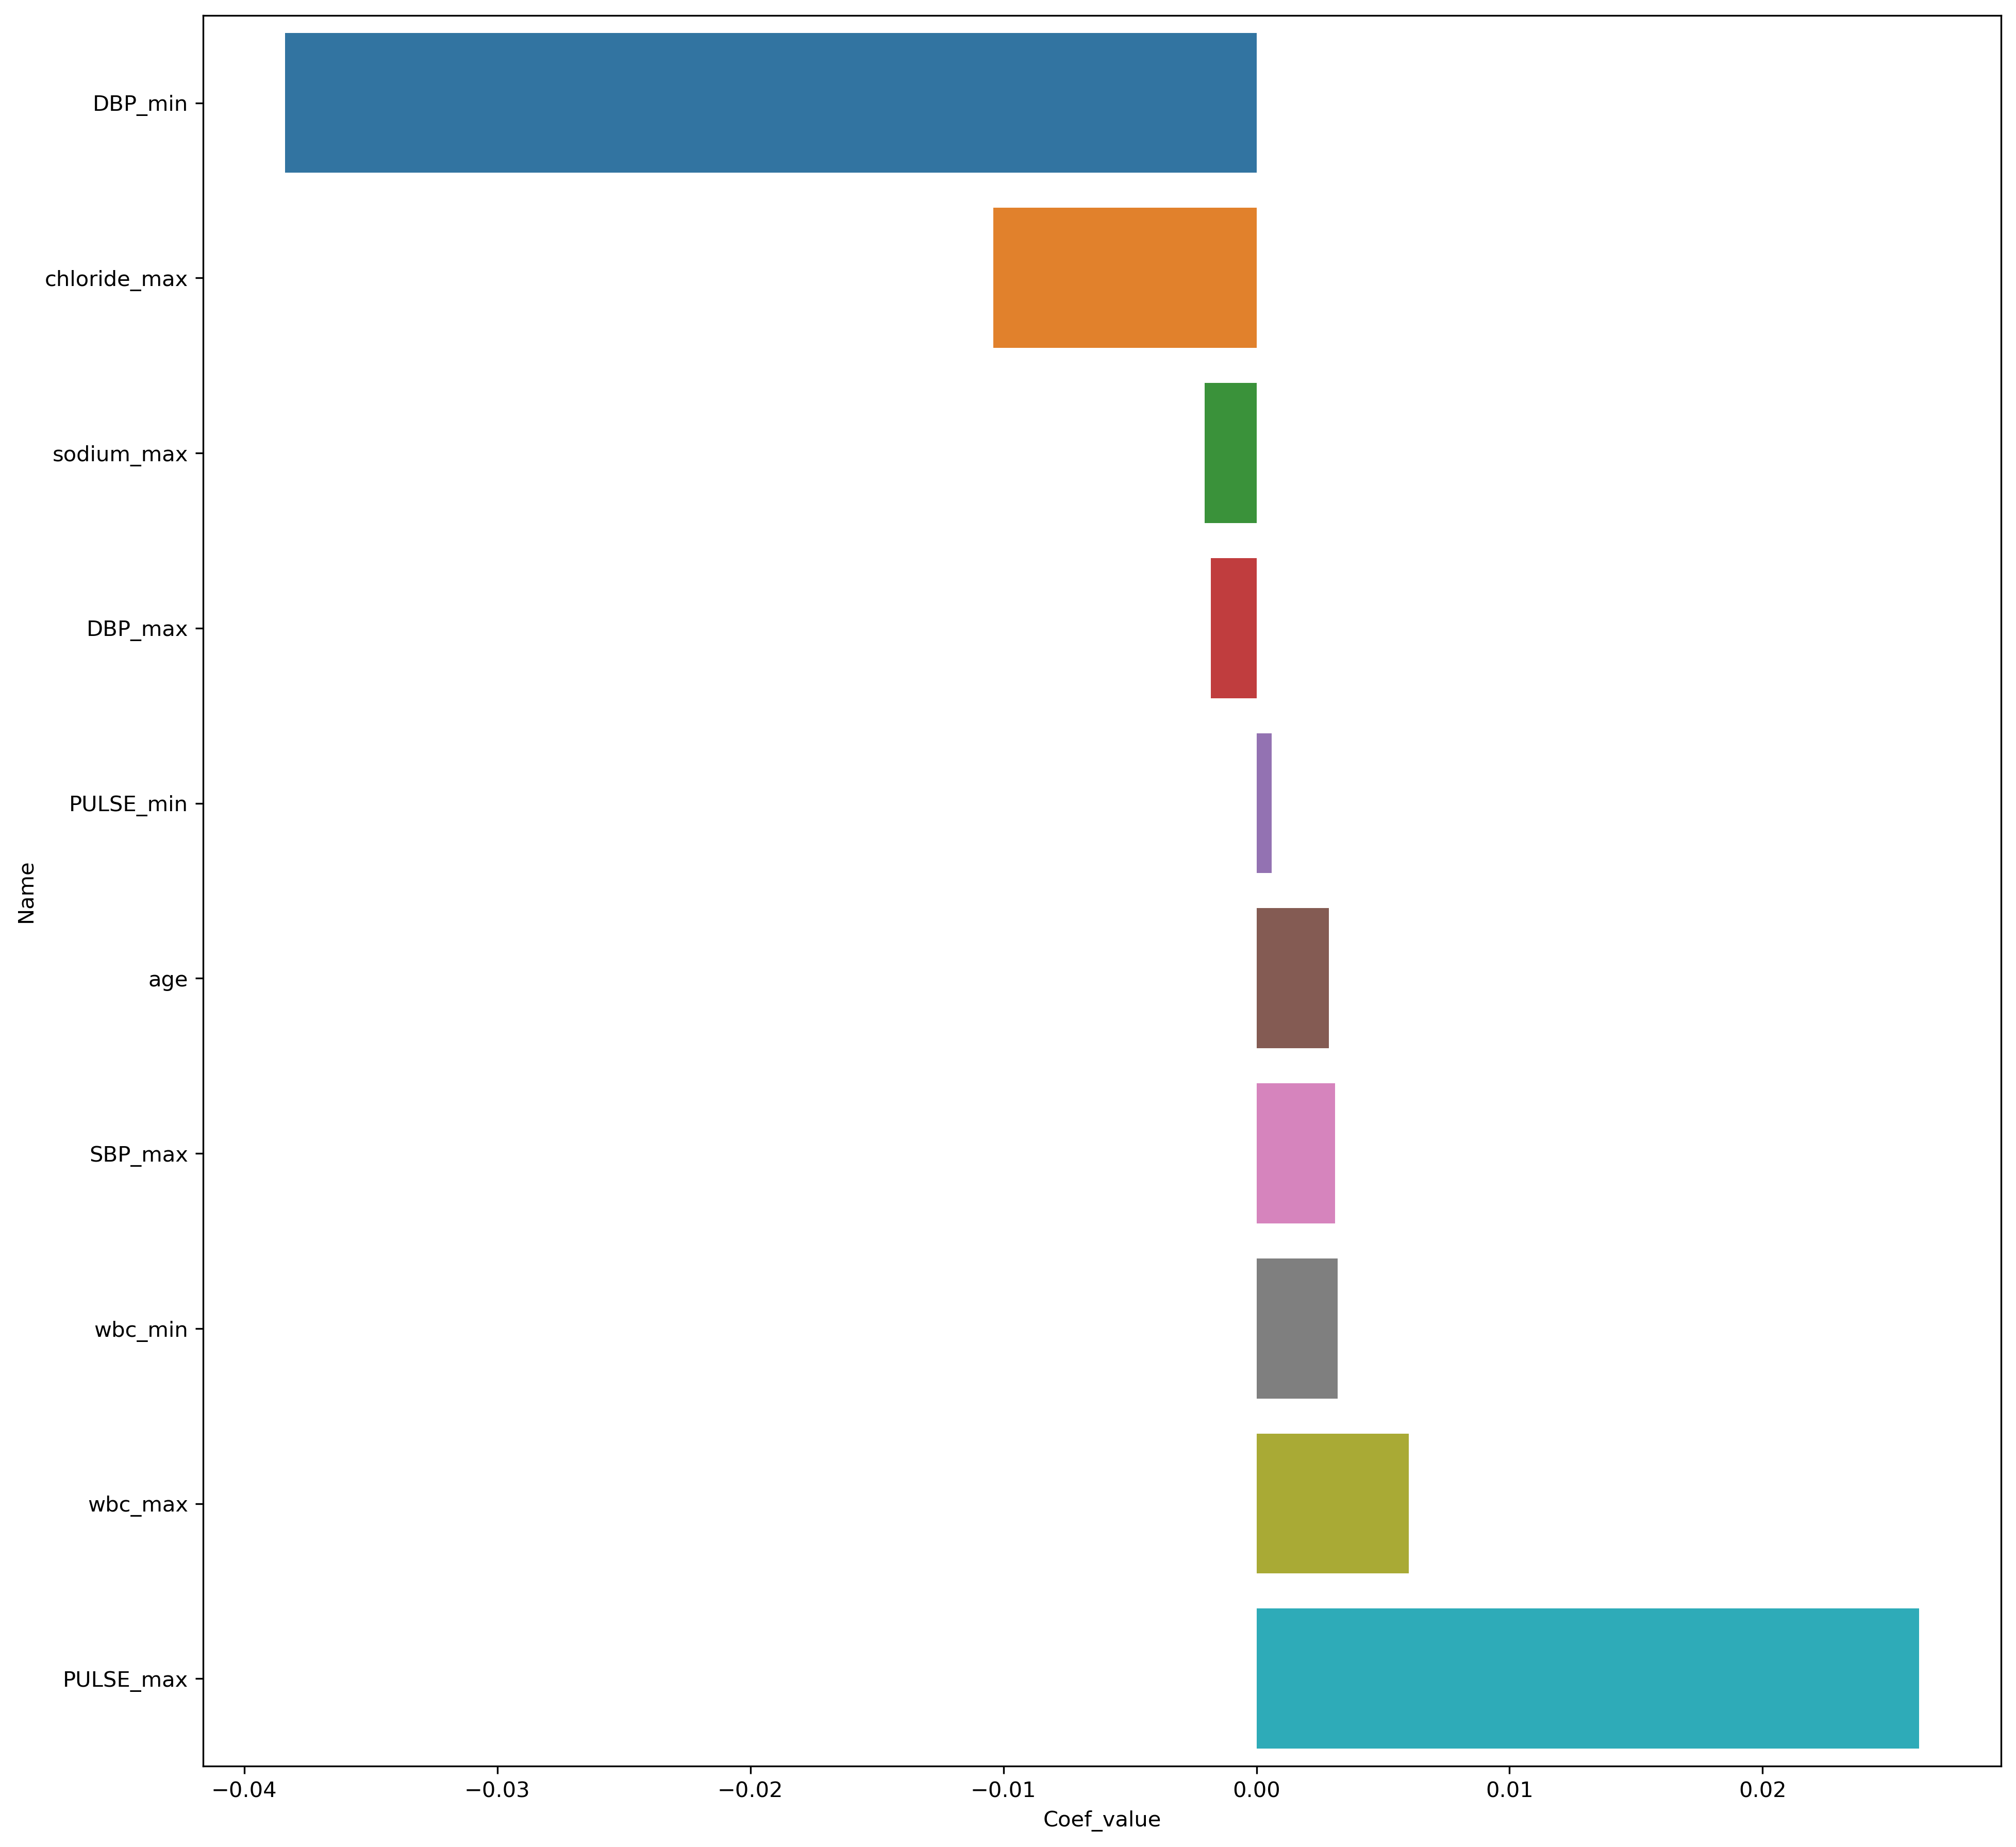

In [315]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

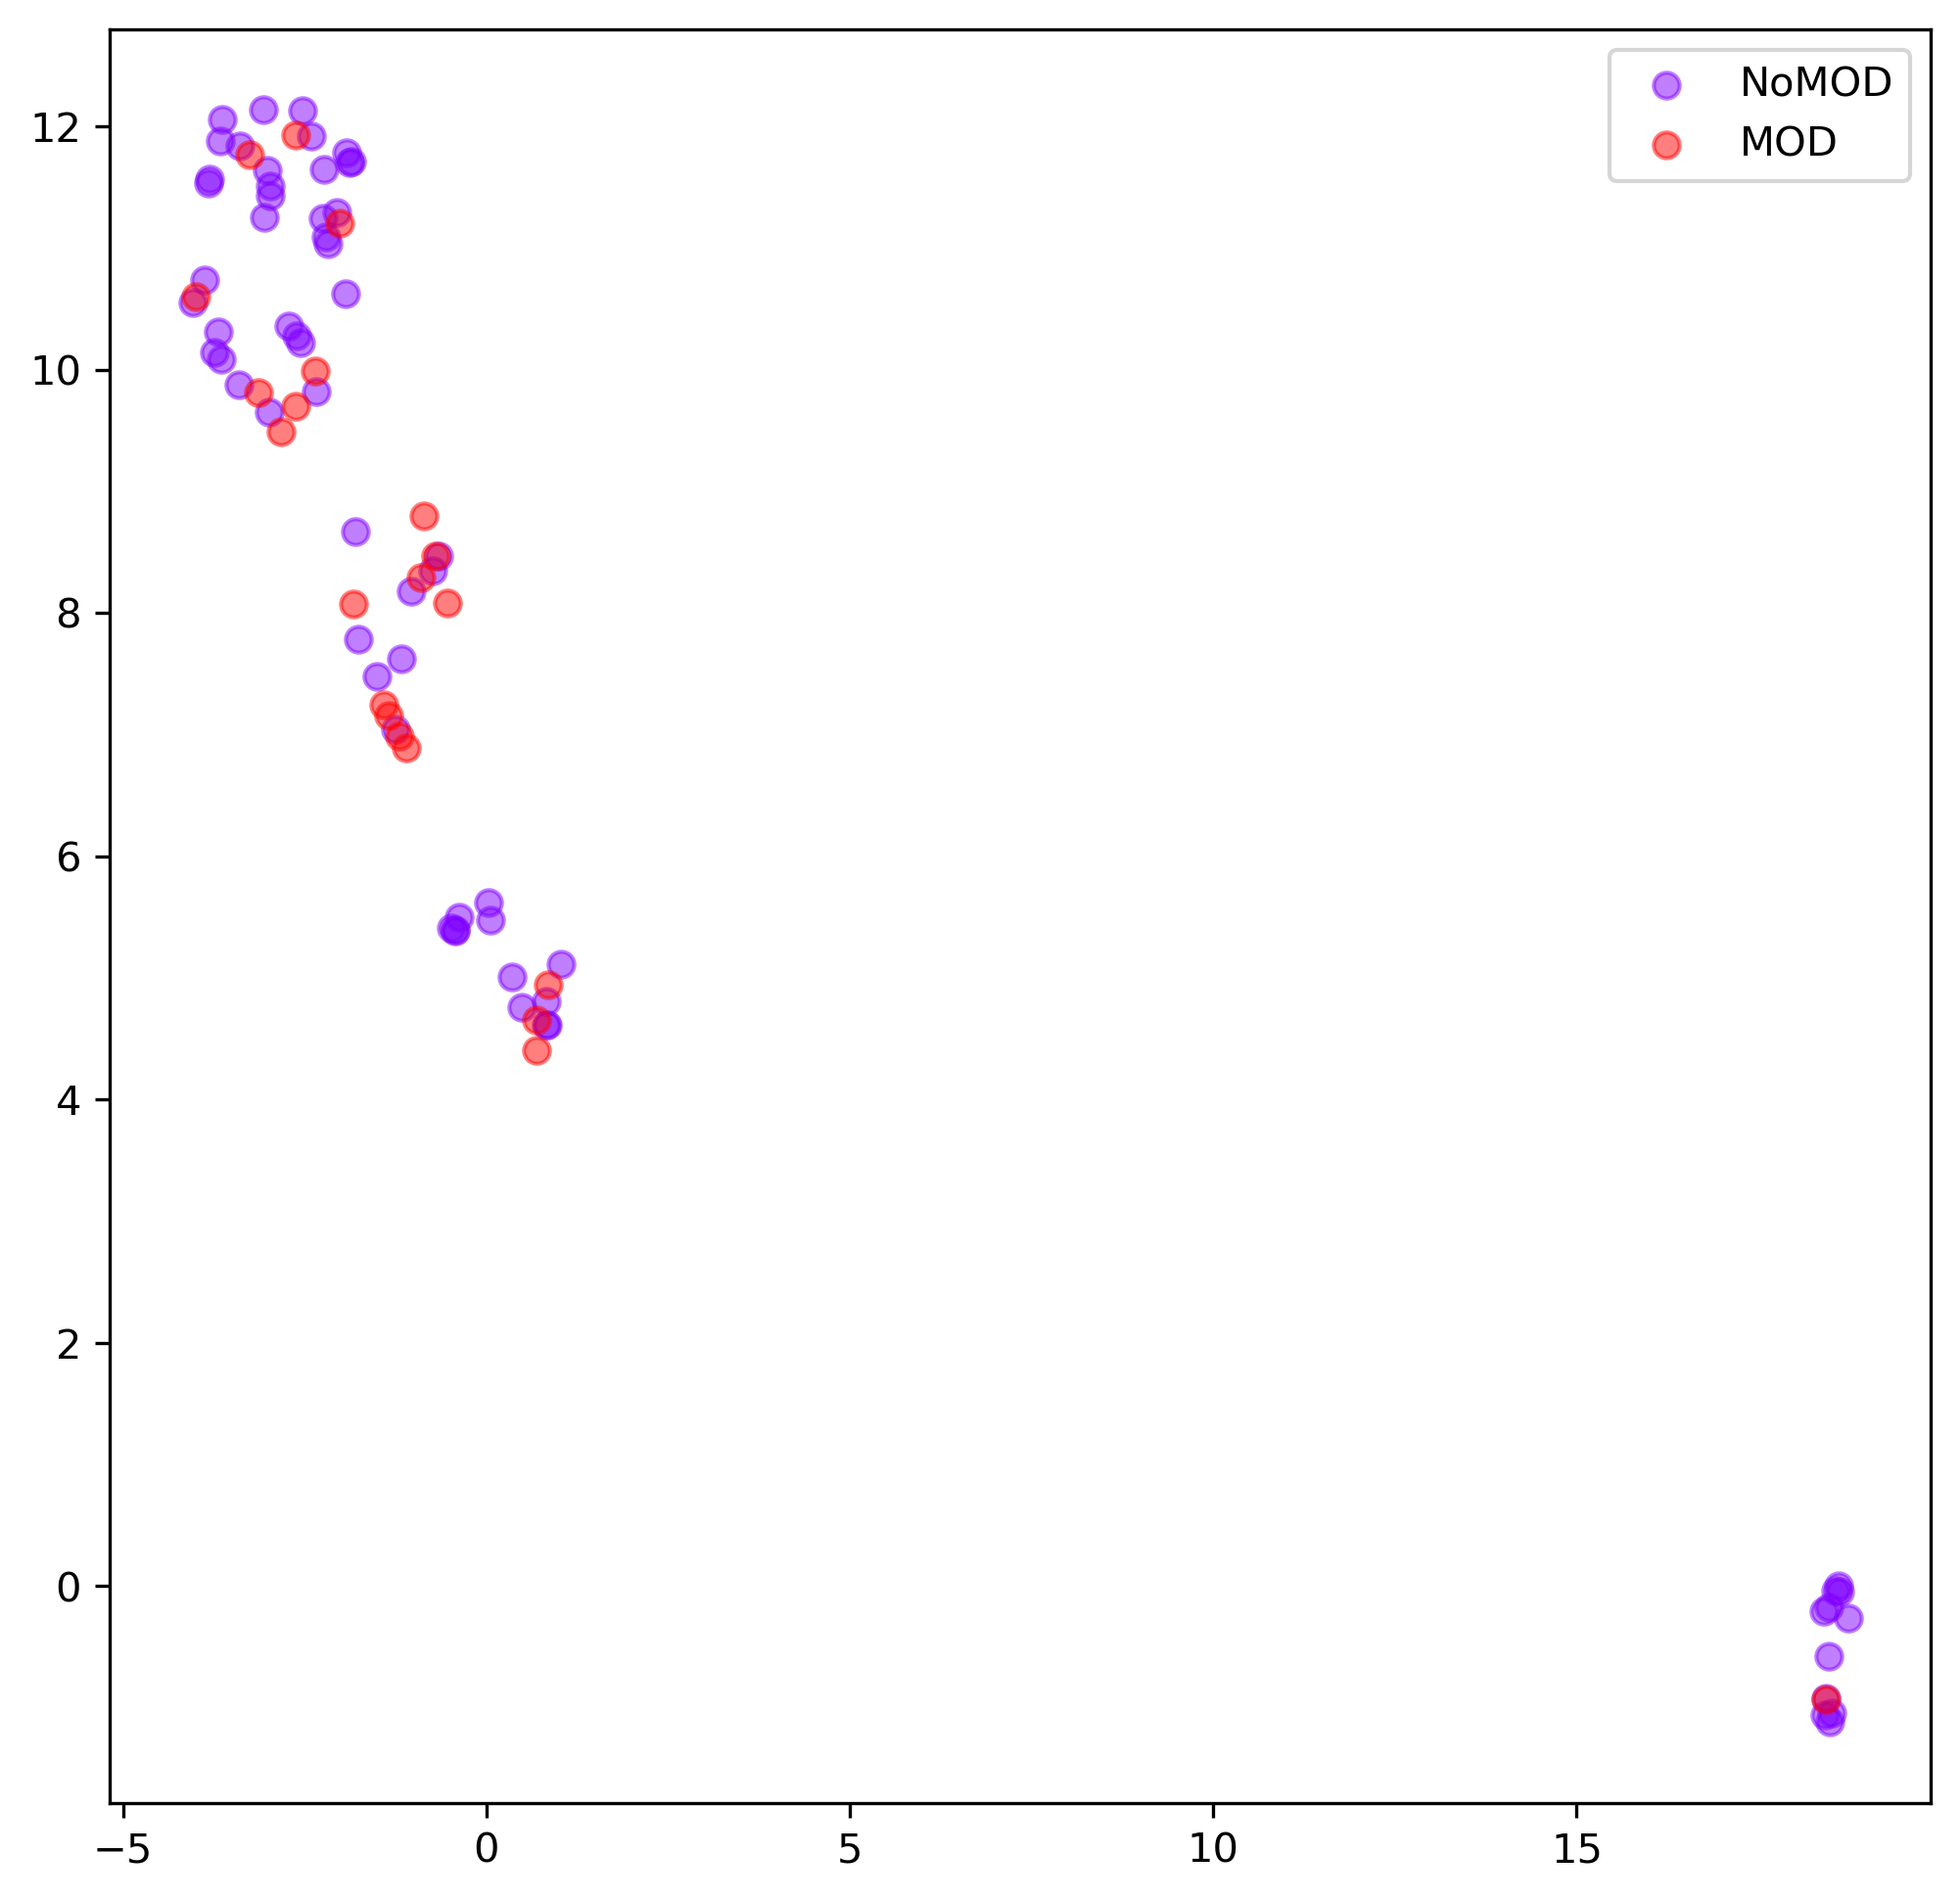

In [316]:
umap_plot_label(X[select_feats],y,1,7,['NoMOD','MOD']);

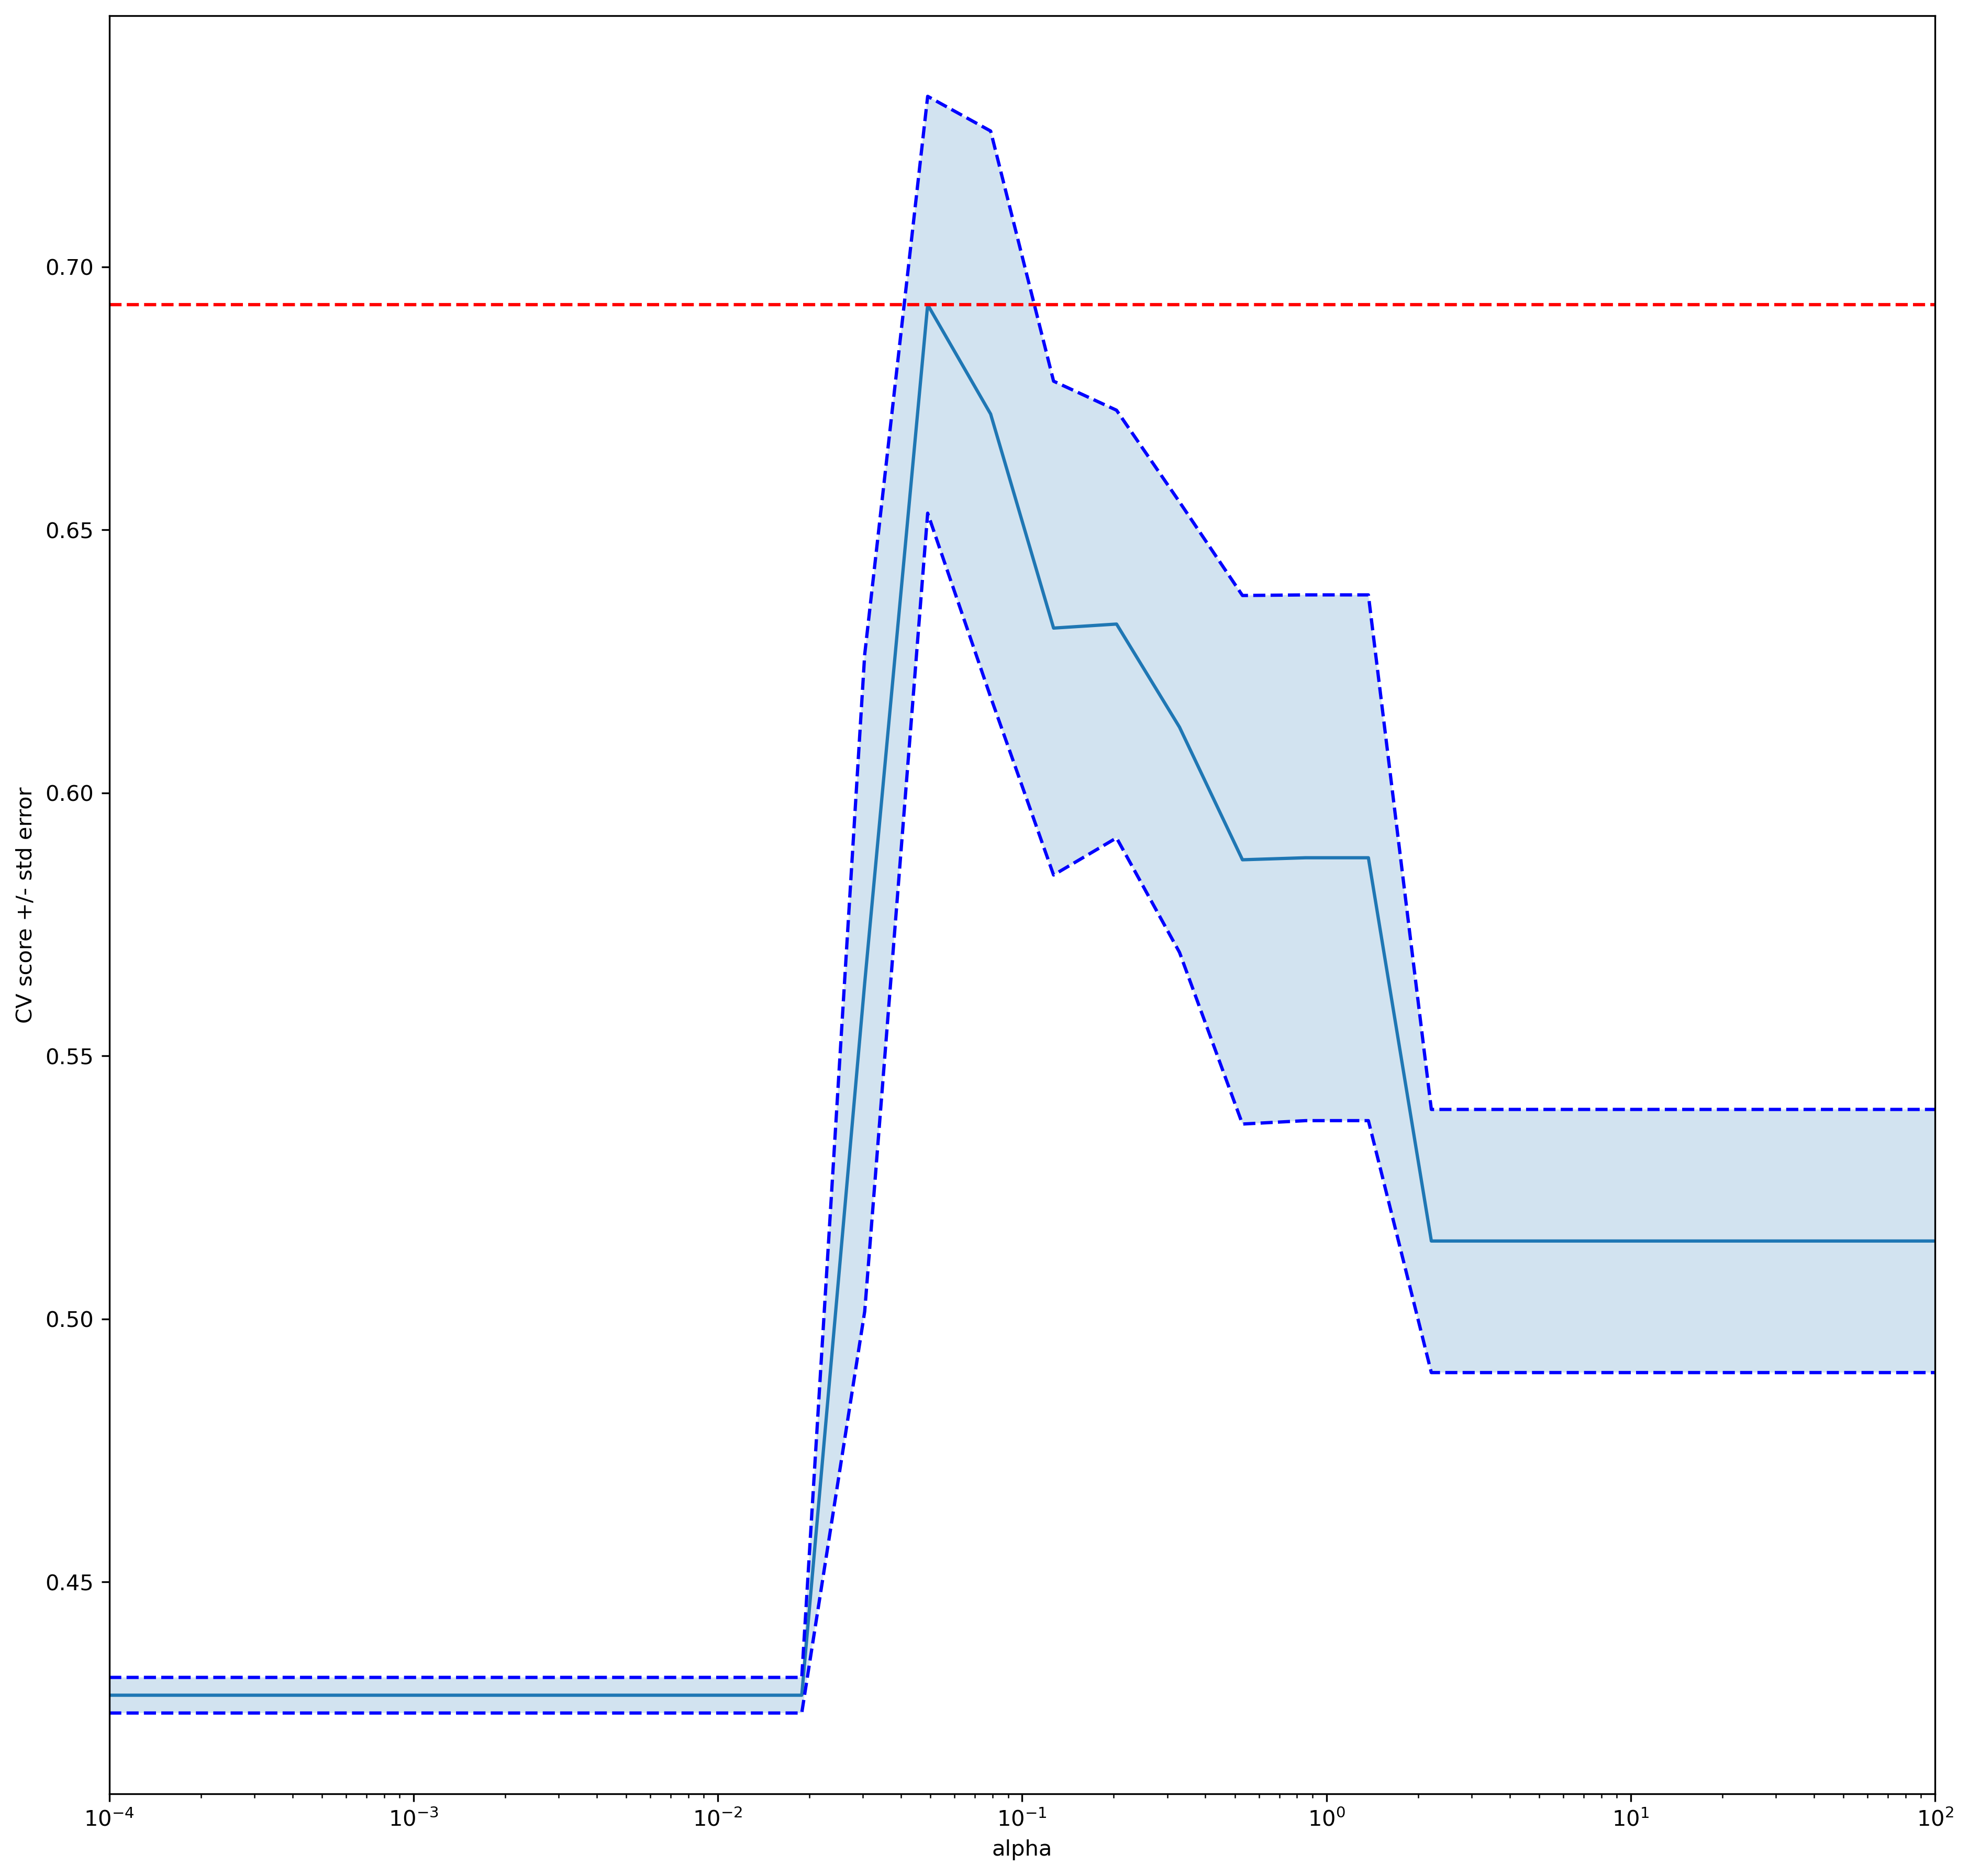

In [317]:
# add AbdominalSurgery from abpain_df

abpain_df_col = ['PMHAbdSurgery']

df5 = pd.merge(clean_df4,abpain_df[['PtSSN']+abpain_df_col],on='PtSSN')
df5.PMHAbdSurgery = df5.PMHAbdSurgery.apply(lambda x: 0 if x=='No' else 1)

X = df5[df5.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df5['label']])

clf = tune_model(X,y)

(84, 43) (84,)
AUC =  0.6916025641025643 0.18517414551796996
F1 =  0.6928085133257547 0.08859720244650383
Accuracy =  0.8102941176470587 0.08529411764705881
Confusion matrix:
[[63  0]
 [15  6]]
10  features chosen by L1 model.


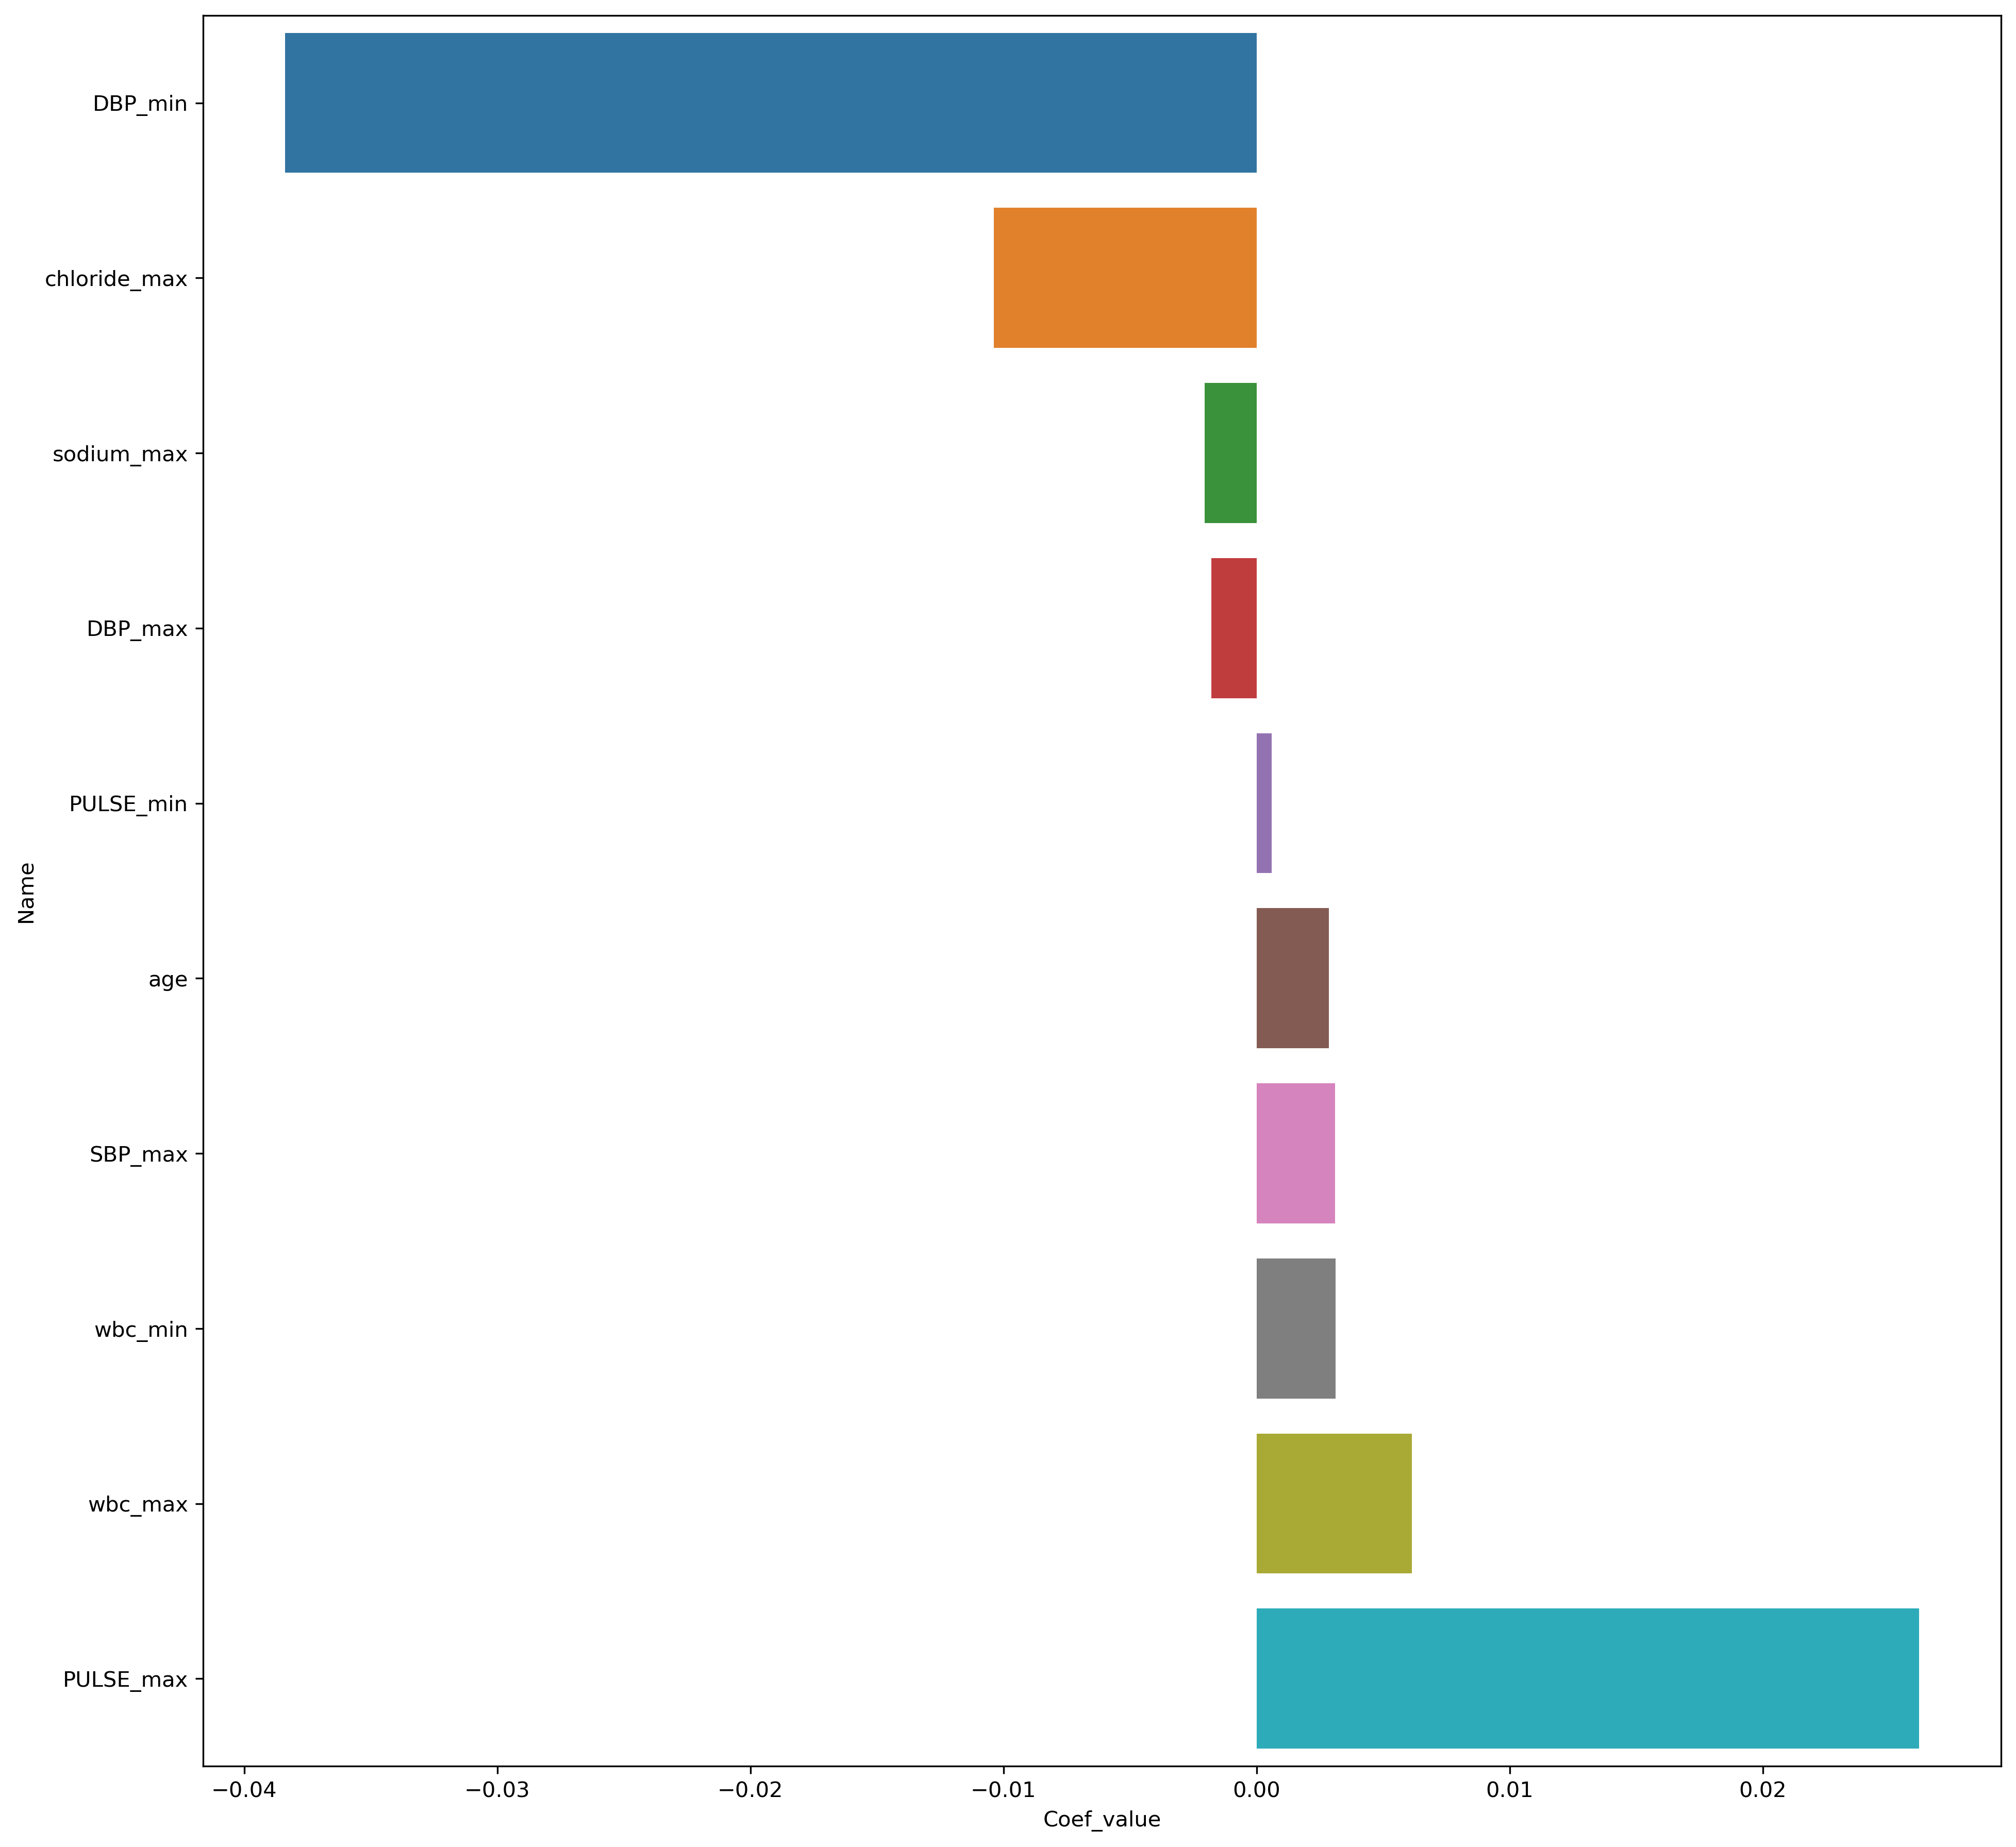

In [318]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

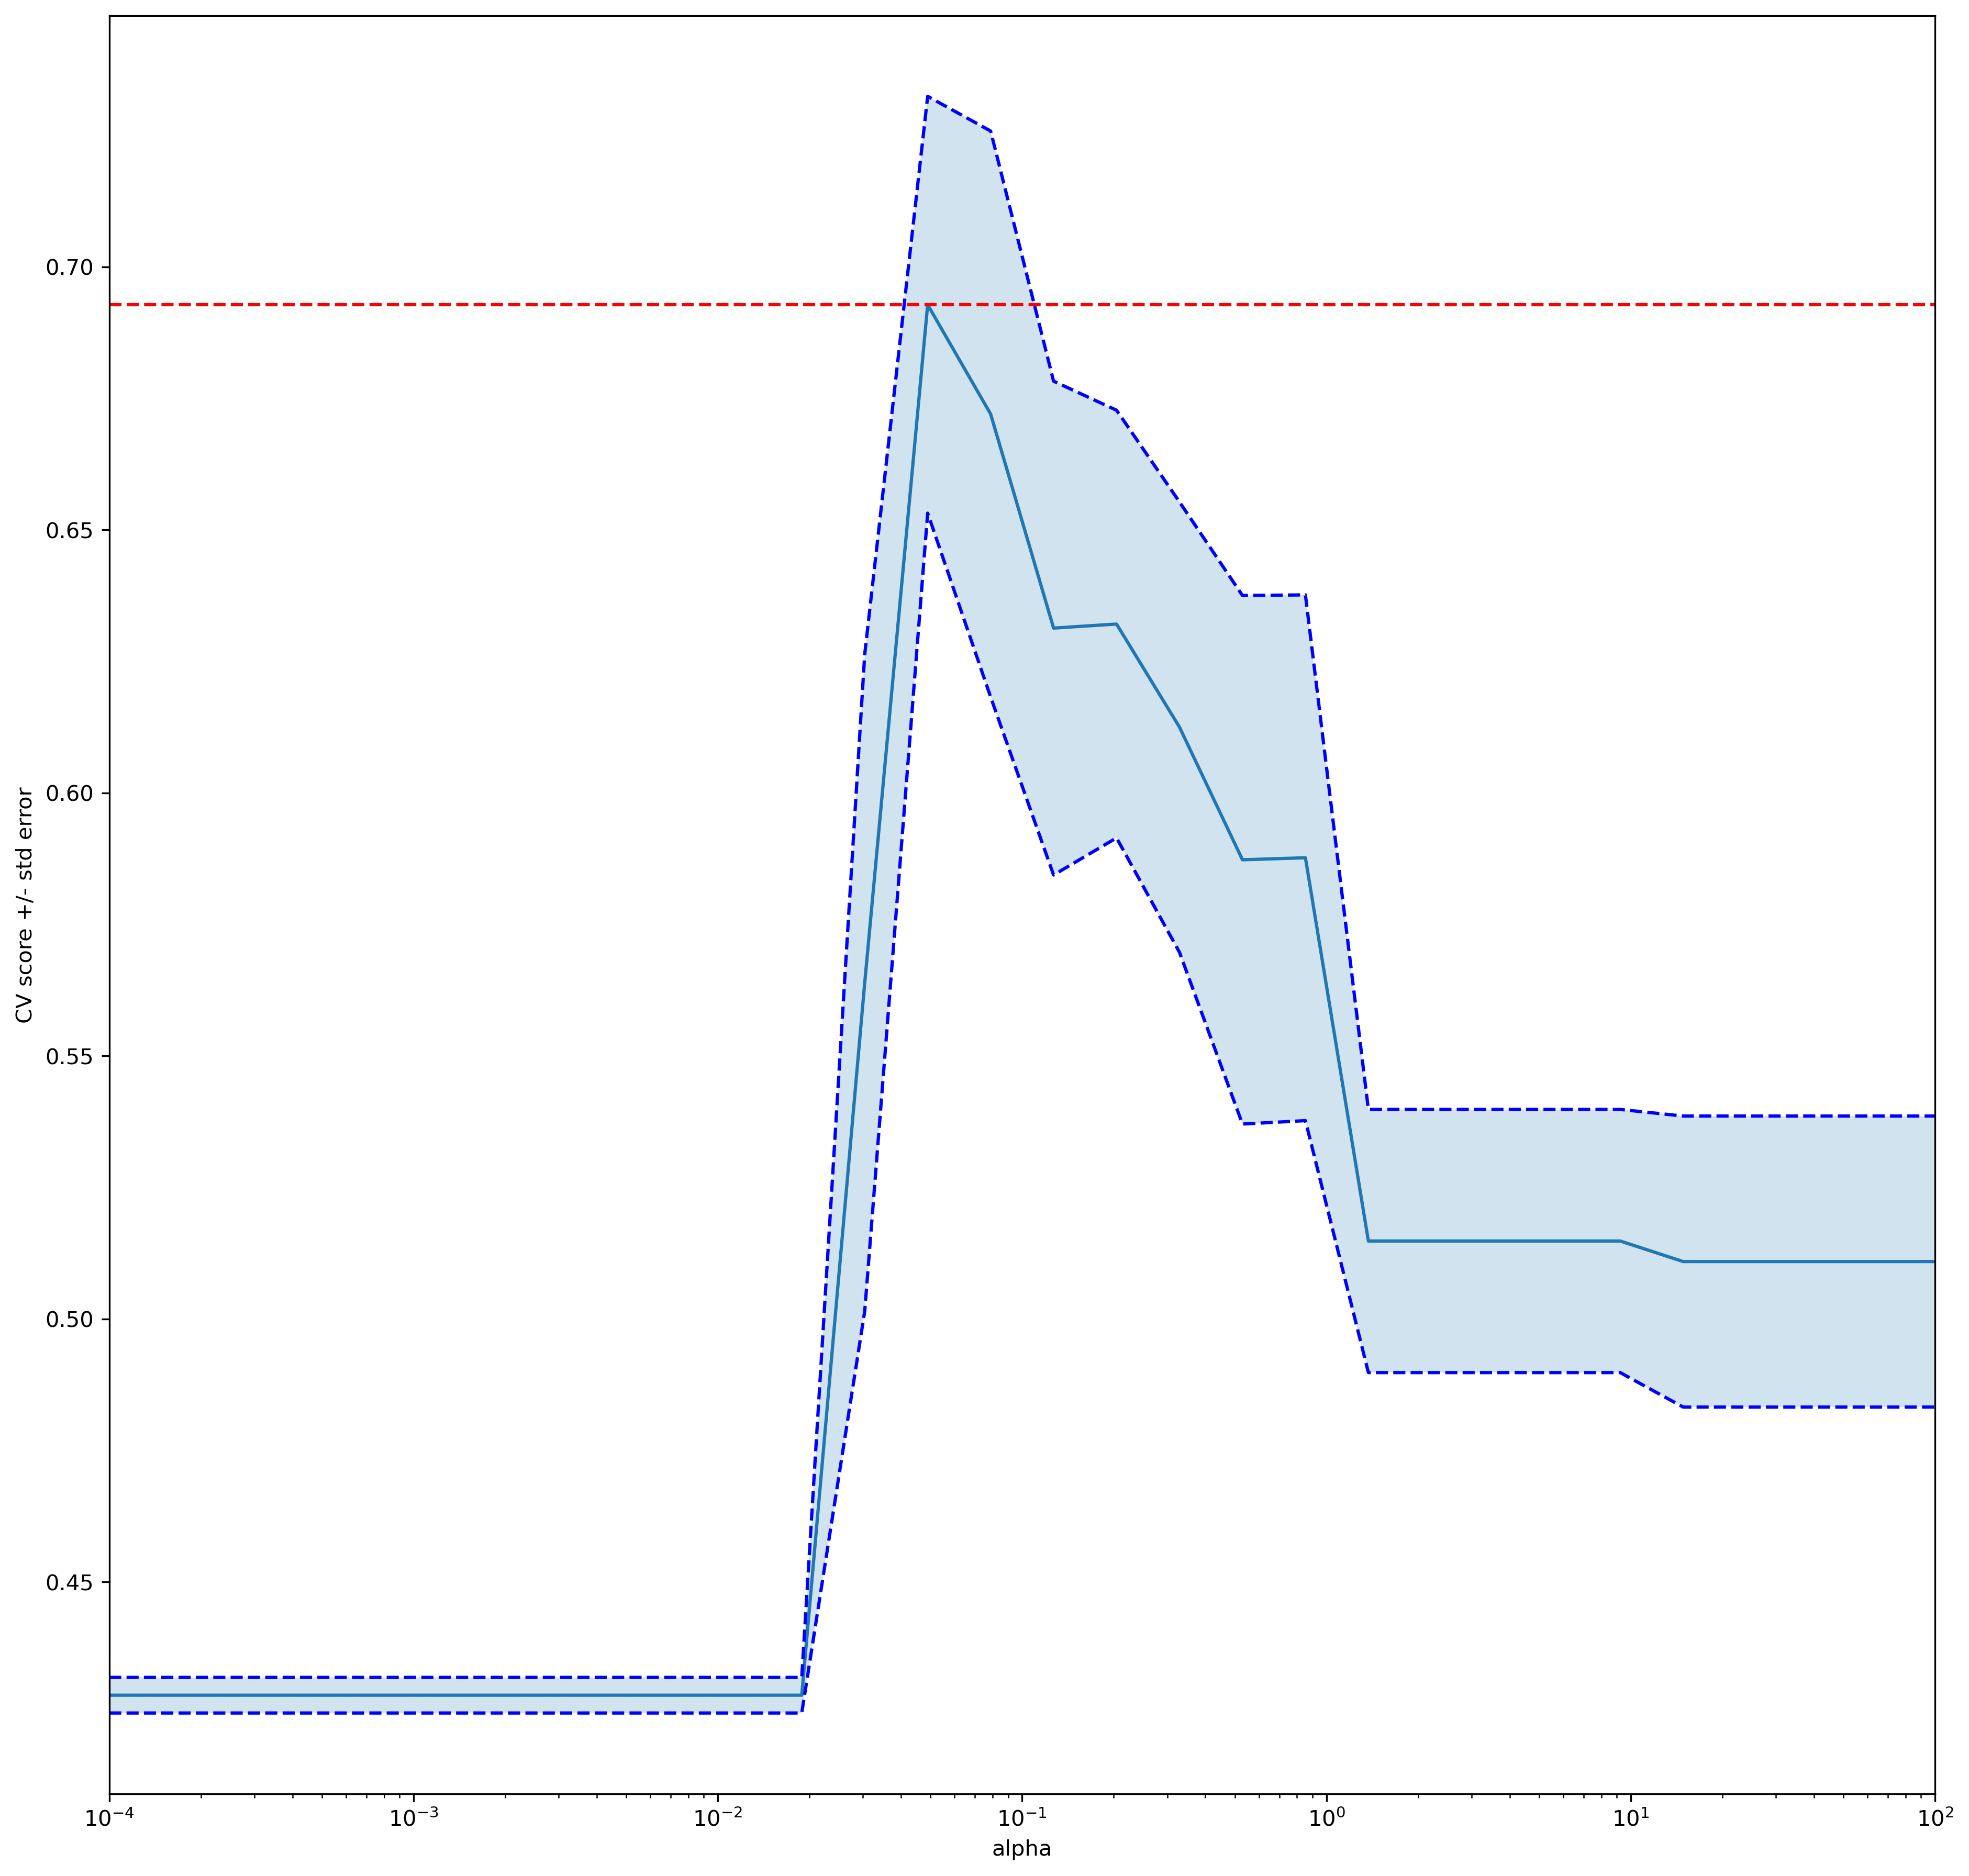

In [319]:
# does mental health status help?
abpain_df_col = ['PMHMentalHealth']

df5 = pd.merge(clean_df4,abpain_df[['PtSSN']+abpain_df_col],on='PtSSN')
df5.PMHMentalHealth = df5.PMHMentalHealth.apply(lambda x: 0 if x=='No' else 1)

X = df5[df5.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df5['label']])

clf = tune_model(X,y)


(84, 43) (84,)
AUC =  0.6916025641025643 0.18517414551796996
F1 =  0.6928085133257547 0.08859720244650383
Accuracy =  0.8102941176470587 0.08529411764705881
Confusion matrix:
[[63  0]
 [15  6]]
10  features chosen by L1 model.


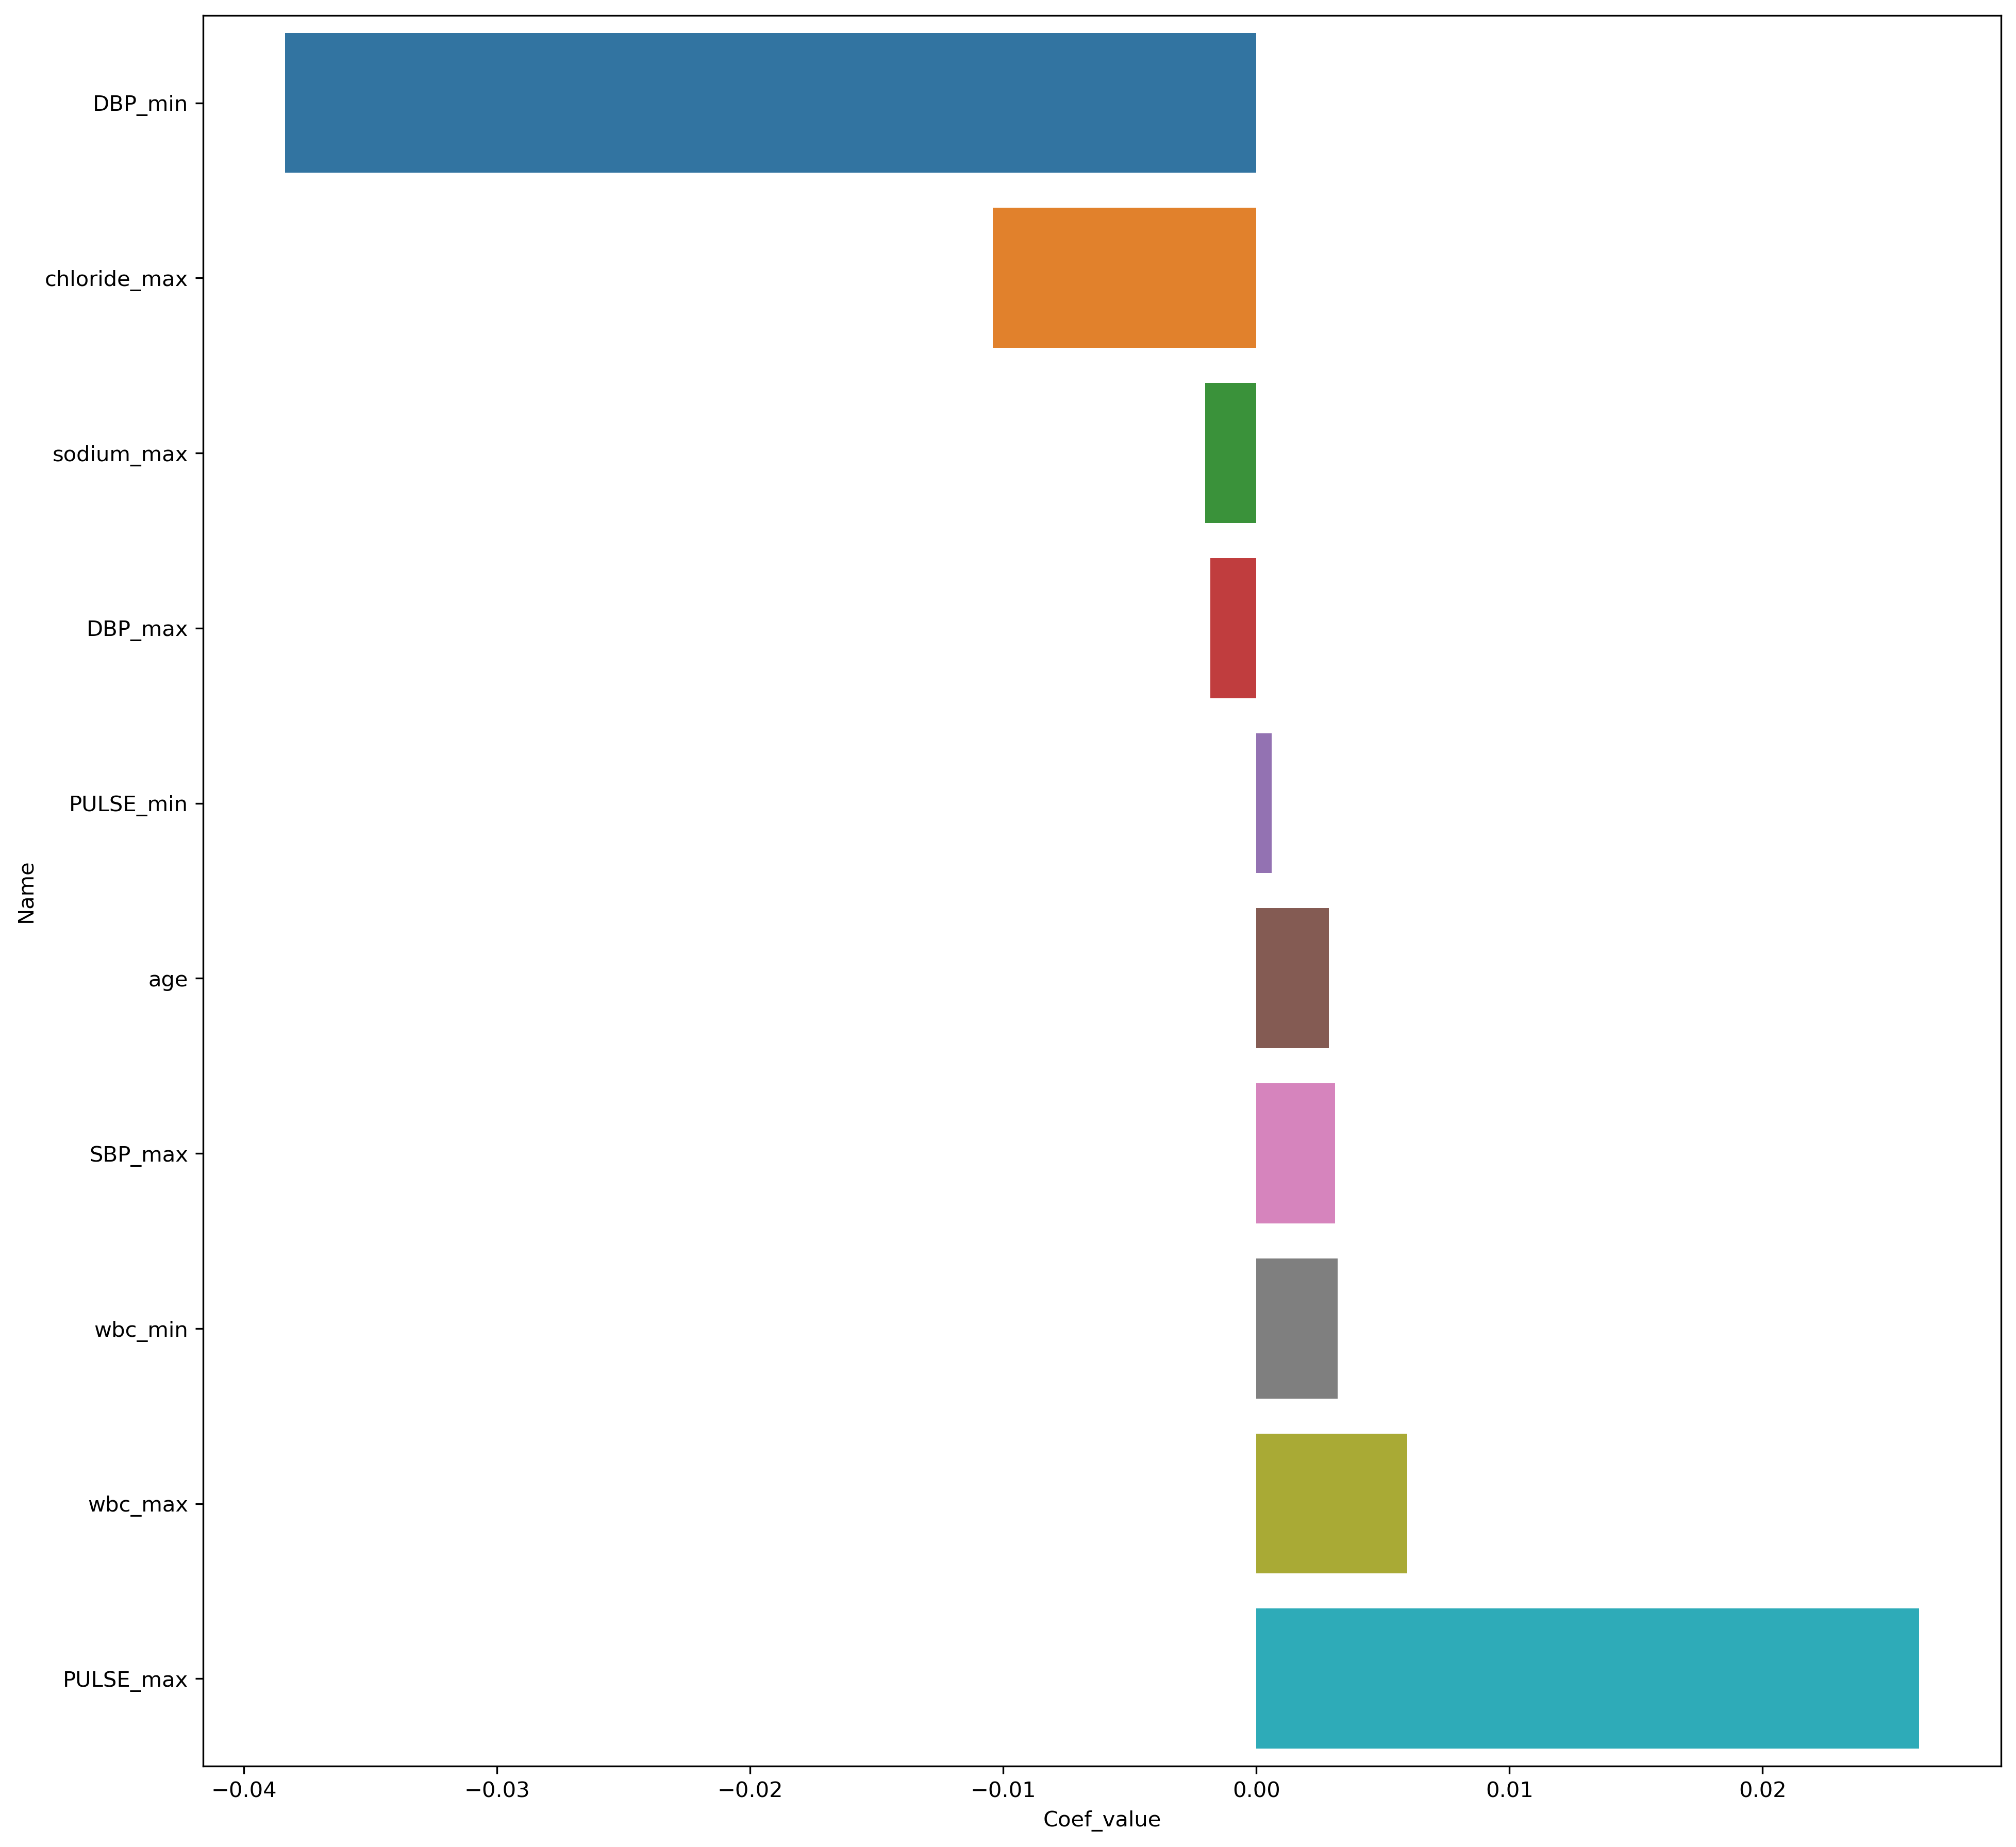

In [320]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

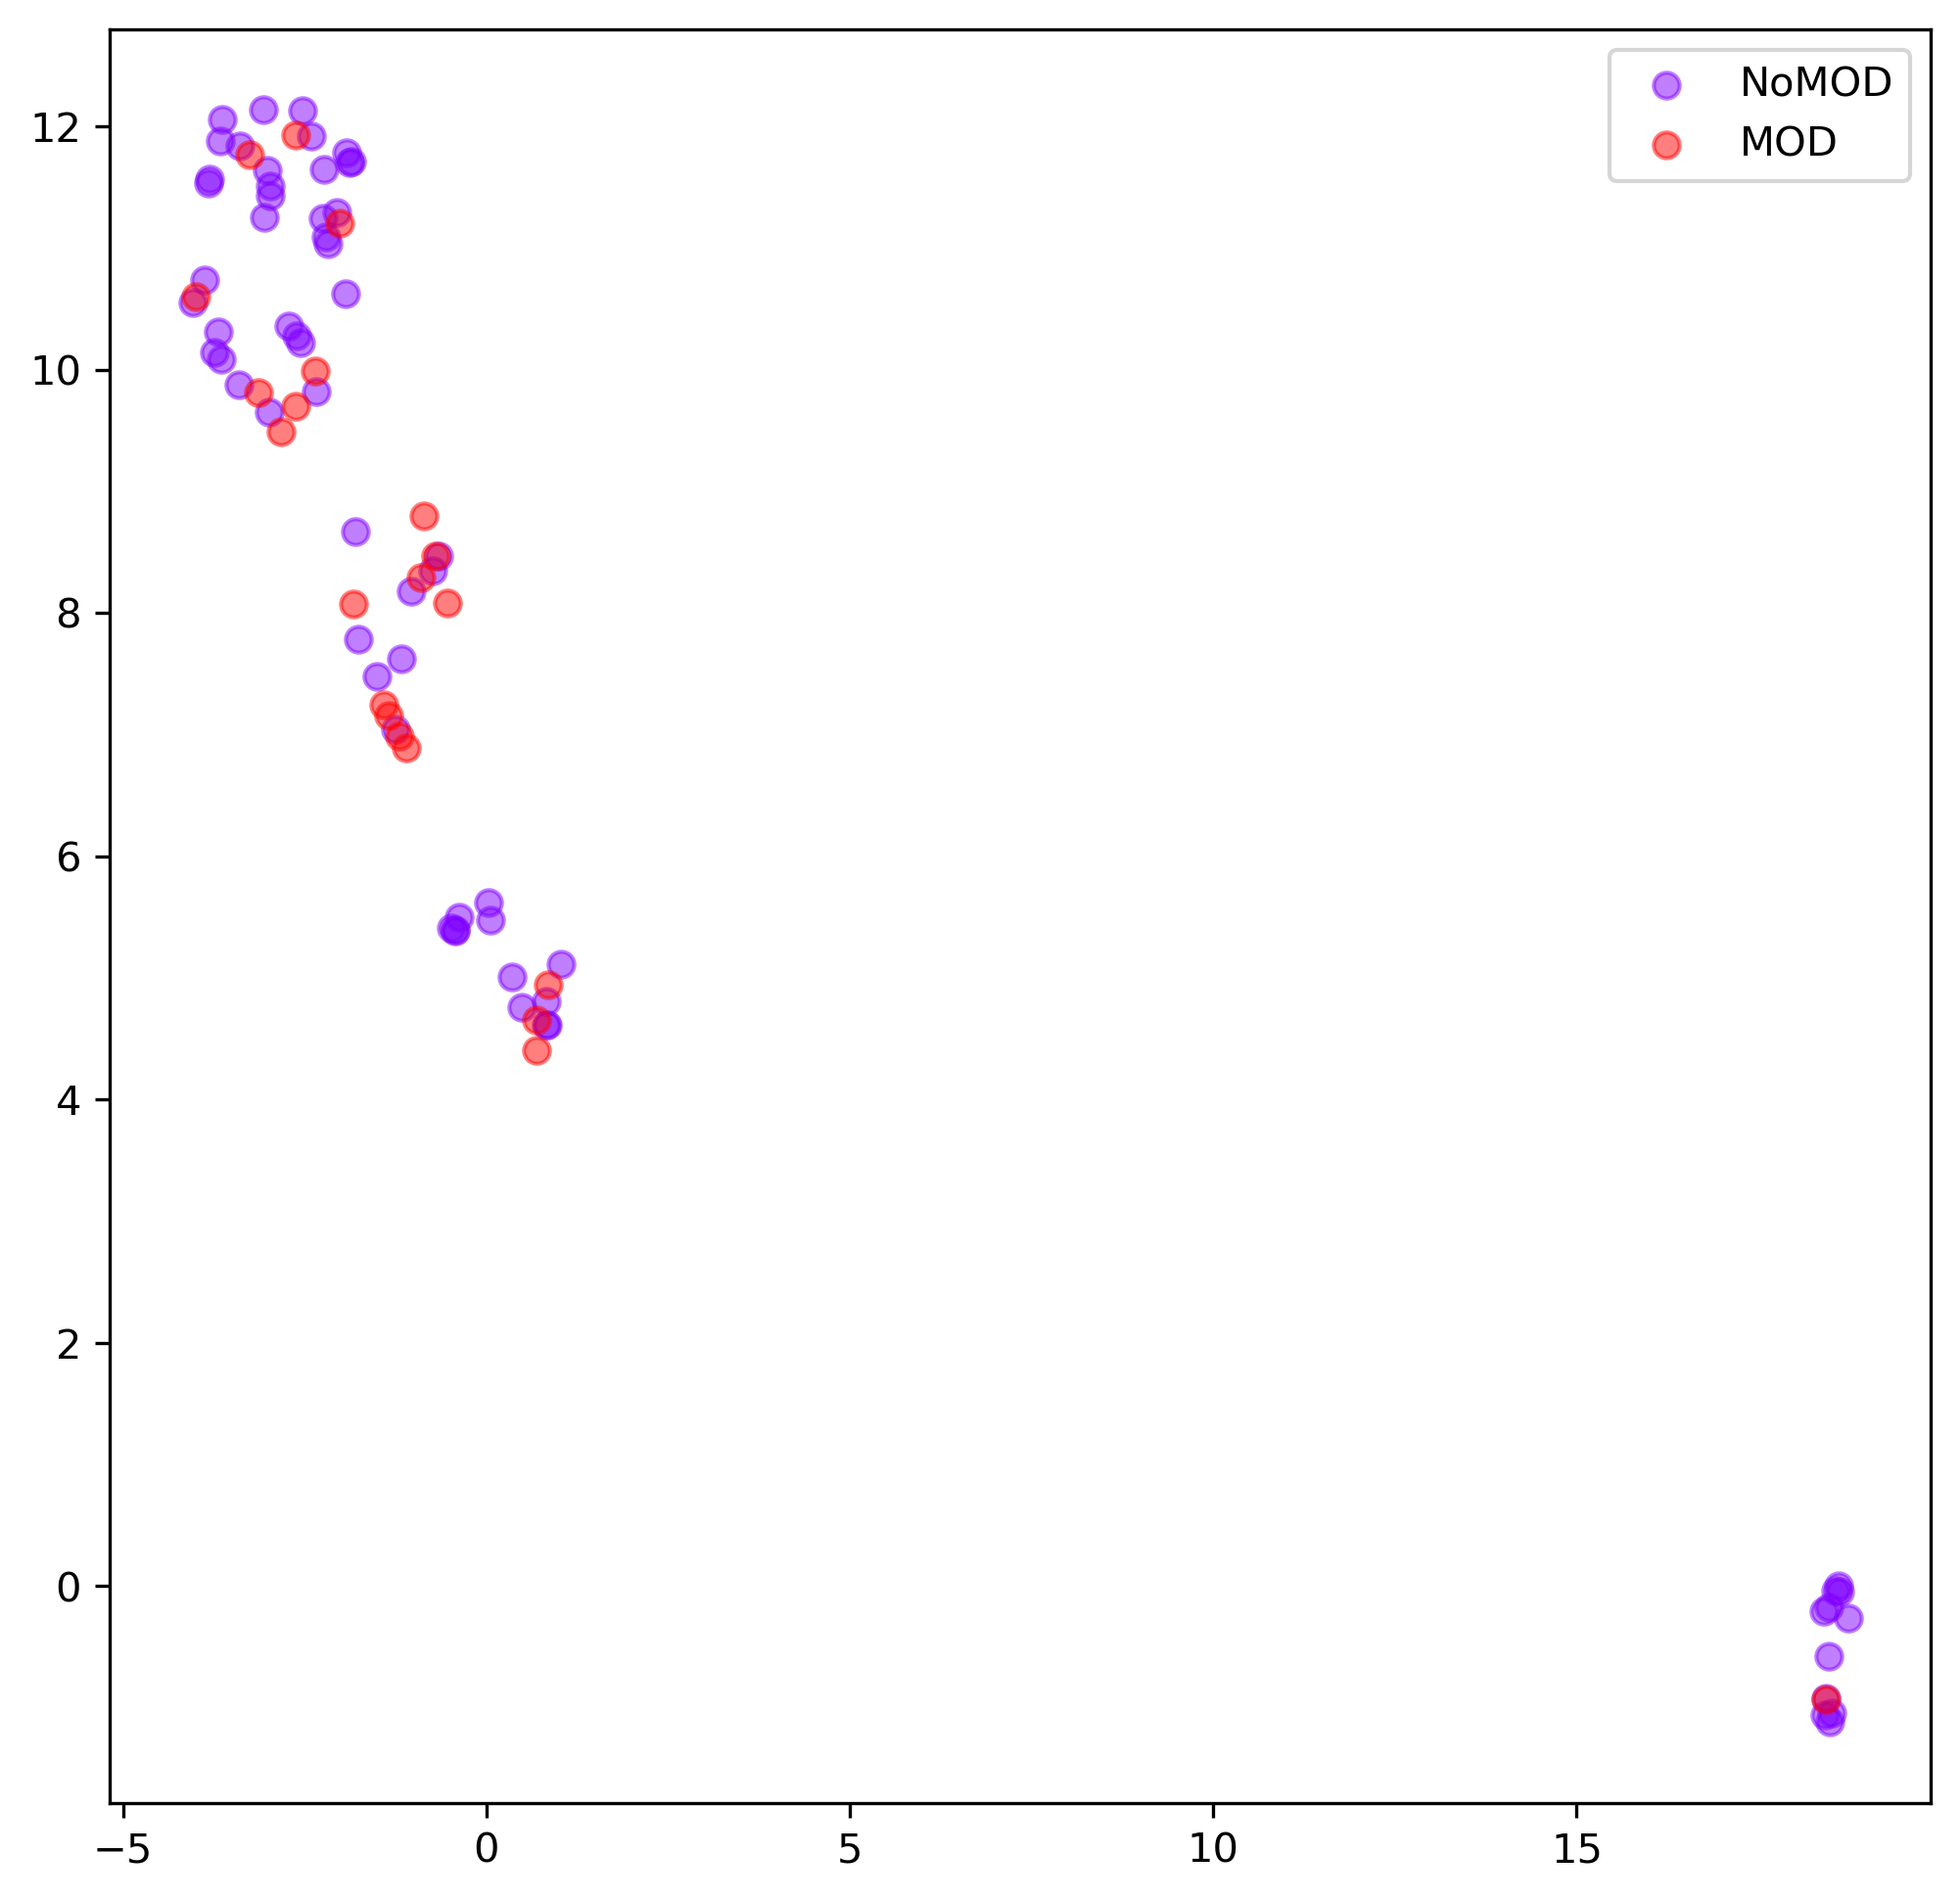

In [321]:
umap_plot_label(X[select_feats],y,1,7,['NoMOD','MOD']);

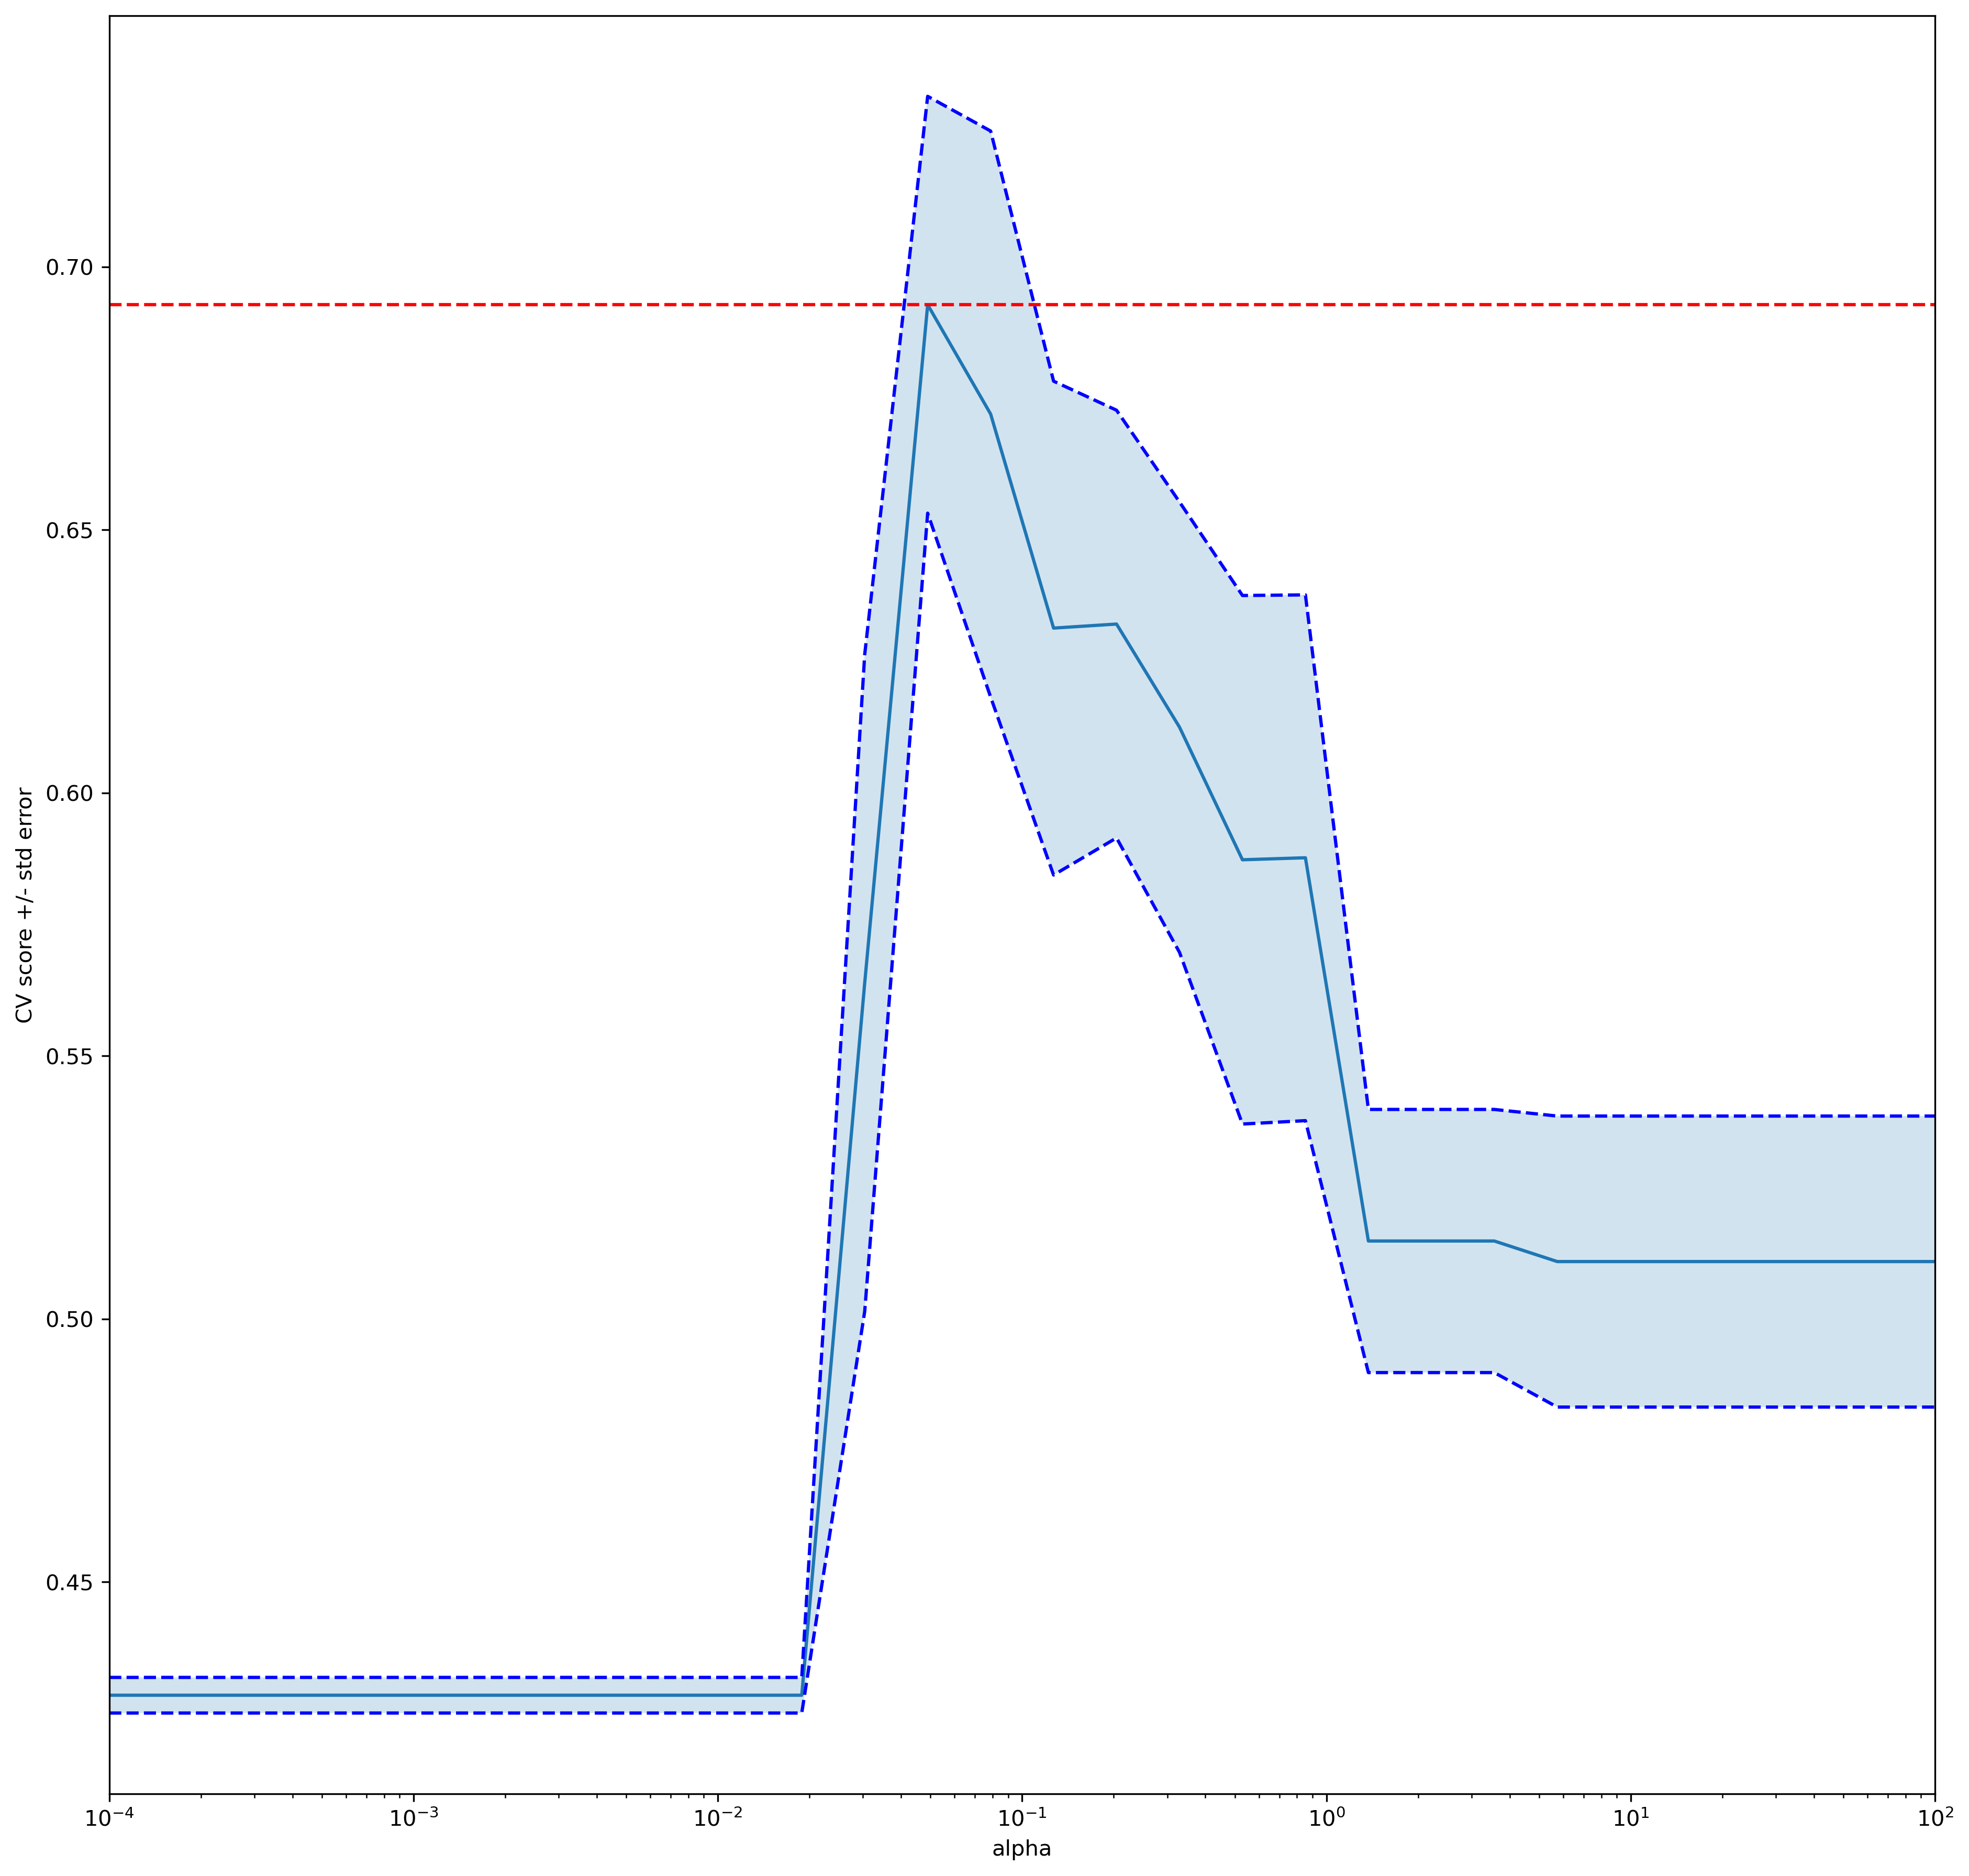

In [322]:
# add consults information
df6 = pd.merge(clean_df4,consult_dept_df_labeled,on=['PtSSN','label'])

X = df6[df6.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df6['label']])

clf = tune_model(X,y)


(84, 49) (84,)
AUC =  0.6916025641025643 0.18517414551796996
F1 =  0.6928085133257547 0.08859720244650383
Accuracy =  0.8102941176470587 0.08529411764705881
Confusion matrix:
[[63  0]
 [15  6]]
10  features chosen by L1 model.


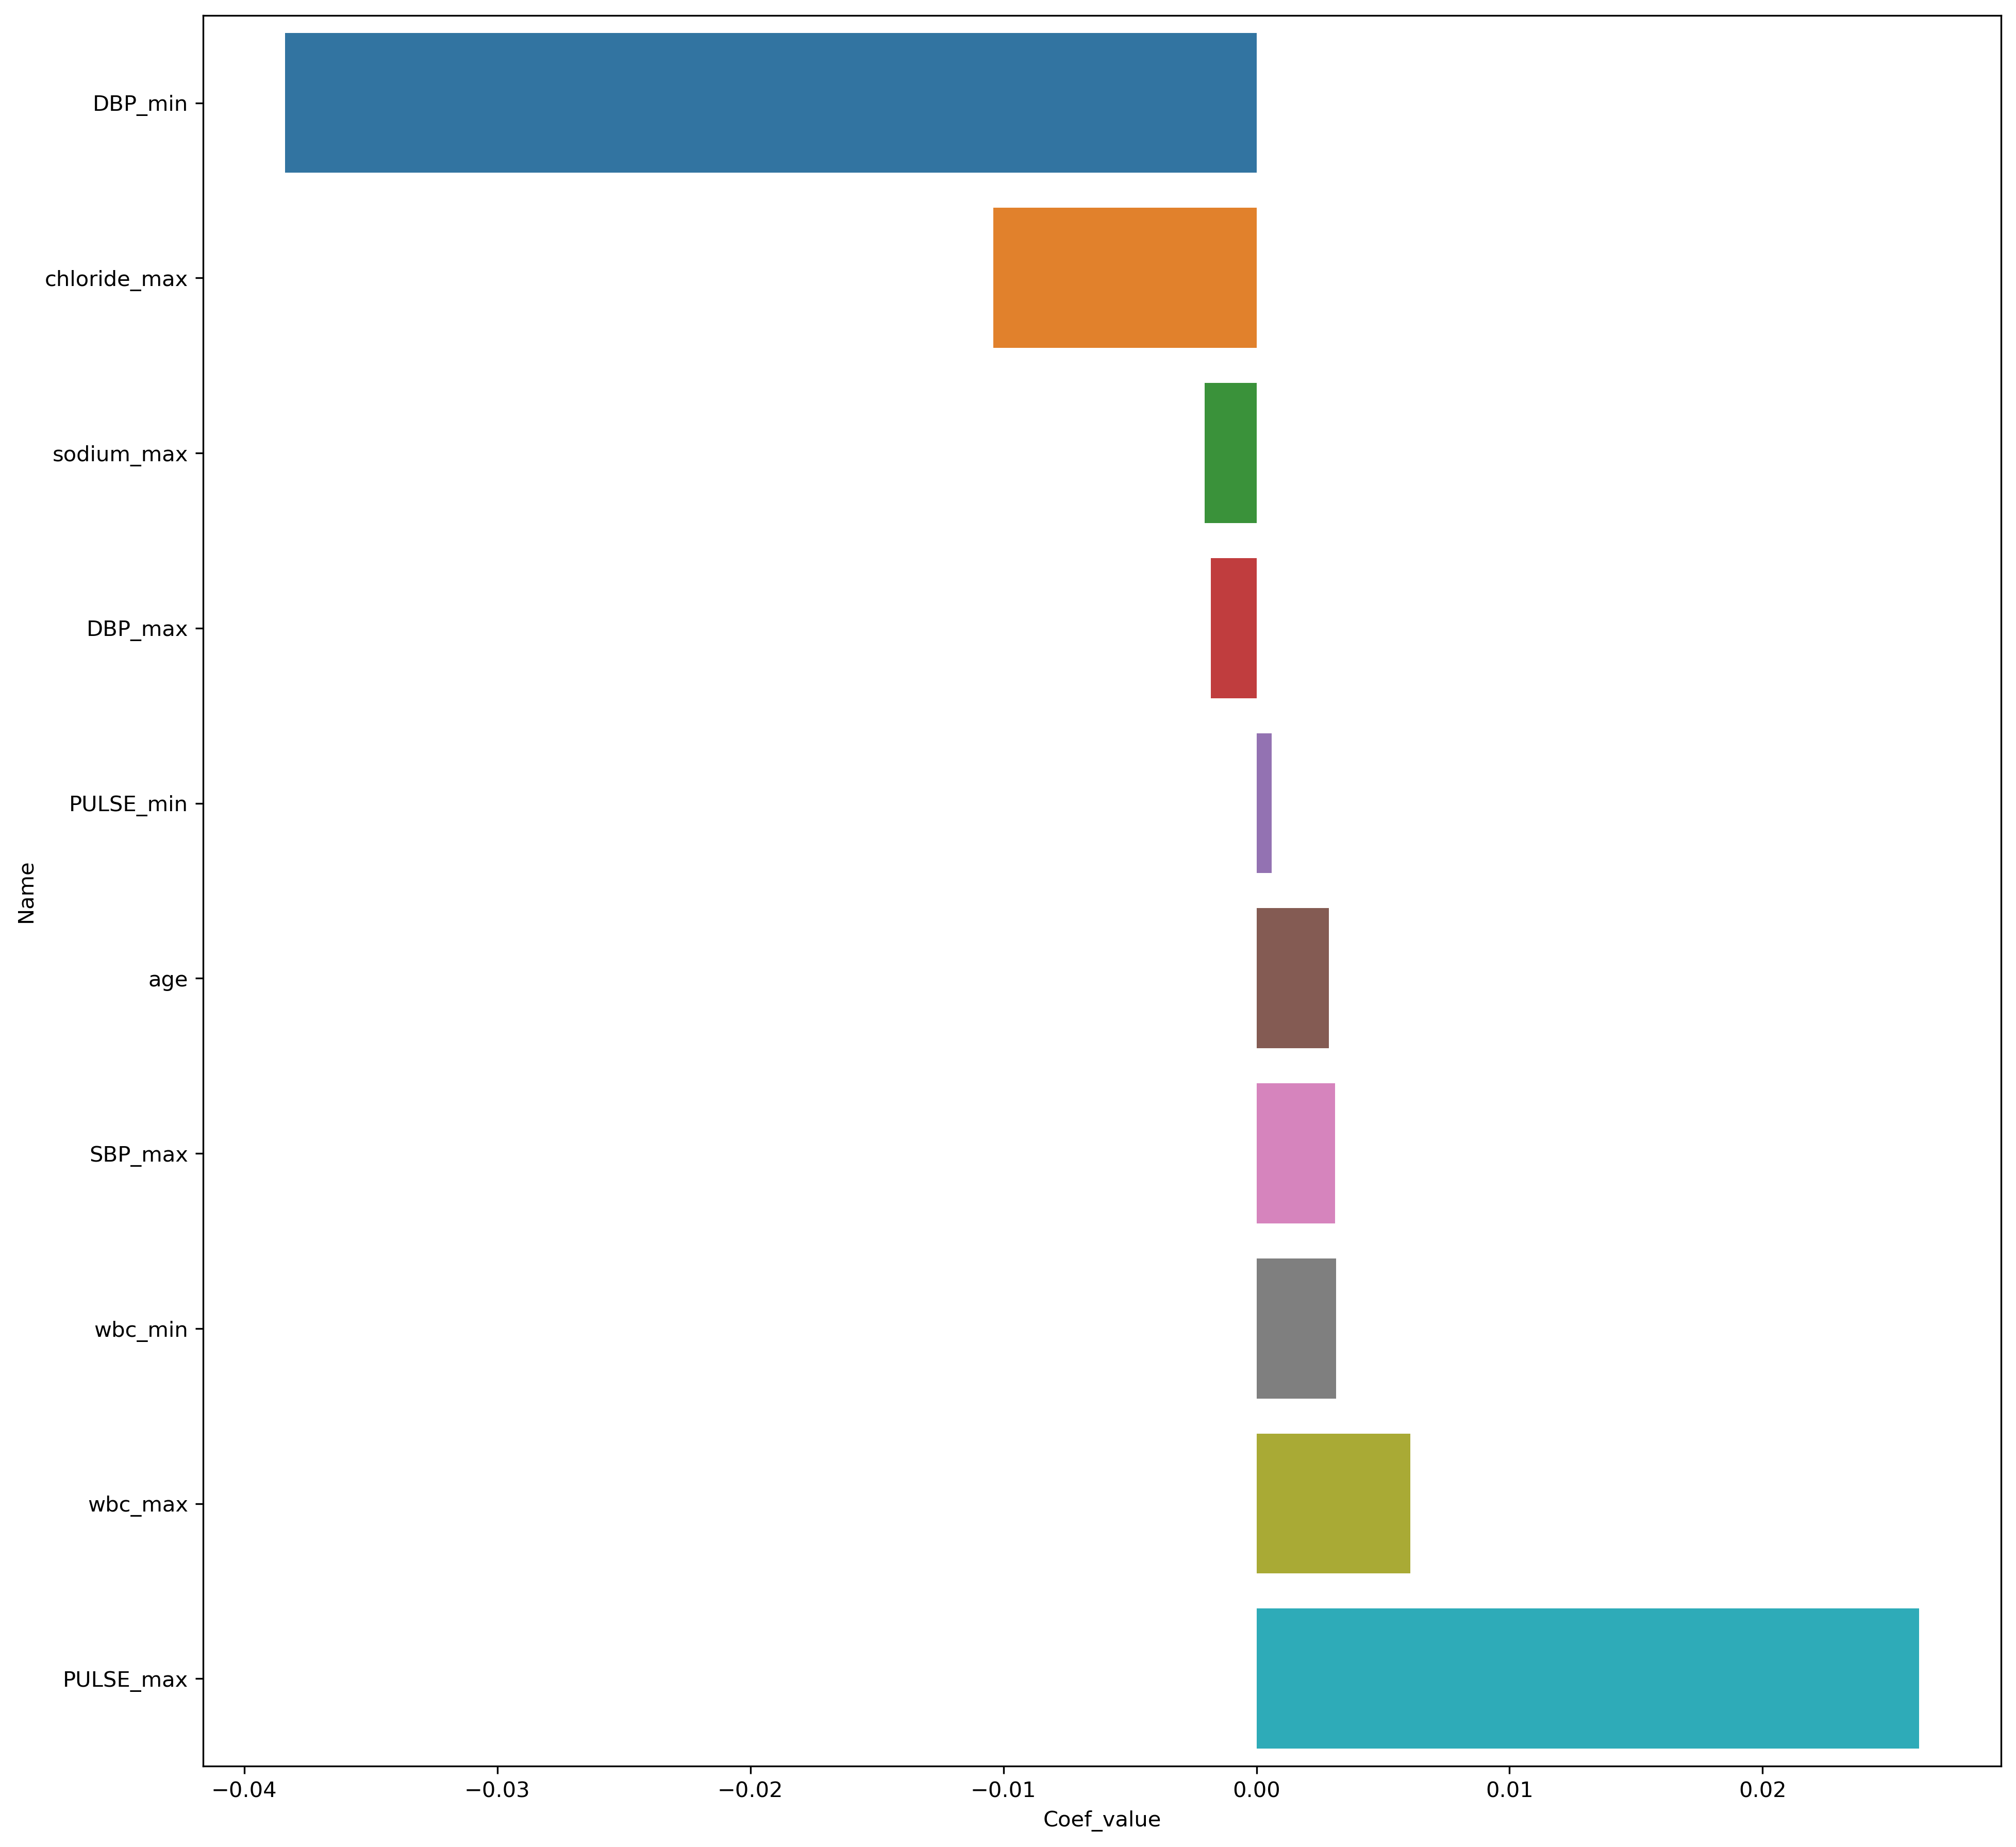

In [323]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

In [324]:
df6.columns

Index(['PtSSN', 'label', 'age', 'ed_duration', 'ed_inp_delta',
       'new_race_ALASKA/PACIFIC', 'new_race_ASIAN',
       'new_race_BLACK OR AFRICAN AMERICAN', 'new_race_UNKNOWN',
       'new_race_WHITE', 'Gender', 'Ethnicity', 'sodium_min', 'sodium_max',
       'potassium_min', 'potassium_max', 'chloride_min', 'chloride_max',
       'creat_min', 'creat_max', 'wbc_min', 'wbc_max', 'albumin_min',
       'albumin_max', 'lactate_count', 'troponin_count', 'amylase_count',
       'urine_count', 'PULSE_max', 'TEMPERATURE_max', 'SBP_max', 'DBP_max',
       'RESPIRATION_max', 'PULSE_min', 'TEMPERATURE_min', 'SBP_min', 'DBP_min',
       'RESPIRATION_min', 'num_xr', 'num_abnormal_xr', 'num_ct',
       'num_abnormal_ct', 'num_contrast', 'num_us', 'GENERAL SURGERY', 'EKG',
       'CHART CONSULT', 'UROLOGY CLINIC', 'GASTROENTEROLOGY', 'GI ENDOSCOPY',
       'CARDIOLOGY'],
      dtype='object')

In [325]:
print(len(df6))
print(len(df6['PtSSN'].unique()))
print(len(df6.groupby(['PtSSN', 'ed_duration']).size()))

84
76
84


In [326]:
abpain_cohort_labeled.columns

Index(['PtSSN', 'EDStartDateTime', 'EDEndDateTime', 'AdmitDateTime',
       'DischargeDateTime', 'ed_duration', 'ed_inp_delta', 'visits', 'label'],
      dtype='object')

In [327]:
print(len(abpain_cohort1_labeled))
print(len(abpain_cohort1_labeled['PtSSN'].unique()))
print(len(abpain_cohort1_labeled.groupby(['PtSSN', 'EDStartDateTime']).size()))

131
104
115


In [328]:
print(len(abpain_cohort1))
print(len(abpain_cohort1['PtSSN'].unique()))
print(len(abpain_cohort1.groupby(['PtSSN', 'EDStartDateTime']).size()))

915
795
820


In [329]:
print(len(abpain_cohort))
print(len(abpain_cohort['PtSSN'].unique()))
print(len(abpain_cohort.groupby(['PtSSN', 'EDStartDateTime']).size()))

820
795
820


# Medications in ER
- were antibiotics prescribed?


In [ ]:

antibiotics_df_labeled.rename(columns={0:'antibiotics'},inplace=True)
antibiotics_df_labeled.head()

In [331]:
df6 = pd.merge(clean_df4,antibiotics_df_labeled,on=['PtSSN','label'])
df6['SIRS'] = df6.apply(lambda x: meets_sirs(x),axis=1)

X = df6[df6.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df6['label']])

clf = tune_model(X,y)


AttributeError: 'Series' object has no attribute 'TEMPERATURE'

In [ ]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

In [ ]:
umap_plot_label(X[select_feats],y,1,7,['NoMOD','MOD']);

In [ ]:
umap_plot_label(X,y,1,7,['NoMOD','MOD']);

In [ ]:
# which MODs are we unable to pick up with this model?
ypred = clf.predict(X)
mistakes = df6.iloc[(ypred==0) & (y==1)].PtSSN

In [ ]:
abpain_df[abpain_df.PtSSN.isin(mistakes)][['PtSSN','CaseSummaryER']]

In [ ]:
df6[df6.PtSSN==zzzzzzz]

In [ ]:
# when were antibiotics started? at first visit or a subsequent visit


In [ ]:
# add diagnosis at discharge from ED fields

df7 = pd.merge(df6,icd_dx_labeled_df,on=['PtSSN','label'])

X = df7[df7.columns[2:]]
y = np.array([1 if x=='MOD' else 0 for x in df7['label']])

# best value for C is 0.1
for C in np.arange(0.1,1.1,0.1):
    print('-------------------- C = ', C)
    build_L1_model(X,y,C)


In [ ]:
clf,select_feats = build_L1_model(X,y,0.09)
visualize_model(clf,select_feats)

In [ ]:
umap_plot_label(X[select_feats],y,2,7,['NoMOD','MOD']);

In [ ]:
# many of the MODs are missed sepsis
sepsis_subset = clean_df3[(clean_df3.TEMPERATURE > 100.0) & (clean_df3.PULSE > 90)]
sepsis_subset.label.value_counts()

In [ ]:
# what difference in any of the MOD and NoMOD that meet sepsis criteria
# sodium_min, sodium_max, chloride_min, SBP, DBP
for field in clean_df3.columns[2:]:
    tstat,pval = scipy.stats.ttest_ind(sepsis_subset[sepsis_subset.label=='MOD'][field].dropna(),
                                      sepsis_subset[sepsis_subset.label=='NoMOD'][field].dropna())
    print(field,pval)

In [ ]:
good_fields = ['sodium_min','sodium_max','chloride_min','SBP','DBP']

X = sepsis_subset[good_fields]
y = np.array([1 if x=='MOD' else 0 for x in sepsis_subset['label']])

clf = tune_model(X,y)

In [ ]:
clf,select_feats = build_L1_model(X,y,clf.best_params_['C'])
visualize_model(clf,select_feats)

In [ ]:
# how to get prior history? From ICD table

abpain_icd1.shape


# Do a quick analysis of the case summary notes

In [ ]:
for PtSSN in abpain_labels_df[abpain_labels_df.label=='MOD'].PtSSN:
    print(PtSSN)
    display(abpain_df[abpain_df.PtSSN==PtSSN].CaseSummaryER)